# Individual Product Forecasting with Explanatory Variables

In [1]:
import pandas as pd
from prophet import Prophet
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import logging
import itertools
from itertools import product
%matplotlib inline

In [2]:
logging.getLogger().setLevel(logging.ERROR)

In [3]:
def calculate_smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    
    smape = 100 * np.mean(numerator / (denominator + 1e-10 ))
    return smape

In [4]:
df = pd.read_csv('../dataset/clustered_data.csv')

In [5]:
total_df = df.groupby(['Date', 'Description'], as_index=False)['UnitsSold'].sum()

In [6]:
total_df['lag_1'] = total_df['UnitsSold'].shift(1)
total_df['lag_7'] = total_df['UnitsSold'].shift(7)
total_df['lag_14'] = total_df['UnitsSold'].shift(14)

total_df['Rolling_Mean_7'] = total_df['UnitsSold'].rolling(window=7).mean()
total_df['Rolling_Std_7'] = total_df['UnitsSold'].rolling(window=7).std()

In [7]:
total_df['lag_1'] = total_df['lag_1'].ffill()
total_df['lag_7'] = total_df['lag_7'].ffill()
total_df['lag_14'] = total_df['lag_14'].ffill()

total_df['Rolling_Mean_7'] = total_df['Rolling_Mean_7'].fillna(total_df['UnitsSold'].expanding().mean())

total_df['Rolling_Std_7'] = total_df['Rolling_Std_7'].fillna(total_df['UnitsSold'].expanding().std().fillna(0))


In [8]:
total_df = total_df.rename(columns={'Date': 'date', 'UnitsSold': "y"})

In [9]:
explanatory_df = pd.read_csv('../explanatory_variables/combined_explanatory_variables.csv')

In [10]:
total_df = total_df.merge(explanatory_df, on='date', how='left')

In [11]:
total_df = total_df.rename(columns={'date': 'ds'})
total_df['ds'] = pd.to_datetime(total_df['ds'])

In [12]:
regressors = ['lag_7',
       'Rolling_Mean_7',
       'lag_14',
       'Rolling_Std_7',
       'lag_1',
       'is_Thursday',
       'is_Tuesday']

total_df[regressors] = total_df[regressors].ffill().bfill()

In [13]:
n = len(total_df)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

train_data = total_df.iloc[:train_end]
validation_data = total_df.iloc[train_end:val_end]
test_data = total_df.iloc[val_end:]

In [14]:
clip_threshold = np.percentile(total_df['y'], 99)

# Tuning

In [15]:
param_grid = {
    "changepoint_prior_scale": [0.01, 0.05, 0.1, 0.2, 0.5],
    "seasonality_prior_scale": [0.05, 0.1, 0.5, 1, 5],
    "fourier_order": [3, 5, 10]
}

best_smape = float("inf")
best_params = None
best_model = None

In [16]:
train_data = train_data.replace([np.inf, -np.inf], np.nan).dropna()
validation_data = validation_data.replace([np.inf, -np.inf], np.nan).dropna()
test_data = test_data.replace([np.inf, -np.inf], np.nan).dropna()

In [17]:
products = total_df['Description'].unique()
results = []

In [18]:
smape_scores = dict()

for prod in products:
    print(f"\n🔍 Processing Product: {prod}")
    
    product_df = total_df[total_df['Description'] == prod].copy()
    product_df = product_df.groupby('ds')[['y'] + regressors].sum().reset_index().sort_values('ds')

    if product_df.shape[0] < 30:
        continue

    train_size = int(len(product_df) * 0.6)
    val_size = int(len(product_df) * 0.2)

    train_data = product_df.iloc[:train_size]
    validation_data = product_df.iloc[train_size:train_size + val_size]
    test_data = product_df.iloc[train_size + val_size:]

    best_smape = float("inf")
    best_params = None
    best_model = None

    for cp_scale, seas_scale, fourier in product(param_grid["changepoint_prior_scale"],
                                                 param_grid["seasonality_prior_scale"],
                                                 param_grid["fourier_order"]):
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            changepoint_prior_scale=cp_scale,
            seasonality_prior_scale=seas_scale
        )

        for reg in regressors:
            model.add_regressor(reg)

        try:
            model.fit(train_data)

            future_val = validation_data[['ds'] + regressors]
            forecast_val = model.predict(future_val)
            forecast_val['yhat'] = np.clip(forecast_val['yhat'], 0, clip_threshold)

            smape_score = calculate_smape(validation_data['y'].values, forecast_val['yhat'].values)

            if smape_score < best_smape:
                best_smape = smape_score
                best_params = (cp_scale, seas_scale, fourier)
                best_model = model

        except Exception as e:
            continue

    if best_model is None:
        continue

    # Store results
    results.append({
        'product': prod,
        'smape': best_smape,
        'best_params': best_params,
        'model': best_model,
        'train_data': train_data,
        'validation_data': validation_data,
        'test_data': test_data
    })


🔍 Processing Product: 12 pencils small tube red spotty


01:11:10 - cmdstanpy - INFO - Chain [1] start processing
01:11:10 - cmdstanpy - INFO - Chain [1] done processing
01:11:11 - cmdstanpy - INFO - Chain [1] start processing
01:11:11 - cmdstanpy - INFO - Chain [1] done processing
01:11:11 - cmdstanpy - INFO - Chain [1] start processing
01:11:11 - cmdstanpy - INFO - Chain [1] done processing
01:11:11 - cmdstanpy - INFO - Chain [1] start processing
01:11:11 - cmdstanpy - INFO - Chain [1] done processing
01:11:12 - cmdstanpy - INFO - Chain [1] start processing
01:11:12 - cmdstanpy - INFO - Chain [1] done processing
01:11:12 - cmdstanpy - INFO - Chain [1] start processing
01:11:12 - cmdstanpy - INFO - Chain [1] done processing
01:11:12 - cmdstanpy - INFO - Chain [1] start processing
01:11:13 - cmdstanpy - INFO - Chain [1] done processing
01:11:13 - cmdstanpy - INFO - Chain [1] start processing
01:11:13 - cmdstanpy - INFO - Chain [1] done processing
01:11:13 - cmdstanpy - INFO - Chain [1] start processing
01:11:14 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: 12 pencils tall tube posy


01:11:45 - cmdstanpy - INFO - Chain [1] done processing
01:11:46 - cmdstanpy - INFO - Chain [1] start processing
01:11:46 - cmdstanpy - INFO - Chain [1] done processing
01:11:46 - cmdstanpy - INFO - Chain [1] start processing
01:11:46 - cmdstanpy - INFO - Chain [1] done processing
01:11:47 - cmdstanpy - INFO - Chain [1] start processing
01:11:47 - cmdstanpy - INFO - Chain [1] done processing
01:11:47 - cmdstanpy - INFO - Chain [1] start processing
01:11:47 - cmdstanpy - INFO - Chain [1] done processing
01:11:48 - cmdstanpy - INFO - Chain [1] start processing
01:11:48 - cmdstanpy - INFO - Chain [1] done processing
01:11:48 - cmdstanpy - INFO - Chain [1] start processing
01:11:48 - cmdstanpy - INFO - Chain [1] done processing
01:11:49 - cmdstanpy - INFO - Chain [1] start processing
01:11:49 - cmdstanpy - INFO - Chain [1] done processing
01:11:49 - cmdstanpy - INFO - Chain [1] start processing
01:11:50 - cmdstanpy - INFO - Chain [1] done processing
01:11:50 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: 12 pencils tall tube woodland


01:12:42 - cmdstanpy - INFO - Chain [1] done processing
01:12:43 - cmdstanpy - INFO - Chain [1] start processing
01:12:43 - cmdstanpy - INFO - Chain [1] done processing
01:12:44 - cmdstanpy - INFO - Chain [1] start processing
01:12:44 - cmdstanpy - INFO - Chain [1] done processing
01:12:44 - cmdstanpy - INFO - Chain [1] start processing
01:12:44 - cmdstanpy - INFO - Chain [1] done processing
01:12:45 - cmdstanpy - INFO - Chain [1] start processing
01:12:45 - cmdstanpy - INFO - Chain [1] done processing
01:12:45 - cmdstanpy - INFO - Chain [1] start processing
01:12:45 - cmdstanpy - INFO - Chain [1] done processing
01:12:46 - cmdstanpy - INFO - Chain [1] start processing
01:12:46 - cmdstanpy - INFO - Chain [1] done processing
01:12:46 - cmdstanpy - INFO - Chain [1] start processing
01:12:46 - cmdstanpy - INFO - Chain [1] done processing
01:12:47 - cmdstanpy - INFO - Chain [1] start processing
01:12:47 - cmdstanpy - INFO - Chain [1] done processing
01:12:47 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: 6 ribbons rustic charm


01:13:21 - cmdstanpy - INFO - Chain [1] done processing
01:13:22 - cmdstanpy - INFO - Chain [1] start processing
01:13:22 - cmdstanpy - INFO - Chain [1] done processing
01:13:22 - cmdstanpy - INFO - Chain [1] start processing
01:13:22 - cmdstanpy - INFO - Chain [1] done processing
01:13:23 - cmdstanpy - INFO - Chain [1] start processing
01:13:23 - cmdstanpy - INFO - Chain [1] done processing
01:13:23 - cmdstanpy - INFO - Chain [1] start processing
01:13:23 - cmdstanpy - INFO - Chain [1] done processing
01:13:24 - cmdstanpy - INFO - Chain [1] start processing
01:13:24 - cmdstanpy - INFO - Chain [1] done processing
01:13:24 - cmdstanpy - INFO - Chain [1] start processing
01:13:24 - cmdstanpy - INFO - Chain [1] done processing
01:13:25 - cmdstanpy - INFO - Chain [1] start processing
01:13:25 - cmdstanpy - INFO - Chain [1] done processing
01:13:25 - cmdstanpy - INFO - Chain [1] start processing
01:13:25 - cmdstanpy - INFO - Chain [1] done processing
01:13:25 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: 60 teatime fairy cake cases


01:14:09 - cmdstanpy - INFO - Chain [1] start processing
01:14:09 - cmdstanpy - INFO - Chain [1] done processing
01:14:09 - cmdstanpy - INFO - Chain [1] start processing
01:14:09 - cmdstanpy - INFO - Chain [1] done processing
01:14:10 - cmdstanpy - INFO - Chain [1] start processing
01:14:10 - cmdstanpy - INFO - Chain [1] done processing
01:14:10 - cmdstanpy - INFO - Chain [1] start processing
01:14:10 - cmdstanpy - INFO - Chain [1] done processing
01:14:11 - cmdstanpy - INFO - Chain [1] start processing
01:14:11 - cmdstanpy - INFO - Chain [1] done processing
01:14:11 - cmdstanpy - INFO - Chain [1] start processing
01:14:11 - cmdstanpy - INFO - Chain [1] done processing
01:14:11 - cmdstanpy - INFO - Chain [1] start processing
01:14:11 - cmdstanpy - INFO - Chain [1] done processing
01:14:12 - cmdstanpy - INFO - Chain [1] start processing
01:14:12 - cmdstanpy - INFO - Chain [1] done processing
01:14:12 - cmdstanpy - INFO - Chain [1] start processing
01:14:12 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: 72 sweetheart fairy cake cases


01:14:50 - cmdstanpy - INFO - Chain [1] done processing
01:14:50 - cmdstanpy - INFO - Chain [1] start processing
01:14:50 - cmdstanpy - INFO - Chain [1] done processing
01:14:50 - cmdstanpy - INFO - Chain [1] start processing
01:14:51 - cmdstanpy - INFO - Chain [1] done processing
01:14:51 - cmdstanpy - INFO - Chain [1] start processing
01:14:51 - cmdstanpy - INFO - Chain [1] done processing
01:14:51 - cmdstanpy - INFO - Chain [1] start processing
01:14:51 - cmdstanpy - INFO - Chain [1] done processing
01:14:52 - cmdstanpy - INFO - Chain [1] start processing
01:14:52 - cmdstanpy - INFO - Chain [1] done processing
01:14:52 - cmdstanpy - INFO - Chain [1] start processing
01:14:52 - cmdstanpy - INFO - Chain [1] done processing
01:14:53 - cmdstanpy - INFO - Chain [1] start processing
01:14:53 - cmdstanpy - INFO - Chain [1] done processing
01:14:53 - cmdstanpy - INFO - Chain [1] start processing
01:14:53 - cmdstanpy - INFO - Chain [1] done processing
01:14:54 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: antique silver tea glass etched


01:15:27 - cmdstanpy - INFO - Chain [1] done processing
01:15:27 - cmdstanpy - INFO - Chain [1] start processing
01:15:27 - cmdstanpy - INFO - Chain [1] done processing
01:15:28 - cmdstanpy - INFO - Chain [1] start processing
01:15:28 - cmdstanpy - INFO - Chain [1] done processing
01:15:28 - cmdstanpy - INFO - Chain [1] start processing
01:15:28 - cmdstanpy - INFO - Chain [1] done processing
01:15:29 - cmdstanpy - INFO - Chain [1] start processing
01:15:29 - cmdstanpy - INFO - Chain [1] done processing
01:15:29 - cmdstanpy - INFO - Chain [1] start processing
01:15:29 - cmdstanpy - INFO - Chain [1] done processing
01:15:29 - cmdstanpy - INFO - Chain [1] start processing
01:15:30 - cmdstanpy - INFO - Chain [1] done processing
01:15:30 - cmdstanpy - INFO - Chain [1] start processing
01:15:30 - cmdstanpy - INFO - Chain [1] done processing
01:15:30 - cmdstanpy - INFO - Chain [1] start processing
01:15:31 - cmdstanpy - INFO - Chain [1] done processing
01:15:31 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: assorted colour bird ornament


01:16:01 - cmdstanpy - INFO - Chain [1] done processing
01:16:01 - cmdstanpy - INFO - Chain [1] start processing
01:16:01 - cmdstanpy - INFO - Chain [1] done processing
01:16:02 - cmdstanpy - INFO - Chain [1] start processing
01:16:02 - cmdstanpy - INFO - Chain [1] done processing
01:16:02 - cmdstanpy - INFO - Chain [1] start processing
01:16:03 - cmdstanpy - INFO - Chain [1] done processing
01:16:03 - cmdstanpy - INFO - Chain [1] start processing
01:16:03 - cmdstanpy - INFO - Chain [1] done processing
01:16:03 - cmdstanpy - INFO - Chain [1] start processing
01:16:03 - cmdstanpy - INFO - Chain [1] done processing
01:16:04 - cmdstanpy - INFO - Chain [1] start processing
01:16:04 - cmdstanpy - INFO - Chain [1] done processing
01:16:04 - cmdstanpy - INFO - Chain [1] start processing
01:16:04 - cmdstanpy - INFO - Chain [1] done processing
01:16:05 - cmdstanpy - INFO - Chain [1] start processing
01:16:05 - cmdstanpy - INFO - Chain [1] done processing
01:16:05 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: bag 500g swirly marbles


01:16:40 - cmdstanpy - INFO - Chain [1] start processing
01:16:40 - cmdstanpy - INFO - Chain [1] done processing
01:16:40 - cmdstanpy - INFO - Chain [1] start processing
01:16:40 - cmdstanpy - INFO - Chain [1] done processing
01:16:41 - cmdstanpy - INFO - Chain [1] start processing
01:16:41 - cmdstanpy - INFO - Chain [1] done processing
01:16:41 - cmdstanpy - INFO - Chain [1] start processing
01:16:41 - cmdstanpy - INFO - Chain [1] done processing
01:16:41 - cmdstanpy - INFO - Chain [1] start processing
01:16:42 - cmdstanpy - INFO - Chain [1] done processing
01:16:42 - cmdstanpy - INFO - Chain [1] start processing
01:16:42 - cmdstanpy - INFO - Chain [1] done processing
01:16:42 - cmdstanpy - INFO - Chain [1] start processing
01:16:42 - cmdstanpy - INFO - Chain [1] done processing
01:16:43 - cmdstanpy - INFO - Chain [1] start processing
01:16:43 - cmdstanpy - INFO - Chain [1] done processing
01:16:43 - cmdstanpy - INFO - Chain [1] start processing
01:16:44 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: baking set 9 piece retrospot


01:17:16 - cmdstanpy - INFO - Chain [1] done processing
01:17:17 - cmdstanpy - INFO - Chain [1] start processing
01:17:17 - cmdstanpy - INFO - Chain [1] done processing
01:17:17 - cmdstanpy - INFO - Chain [1] start processing
01:17:17 - cmdstanpy - INFO - Chain [1] done processing
01:17:18 - cmdstanpy - INFO - Chain [1] start processing
01:17:18 - cmdstanpy - INFO - Chain [1] done processing
01:17:18 - cmdstanpy - INFO - Chain [1] start processing
01:17:18 - cmdstanpy - INFO - Chain [1] done processing
01:17:19 - cmdstanpy - INFO - Chain [1] start processing
01:17:19 - cmdstanpy - INFO - Chain [1] done processing
01:17:19 - cmdstanpy - INFO - Chain [1] start processing
01:17:19 - cmdstanpy - INFO - Chain [1] done processing
01:17:19 - cmdstanpy - INFO - Chain [1] start processing
01:17:20 - cmdstanpy - INFO - Chain [1] done processing
01:17:20 - cmdstanpy - INFO - Chain [1] start processing
01:17:20 - cmdstanpy - INFO - Chain [1] done processing
01:17:20 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: baking set spaceboy design


01:18:23 - cmdstanpy - INFO - Chain [1] done processing
01:18:24 - cmdstanpy - INFO - Chain [1] start processing
01:18:24 - cmdstanpy - INFO - Chain [1] done processing
01:18:24 - cmdstanpy - INFO - Chain [1] start processing
01:18:24 - cmdstanpy - INFO - Chain [1] done processing
01:18:24 - cmdstanpy - INFO - Chain [1] start processing
01:18:24 - cmdstanpy - INFO - Chain [1] done processing
01:18:25 - cmdstanpy - INFO - Chain [1] start processing
01:18:25 - cmdstanpy - INFO - Chain [1] done processing
01:18:25 - cmdstanpy - INFO - Chain [1] start processing
01:18:25 - cmdstanpy - INFO - Chain [1] done processing
01:18:26 - cmdstanpy - INFO - Chain [1] start processing
01:18:26 - cmdstanpy - INFO - Chain [1] done processing
01:18:26 - cmdstanpy - INFO - Chain [1] start processing
01:18:26 - cmdstanpy - INFO - Chain [1] done processing
01:18:26 - cmdstanpy - INFO - Chain [1] start processing
01:18:26 - cmdstanpy - INFO - Chain [1] done processing
01:18:27 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: bathroom metal sign


01:19:19 - cmdstanpy - INFO - Chain [1] done processing
01:19:19 - cmdstanpy - INFO - Chain [1] start processing
01:19:19 - cmdstanpy - INFO - Chain [1] done processing
01:19:19 - cmdstanpy - INFO - Chain [1] start processing
01:19:19 - cmdstanpy - INFO - Chain [1] done processing
01:19:20 - cmdstanpy - INFO - Chain [1] start processing
01:19:20 - cmdstanpy - INFO - Chain [1] done processing
01:19:20 - cmdstanpy - INFO - Chain [1] start processing
01:19:20 - cmdstanpy - INFO - Chain [1] done processing
01:19:20 - cmdstanpy - INFO - Chain [1] start processing
01:19:20 - cmdstanpy - INFO - Chain [1] done processing
01:19:21 - cmdstanpy - INFO - Chain [1] start processing
01:19:21 - cmdstanpy - INFO - Chain [1] done processing
01:19:21 - cmdstanpy - INFO - Chain [1] start processing
01:19:21 - cmdstanpy - INFO - Chain [1] done processing
01:19:21 - cmdstanpy - INFO - Chain [1] start processing
01:19:21 - cmdstanpy - INFO - Chain [1] done processing
01:19:22 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: blue happy birthday bunting


01:19:46 - cmdstanpy - INFO - Chain [1] done processing
01:19:47 - cmdstanpy - INFO - Chain [1] start processing
01:19:47 - cmdstanpy - INFO - Chain [1] done processing
01:19:47 - cmdstanpy - INFO - Chain [1] start processing
01:19:47 - cmdstanpy - INFO - Chain [1] done processing
01:19:47 - cmdstanpy - INFO - Chain [1] start processing
01:19:47 - cmdstanpy - INFO - Chain [1] done processing
01:19:48 - cmdstanpy - INFO - Chain [1] start processing
01:19:48 - cmdstanpy - INFO - Chain [1] done processing
01:19:48 - cmdstanpy - INFO - Chain [1] start processing
01:19:48 - cmdstanpy - INFO - Chain [1] done processing
01:19:48 - cmdstanpy - INFO - Chain [1] start processing
01:19:48 - cmdstanpy - INFO - Chain [1] done processing
01:19:49 - cmdstanpy - INFO - Chain [1] start processing
01:19:49 - cmdstanpy - INFO - Chain [1] done processing
01:19:49 - cmdstanpy - INFO - Chain [1] start processing
01:19:49 - cmdstanpy - INFO - Chain [1] done processing
01:19:49 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: blue harmonica in box


01:20:14 - cmdstanpy - INFO - Chain [1] done processing
01:20:14 - cmdstanpy - INFO - Chain [1] start processing
01:20:14 - cmdstanpy - INFO - Chain [1] done processing
01:20:14 - cmdstanpy - INFO - Chain [1] start processing
01:20:15 - cmdstanpy - INFO - Chain [1] done processing
01:20:15 - cmdstanpy - INFO - Chain [1] start processing
01:20:15 - cmdstanpy - INFO - Chain [1] done processing
01:20:16 - cmdstanpy - INFO - Chain [1] start processing
01:20:16 - cmdstanpy - INFO - Chain [1] done processing
01:20:17 - cmdstanpy - INFO - Chain [1] start processing
01:20:17 - cmdstanpy - INFO - Chain [1] done processing
01:20:17 - cmdstanpy - INFO - Chain [1] start processing
01:20:17 - cmdstanpy - INFO - Chain [1] done processing
01:20:18 - cmdstanpy - INFO - Chain [1] start processing
01:20:18 - cmdstanpy - INFO - Chain [1] done processing
01:20:18 - cmdstanpy - INFO - Chain [1] start processing
01:20:18 - cmdstanpy - INFO - Chain [1] done processing
01:20:19 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: box of 24 cocktail parasols


01:21:22 - cmdstanpy - INFO - Chain [1] done processing
01:21:22 - cmdstanpy - INFO - Chain [1] start processing
01:21:22 - cmdstanpy - INFO - Chain [1] done processing
01:21:22 - cmdstanpy - INFO - Chain [1] start processing
01:21:23 - cmdstanpy - INFO - Chain [1] done processing
01:21:23 - cmdstanpy - INFO - Chain [1] start processing
01:21:23 - cmdstanpy - INFO - Chain [1] done processing
01:21:23 - cmdstanpy - INFO - Chain [1] start processing
01:21:23 - cmdstanpy - INFO - Chain [1] done processing
01:21:24 - cmdstanpy - INFO - Chain [1] start processing
01:21:24 - cmdstanpy - INFO - Chain [1] done processing
01:21:24 - cmdstanpy - INFO - Chain [1] start processing
01:21:24 - cmdstanpy - INFO - Chain [1] done processing
01:21:25 - cmdstanpy - INFO - Chain [1] start processing
01:21:25 - cmdstanpy - INFO - Chain [1] done processing
01:21:25 - cmdstanpy - INFO - Chain [1] start processing
01:21:25 - cmdstanpy - INFO - Chain [1] done processing
01:21:26 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: charlotte bag suki design


01:21:51 - cmdstanpy - INFO - Chain [1] done processing
01:21:51 - cmdstanpy - INFO - Chain [1] start processing
01:21:51 - cmdstanpy - INFO - Chain [1] done processing
01:21:51 - cmdstanpy - INFO - Chain [1] start processing
01:21:51 - cmdstanpy - INFO - Chain [1] done processing
01:21:52 - cmdstanpy - INFO - Chain [1] start processing
01:21:52 - cmdstanpy - INFO - Chain [1] done processing
01:21:52 - cmdstanpy - INFO - Chain [1] start processing
01:21:52 - cmdstanpy - INFO - Chain [1] done processing
01:21:52 - cmdstanpy - INFO - Chain [1] start processing
01:21:52 - cmdstanpy - INFO - Chain [1] done processing
01:21:53 - cmdstanpy - INFO - Chain [1] start processing
01:21:53 - cmdstanpy - INFO - Chain [1] done processing
01:21:53 - cmdstanpy - INFO - Chain [1] start processing
01:21:53 - cmdstanpy - INFO - Chain [1] done processing
01:21:53 - cmdstanpy - INFO - Chain [1] start processing
01:21:53 - cmdstanpy - INFO - Chain [1] done processing
01:21:54 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: childs apron spaceboy design


01:22:15 - cmdstanpy - INFO - Chain [1] done processing
01:22:15 - cmdstanpy - INFO - Chain [1] start processing
01:22:16 - cmdstanpy - INFO - Chain [1] done processing
01:22:16 - cmdstanpy - INFO - Chain [1] start processing
01:22:16 - cmdstanpy - INFO - Chain [1] done processing
01:22:16 - cmdstanpy - INFO - Chain [1] start processing
01:22:16 - cmdstanpy - INFO - Chain [1] done processing
01:22:16 - cmdstanpy - INFO - Chain [1] start processing
01:22:16 - cmdstanpy - INFO - Chain [1] done processing
01:22:17 - cmdstanpy - INFO - Chain [1] start processing
01:22:17 - cmdstanpy - INFO - Chain [1] done processing
01:22:17 - cmdstanpy - INFO - Chain [1] start processing
01:22:17 - cmdstanpy - INFO - Chain [1] done processing
01:22:17 - cmdstanpy - INFO - Chain [1] start processing
01:22:17 - cmdstanpy - INFO - Chain [1] done processing
01:22:17 - cmdstanpy - INFO - Chain [1] start processing
01:22:18 - cmdstanpy - INFO - Chain [1] done processing
01:22:18 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: chocolate this way metal sign


01:22:38 - cmdstanpy - INFO - Chain [1] start processing
01:22:38 - cmdstanpy - INFO - Chain [1] done processing
01:22:38 - cmdstanpy - INFO - Chain [1] start processing
01:22:38 - cmdstanpy - INFO - Chain [1] done processing
01:22:39 - cmdstanpy - INFO - Chain [1] start processing
01:22:39 - cmdstanpy - INFO - Chain [1] done processing
01:22:39 - cmdstanpy - INFO - Chain [1] start processing
01:22:39 - cmdstanpy - INFO - Chain [1] done processing
01:22:39 - cmdstanpy - INFO - Chain [1] start processing
01:22:39 - cmdstanpy - INFO - Chain [1] done processing
01:22:40 - cmdstanpy - INFO - Chain [1] start processing
01:22:40 - cmdstanpy - INFO - Chain [1] done processing
01:22:40 - cmdstanpy - INFO - Chain [1] start processing
01:22:40 - cmdstanpy - INFO - Chain [1] done processing
01:22:40 - cmdstanpy - INFO - Chain [1] start processing
01:22:40 - cmdstanpy - INFO - Chain [1] done processing
01:22:41 - cmdstanpy - INFO - Chain [1] start processing
01:22:41 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: colour glass tlight holder hanging


01:23:05 - cmdstanpy - INFO - Chain [1] done processing
01:23:05 - cmdstanpy - INFO - Chain [1] start processing
01:23:05 - cmdstanpy - INFO - Chain [1] done processing
01:23:05 - cmdstanpy - INFO - Chain [1] start processing
01:23:05 - cmdstanpy - INFO - Chain [1] done processing
01:23:06 - cmdstanpy - INFO - Chain [1] start processing
01:23:06 - cmdstanpy - INFO - Chain [1] done processing
01:23:06 - cmdstanpy - INFO - Chain [1] start processing
01:23:06 - cmdstanpy - INFO - Chain [1] done processing
01:23:06 - cmdstanpy - INFO - Chain [1] start processing
01:23:07 - cmdstanpy - INFO - Chain [1] done processing
01:23:07 - cmdstanpy - INFO - Chain [1] start processing
01:23:07 - cmdstanpy - INFO - Chain [1] done processing
01:23:07 - cmdstanpy - INFO - Chain [1] start processing
01:23:07 - cmdstanpy - INFO - Chain [1] done processing
01:23:08 - cmdstanpy - INFO - Chain [1] start processing
01:23:08 - cmdstanpy - INFO - Chain [1] done processing
01:23:08 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: cook with wine metal sign


01:23:28 - cmdstanpy - INFO - Chain [1] done processing
01:23:29 - cmdstanpy - INFO - Chain [1] start processing
01:23:29 - cmdstanpy - INFO - Chain [1] done processing
01:23:29 - cmdstanpy - INFO - Chain [1] start processing
01:23:29 - cmdstanpy - INFO - Chain [1] done processing
01:23:29 - cmdstanpy - INFO - Chain [1] start processing
01:23:29 - cmdstanpy - INFO - Chain [1] done processing
01:23:30 - cmdstanpy - INFO - Chain [1] start processing
01:23:30 - cmdstanpy - INFO - Chain [1] done processing
01:23:30 - cmdstanpy - INFO - Chain [1] start processing
01:23:30 - cmdstanpy - INFO - Chain [1] done processing
01:23:30 - cmdstanpy - INFO - Chain [1] start processing
01:23:30 - cmdstanpy - INFO - Chain [1] done processing
01:23:30 - cmdstanpy - INFO - Chain [1] start processing
01:23:30 - cmdstanpy - INFO - Chain [1] done processing
01:23:31 - cmdstanpy - INFO - Chain [1] start processing
01:23:31 - cmdstanpy - INFO - Chain [1] done processing
01:23:31 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: cream heart card holder


01:23:52 - cmdstanpy - INFO - Chain [1] done processing
01:23:52 - cmdstanpy - INFO - Chain [1] start processing
01:23:52 - cmdstanpy - INFO - Chain [1] done processing
01:23:52 - cmdstanpy - INFO - Chain [1] start processing
01:23:52 - cmdstanpy - INFO - Chain [1] done processing
01:23:53 - cmdstanpy - INFO - Chain [1] start processing
01:23:53 - cmdstanpy - INFO - Chain [1] done processing
01:23:53 - cmdstanpy - INFO - Chain [1] start processing
01:23:53 - cmdstanpy - INFO - Chain [1] done processing
01:23:53 - cmdstanpy - INFO - Chain [1] start processing
01:23:53 - cmdstanpy - INFO - Chain [1] done processing
01:23:54 - cmdstanpy - INFO - Chain [1] start processing
01:23:54 - cmdstanpy - INFO - Chain [1] done processing
01:23:54 - cmdstanpy - INFO - Chain [1] start processing
01:23:54 - cmdstanpy - INFO - Chain [1] done processing
01:23:54 - cmdstanpy - INFO - Chain [1] start processing
01:23:54 - cmdstanpy - INFO - Chain [1] done processing
01:23:54 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: cream sweetheart mini chest


01:24:14 - cmdstanpy - INFO - Chain [1] start processing
01:24:14 - cmdstanpy - INFO - Chain [1] done processing
01:24:15 - cmdstanpy - INFO - Chain [1] start processing
01:24:15 - cmdstanpy - INFO - Chain [1] done processing
01:24:15 - cmdstanpy - INFO - Chain [1] start processing
01:24:15 - cmdstanpy - INFO - Chain [1] done processing
01:24:15 - cmdstanpy - INFO - Chain [1] start processing
01:24:15 - cmdstanpy - INFO - Chain [1] done processing
01:24:15 - cmdstanpy - INFO - Chain [1] start processing
01:24:16 - cmdstanpy - INFO - Chain [1] done processing
01:24:16 - cmdstanpy - INFO - Chain [1] start processing
01:24:16 - cmdstanpy - INFO - Chain [1] done processing
01:24:16 - cmdstanpy - INFO - Chain [1] start processing
01:24:16 - cmdstanpy - INFO - Chain [1] done processing
01:24:16 - cmdstanpy - INFO - Chain [1] start processing
01:24:16 - cmdstanpy - INFO - Chain [1] done processing
01:24:17 - cmdstanpy - INFO - Chain [1] start processing
01:24:17 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: door mat fairy cake


01:24:41 - cmdstanpy - INFO - Chain [1] done processing
01:24:42 - cmdstanpy - INFO - Chain [1] start processing
01:24:42 - cmdstanpy - INFO - Chain [1] done processing
01:24:42 - cmdstanpy - INFO - Chain [1] start processing
01:24:42 - cmdstanpy - INFO - Chain [1] done processing
01:24:43 - cmdstanpy - INFO - Chain [1] start processing
01:24:43 - cmdstanpy - INFO - Chain [1] done processing
01:24:43 - cmdstanpy - INFO - Chain [1] start processing
01:24:43 - cmdstanpy - INFO - Chain [1] done processing
01:24:43 - cmdstanpy - INFO - Chain [1] start processing
01:24:44 - cmdstanpy - INFO - Chain [1] done processing
01:24:44 - cmdstanpy - INFO - Chain [1] start processing
01:24:44 - cmdstanpy - INFO - Chain [1] done processing
01:24:44 - cmdstanpy - INFO - Chain [1] start processing
01:24:44 - cmdstanpy - INFO - Chain [1] done processing
01:24:44 - cmdstanpy - INFO - Chain [1] start processing
01:24:44 - cmdstanpy - INFO - Chain [1] done processing
01:24:45 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: door mat fancy font home sweet home


01:25:09 - cmdstanpy - INFO - Chain [1] done processing
01:25:09 - cmdstanpy - INFO - Chain [1] start processing
01:25:09 - cmdstanpy - INFO - Chain [1] done processing
01:25:09 - cmdstanpy - INFO - Chain [1] start processing
01:25:09 - cmdstanpy - INFO - Chain [1] done processing
01:25:10 - cmdstanpy - INFO - Chain [1] start processing
01:25:10 - cmdstanpy - INFO - Chain [1] done processing
01:25:10 - cmdstanpy - INFO - Chain [1] start processing
01:25:10 - cmdstanpy - INFO - Chain [1] done processing
01:25:10 - cmdstanpy - INFO - Chain [1] start processing
01:25:10 - cmdstanpy - INFO - Chain [1] done processing
01:25:11 - cmdstanpy - INFO - Chain [1] start processing
01:25:11 - cmdstanpy - INFO - Chain [1] done processing
01:25:11 - cmdstanpy - INFO - Chain [1] start processing
01:25:11 - cmdstanpy - INFO - Chain [1] done processing
01:25:12 - cmdstanpy - INFO - Chain [1] start processing
01:25:12 - cmdstanpy - INFO - Chain [1] done processing
01:25:12 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: door mat new england


01:25:33 - cmdstanpy - INFO - Chain [1] start processing
01:25:33 - cmdstanpy - INFO - Chain [1] done processing
01:25:33 - cmdstanpy - INFO - Chain [1] start processing
01:25:33 - cmdstanpy - INFO - Chain [1] done processing
01:25:33 - cmdstanpy - INFO - Chain [1] start processing
01:25:34 - cmdstanpy - INFO - Chain [1] done processing
01:25:34 - cmdstanpy - INFO - Chain [1] start processing
01:25:34 - cmdstanpy - INFO - Chain [1] done processing
01:25:34 - cmdstanpy - INFO - Chain [1] start processing
01:25:34 - cmdstanpy - INFO - Chain [1] done processing
01:25:34 - cmdstanpy - INFO - Chain [1] start processing
01:25:34 - cmdstanpy - INFO - Chain [1] done processing
01:25:35 - cmdstanpy - INFO - Chain [1] start processing
01:25:35 - cmdstanpy - INFO - Chain [1] done processing
01:25:35 - cmdstanpy - INFO - Chain [1] start processing
01:25:35 - cmdstanpy - INFO - Chain [1] done processing
01:25:35 - cmdstanpy - INFO - Chain [1] start processing
01:25:35 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: door mat spotty home sweet home


01:25:55 - cmdstanpy - INFO - Chain [1] start processing
01:25:55 - cmdstanpy - INFO - Chain [1] done processing
01:25:55 - cmdstanpy - INFO - Chain [1] start processing
01:25:55 - cmdstanpy - INFO - Chain [1] done processing
01:25:55 - cmdstanpy - INFO - Chain [1] start processing
01:25:55 - cmdstanpy - INFO - Chain [1] done processing
01:25:56 - cmdstanpy - INFO - Chain [1] start processing
01:25:56 - cmdstanpy - INFO - Chain [1] done processing
01:25:56 - cmdstanpy - INFO - Chain [1] start processing
01:25:56 - cmdstanpy - INFO - Chain [1] done processing
01:25:56 - cmdstanpy - INFO - Chain [1] start processing
01:25:56 - cmdstanpy - INFO - Chain [1] done processing
01:25:56 - cmdstanpy - INFO - Chain [1] start processing
01:25:56 - cmdstanpy - INFO - Chain [1] done processing
01:25:57 - cmdstanpy - INFO - Chain [1] start processing
01:25:57 - cmdstanpy - INFO - Chain [1] done processing
01:25:57 - cmdstanpy - INFO - Chain [1] start processing
01:25:57 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: door mat union flag


01:26:25 - cmdstanpy - INFO - Chain [1] start processing
01:26:26 - cmdstanpy - INFO - Chain [1] done processing
01:26:26 - cmdstanpy - INFO - Chain [1] start processing
01:26:26 - cmdstanpy - INFO - Chain [1] done processing
01:26:27 - cmdstanpy - INFO - Chain [1] start processing
01:26:27 - cmdstanpy - INFO - Chain [1] done processing
01:26:27 - cmdstanpy - INFO - Chain [1] start processing
01:26:27 - cmdstanpy - INFO - Chain [1] done processing
01:26:27 - cmdstanpy - INFO - Chain [1] start processing
01:26:27 - cmdstanpy - INFO - Chain [1] done processing
01:26:28 - cmdstanpy - INFO - Chain [1] start processing
01:26:28 - cmdstanpy - INFO - Chain [1] done processing
01:26:29 - cmdstanpy - INFO - Chain [1] start processing
01:26:29 - cmdstanpy - INFO - Chain [1] done processing
01:26:29 - cmdstanpy - INFO - Chain [1] start processing
01:26:29 - cmdstanpy - INFO - Chain [1] done processing
01:26:30 - cmdstanpy - INFO - Chain [1] start processing
01:26:30 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: doormat hearts


01:26:54 - cmdstanpy - INFO - Chain [1] start processing
01:26:54 - cmdstanpy - INFO - Chain [1] done processing
01:26:54 - cmdstanpy - INFO - Chain [1] start processing
01:26:55 - cmdstanpy - INFO - Chain [1] done processing
01:26:55 - cmdstanpy - INFO - Chain [1] start processing
01:26:55 - cmdstanpy - INFO - Chain [1] done processing
01:26:55 - cmdstanpy - INFO - Chain [1] start processing
01:26:55 - cmdstanpy - INFO - Chain [1] done processing
01:26:55 - cmdstanpy - INFO - Chain [1] start processing
01:26:55 - cmdstanpy - INFO - Chain [1] done processing
01:26:56 - cmdstanpy - INFO - Chain [1] start processing
01:26:56 - cmdstanpy - INFO - Chain [1] done processing
01:26:56 - cmdstanpy - INFO - Chain [1] start processing
01:26:56 - cmdstanpy - INFO - Chain [1] done processing
01:26:56 - cmdstanpy - INFO - Chain [1] start processing
01:26:56 - cmdstanpy - INFO - Chain [1] done processing
01:26:56 - cmdstanpy - INFO - Chain [1] start processing
01:26:57 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: edwardian parasol natural


01:27:17 - cmdstanpy - INFO - Chain [1] done processing
01:27:17 - cmdstanpy - INFO - Chain [1] start processing
01:27:17 - cmdstanpy - INFO - Chain [1] done processing
01:27:17 - cmdstanpy - INFO - Chain [1] start processing
01:27:17 - cmdstanpy - INFO - Chain [1] done processing
01:27:17 - cmdstanpy - INFO - Chain [1] start processing
01:27:18 - cmdstanpy - INFO - Chain [1] done processing
01:27:18 - cmdstanpy - INFO - Chain [1] start processing
01:27:18 - cmdstanpy - INFO - Chain [1] done processing
01:27:18 - cmdstanpy - INFO - Chain [1] start processing
01:27:18 - cmdstanpy - INFO - Chain [1] done processing
01:27:19 - cmdstanpy - INFO - Chain [1] start processing
01:27:19 - cmdstanpy - INFO - Chain [1] done processing
01:27:19 - cmdstanpy - INFO - Chain [1] start processing
01:27:19 - cmdstanpy - INFO - Chain [1] done processing
01:27:19 - cmdstanpy - INFO - Chain [1] start processing
01:27:19 - cmdstanpy - INFO - Chain [1] done processing
01:27:20 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: fancy font birthday card


01:27:46 - cmdstanpy - INFO - Chain [1] done processing
01:27:47 - cmdstanpy - INFO - Chain [1] start processing
01:27:47 - cmdstanpy - INFO - Chain [1] done processing
01:27:47 - cmdstanpy - INFO - Chain [1] start processing
01:27:47 - cmdstanpy - INFO - Chain [1] done processing
01:27:47 - cmdstanpy - INFO - Chain [1] start processing
01:27:48 - cmdstanpy - INFO - Chain [1] done processing
01:27:48 - cmdstanpy - INFO - Chain [1] start processing
01:27:48 - cmdstanpy - INFO - Chain [1] done processing
01:27:48 - cmdstanpy - INFO - Chain [1] start processing
01:27:48 - cmdstanpy - INFO - Chain [1] done processing
01:27:49 - cmdstanpy - INFO - Chain [1] start processing
01:27:49 - cmdstanpy - INFO - Chain [1] done processing
01:27:49 - cmdstanpy - INFO - Chain [1] start processing
01:27:49 - cmdstanpy - INFO - Chain [1] done processing
01:27:49 - cmdstanpy - INFO - Chain [1] start processing
01:27:49 - cmdstanpy - INFO - Chain [1] done processing
01:27:50 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: feltcraft 6 flower friends


01:28:14 - cmdstanpy - INFO - Chain [1] start processing
01:28:14 - cmdstanpy - INFO - Chain [1] done processing
01:28:14 - cmdstanpy - INFO - Chain [1] start processing
01:28:14 - cmdstanpy - INFO - Chain [1] done processing
01:28:14 - cmdstanpy - INFO - Chain [1] start processing
01:28:14 - cmdstanpy - INFO - Chain [1] done processing
01:28:14 - cmdstanpy - INFO - Chain [1] start processing
01:28:14 - cmdstanpy - INFO - Chain [1] done processing
01:28:15 - cmdstanpy - INFO - Chain [1] start processing
01:28:15 - cmdstanpy - INFO - Chain [1] done processing
01:28:15 - cmdstanpy - INFO - Chain [1] start processing
01:28:15 - cmdstanpy - INFO - Chain [1] done processing
01:28:15 - cmdstanpy - INFO - Chain [1] start processing
01:28:15 - cmdstanpy - INFO - Chain [1] done processing
01:28:15 - cmdstanpy - INFO - Chain [1] start processing
01:28:15 - cmdstanpy - INFO - Chain [1] done processing
01:28:16 - cmdstanpy - INFO - Chain [1] start processing
01:28:16 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: feltcraft butterfly hearts


01:28:39 - cmdstanpy - INFO - Chain [1] done processing
01:28:39 - cmdstanpy - INFO - Chain [1] start processing
01:28:39 - cmdstanpy - INFO - Chain [1] done processing
01:28:40 - cmdstanpy - INFO - Chain [1] start processing
01:28:40 - cmdstanpy - INFO - Chain [1] done processing
01:28:40 - cmdstanpy - INFO - Chain [1] start processing
01:28:40 - cmdstanpy - INFO - Chain [1] done processing
01:28:41 - cmdstanpy - INFO - Chain [1] start processing
01:28:41 - cmdstanpy - INFO - Chain [1] done processing
01:28:41 - cmdstanpy - INFO - Chain [1] start processing
01:28:41 - cmdstanpy - INFO - Chain [1] done processing
01:28:42 - cmdstanpy - INFO - Chain [1] start processing
01:28:42 - cmdstanpy - INFO - Chain [1] done processing
01:28:42 - cmdstanpy - INFO - Chain [1] start processing
01:28:42 - cmdstanpy - INFO - Chain [1] done processing
01:28:43 - cmdstanpy - INFO - Chain [1] start processing
01:28:43 - cmdstanpy - INFO - Chain [1] done processing
01:28:43 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: feltcraft cushion owl


01:29:05 - cmdstanpy - INFO - Chain [1] done processing
01:29:06 - cmdstanpy - INFO - Chain [1] start processing
01:29:06 - cmdstanpy - INFO - Chain [1] done processing
01:29:06 - cmdstanpy - INFO - Chain [1] start processing
01:29:06 - cmdstanpy - INFO - Chain [1] done processing
01:29:06 - cmdstanpy - INFO - Chain [1] start processing
01:29:06 - cmdstanpy - INFO - Chain [1] done processing
01:29:07 - cmdstanpy - INFO - Chain [1] start processing
01:29:07 - cmdstanpy - INFO - Chain [1] done processing
01:29:07 - cmdstanpy - INFO - Chain [1] start processing
01:29:07 - cmdstanpy - INFO - Chain [1] done processing
01:29:08 - cmdstanpy - INFO - Chain [1] start processing
01:29:08 - cmdstanpy - INFO - Chain [1] done processing
01:29:08 - cmdstanpy - INFO - Chain [1] start processing
01:29:08 - cmdstanpy - INFO - Chain [1] done processing
01:29:08 - cmdstanpy - INFO - Chain [1] start processing
01:29:08 - cmdstanpy - INFO - Chain [1] done processing
01:29:09 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: four hook white lovebirds


01:29:34 - cmdstanpy - INFO - Chain [1] done processing
01:29:34 - cmdstanpy - INFO - Chain [1] start processing
01:29:34 - cmdstanpy - INFO - Chain [1] done processing
01:29:34 - cmdstanpy - INFO - Chain [1] start processing
01:29:34 - cmdstanpy - INFO - Chain [1] done processing
01:29:34 - cmdstanpy - INFO - Chain [1] start processing
01:29:35 - cmdstanpy - INFO - Chain [1] done processing
01:29:35 - cmdstanpy - INFO - Chain [1] start processing
01:29:35 - cmdstanpy - INFO - Chain [1] done processing
01:29:35 - cmdstanpy - INFO - Chain [1] start processing
01:29:35 - cmdstanpy - INFO - Chain [1] done processing
01:29:35 - cmdstanpy - INFO - Chain [1] start processing
01:29:35 - cmdstanpy - INFO - Chain [1] done processing
01:29:36 - cmdstanpy - INFO - Chain [1] start processing
01:29:36 - cmdstanpy - INFO - Chain [1] done processing
01:29:36 - cmdstanpy - INFO - Chain [1] start processing
01:29:36 - cmdstanpy - INFO - Chain [1] done processing
01:29:36 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: gin tonic diet metal sign


01:29:57 - cmdstanpy - INFO - Chain [1] start processing
01:29:57 - cmdstanpy - INFO - Chain [1] done processing
01:29:57 - cmdstanpy - INFO - Chain [1] start processing
01:29:57 - cmdstanpy - INFO - Chain [1] done processing
01:29:57 - cmdstanpy - INFO - Chain [1] start processing
01:29:57 - cmdstanpy - INFO - Chain [1] done processing
01:29:58 - cmdstanpy - INFO - Chain [1] start processing
01:29:58 - cmdstanpy - INFO - Chain [1] done processing
01:29:58 - cmdstanpy - INFO - Chain [1] start processing
01:29:58 - cmdstanpy - INFO - Chain [1] done processing
01:29:58 - cmdstanpy - INFO - Chain [1] start processing
01:29:58 - cmdstanpy - INFO - Chain [1] done processing
01:29:58 - cmdstanpy - INFO - Chain [1] start processing
01:29:58 - cmdstanpy - INFO - Chain [1] done processing
01:29:59 - cmdstanpy - INFO - Chain [1] start processing
01:29:59 - cmdstanpy - INFO - Chain [1] done processing
01:29:59 - cmdstanpy - INFO - Chain [1] start processing
01:29:59 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: hand over the chocolate sign


01:30:22 - cmdstanpy - INFO - Chain [1] done processing
01:30:22 - cmdstanpy - INFO - Chain [1] start processing
01:30:22 - cmdstanpy - INFO - Chain [1] done processing
01:30:23 - cmdstanpy - INFO - Chain [1] start processing
01:30:23 - cmdstanpy - INFO - Chain [1] done processing
01:30:23 - cmdstanpy - INFO - Chain [1] start processing
01:30:23 - cmdstanpy - INFO - Chain [1] done processing
01:30:23 - cmdstanpy - INFO - Chain [1] start processing
01:30:24 - cmdstanpy - INFO - Chain [1] done processing
01:30:24 - cmdstanpy - INFO - Chain [1] start processing
01:30:24 - cmdstanpy - INFO - Chain [1] done processing
01:30:24 - cmdstanpy - INFO - Chain [1] start processing
01:30:24 - cmdstanpy - INFO - Chain [1] done processing
01:30:25 - cmdstanpy - INFO - Chain [1] start processing
01:30:25 - cmdstanpy - INFO - Chain [1] done processing
01:30:25 - cmdstanpy - INFO - Chain [1] start processing
01:30:25 - cmdstanpy - INFO - Chain [1] done processing
01:30:25 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: hanging heart zinc tlight holder


01:30:46 - cmdstanpy - INFO - Chain [1] start processing
01:30:46 - cmdstanpy - INFO - Chain [1] done processing
01:30:46 - cmdstanpy - INFO - Chain [1] start processing
01:30:46 - cmdstanpy - INFO - Chain [1] done processing
01:30:47 - cmdstanpy - INFO - Chain [1] start processing
01:30:47 - cmdstanpy - INFO - Chain [1] done processing
01:30:47 - cmdstanpy - INFO - Chain [1] start processing
01:30:47 - cmdstanpy - INFO - Chain [1] done processing
01:30:47 - cmdstanpy - INFO - Chain [1] start processing
01:30:47 - cmdstanpy - INFO - Chain [1] done processing
01:30:48 - cmdstanpy - INFO - Chain [1] start processing
01:30:48 - cmdstanpy - INFO - Chain [1] done processing
01:30:48 - cmdstanpy - INFO - Chain [1] start processing
01:30:48 - cmdstanpy - INFO - Chain [1] done processing
01:30:48 - cmdstanpy - INFO - Chain [1] start processing
01:30:48 - cmdstanpy - INFO - Chain [1] done processing
01:30:49 - cmdstanpy - INFO - Chain [1] start processing
01:30:49 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: hanging jam jar tlight holder


01:31:10 - cmdstanpy - INFO - Chain [1] done processing
01:31:10 - cmdstanpy - INFO - Chain [1] start processing
01:31:11 - cmdstanpy - INFO - Chain [1] done processing
01:31:11 - cmdstanpy - INFO - Chain [1] start processing
01:31:11 - cmdstanpy - INFO - Chain [1] done processing
01:31:11 - cmdstanpy - INFO - Chain [1] start processing
01:31:11 - cmdstanpy - INFO - Chain [1] done processing
01:31:11 - cmdstanpy - INFO - Chain [1] start processing
01:31:12 - cmdstanpy - INFO - Chain [1] done processing
01:31:12 - cmdstanpy - INFO - Chain [1] start processing
01:31:12 - cmdstanpy - INFO - Chain [1] done processing
01:31:12 - cmdstanpy - INFO - Chain [1] start processing
01:31:12 - cmdstanpy - INFO - Chain [1] done processing
01:31:12 - cmdstanpy - INFO - Chain [1] start processing
01:31:12 - cmdstanpy - INFO - Chain [1] done processing
01:31:13 - cmdstanpy - INFO - Chain [1] start processing
01:31:13 - cmdstanpy - INFO - Chain [1] done processing
01:31:13 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: hanging metal star lantern


01:31:37 - cmdstanpy - INFO - Chain [1] done processing
01:31:37 - cmdstanpy - INFO - Chain [1] start processing
01:31:37 - cmdstanpy - INFO - Chain [1] done processing
01:31:37 - cmdstanpy - INFO - Chain [1] start processing
01:31:37 - cmdstanpy - INFO - Chain [1] done processing
01:31:37 - cmdstanpy - INFO - Chain [1] start processing
01:31:38 - cmdstanpy - INFO - Chain [1] done processing
01:31:38 - cmdstanpy - INFO - Chain [1] start processing
01:31:38 - cmdstanpy - INFO - Chain [1] done processing
01:31:38 - cmdstanpy - INFO - Chain [1] start processing
01:31:38 - cmdstanpy - INFO - Chain [1] done processing
01:31:38 - cmdstanpy - INFO - Chain [1] start processing
01:31:39 - cmdstanpy - INFO - Chain [1] done processing
01:31:39 - cmdstanpy - INFO - Chain [1] start processing
01:31:39 - cmdstanpy - INFO - Chain [1] done processing
01:31:39 - cmdstanpy - INFO - Chain [1] start processing
01:31:39 - cmdstanpy - INFO - Chain [1] done processing
01:31:39 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: hot baths metal sign


01:32:04 - cmdstanpy - INFO - Chain [1] done processing
01:32:04 - cmdstanpy - INFO - Chain [1] start processing
01:32:04 - cmdstanpy - INFO - Chain [1] done processing
01:32:04 - cmdstanpy - INFO - Chain [1] start processing
01:32:04 - cmdstanpy - INFO - Chain [1] done processing
01:32:05 - cmdstanpy - INFO - Chain [1] start processing
01:32:05 - cmdstanpy - INFO - Chain [1] done processing
01:32:05 - cmdstanpy - INFO - Chain [1] start processing
01:32:05 - cmdstanpy - INFO - Chain [1] done processing
01:32:05 - cmdstanpy - INFO - Chain [1] start processing
01:32:05 - cmdstanpy - INFO - Chain [1] done processing
01:32:05 - cmdstanpy - INFO - Chain [1] start processing
01:32:06 - cmdstanpy - INFO - Chain [1] done processing
01:32:06 - cmdstanpy - INFO - Chain [1] start processing
01:32:06 - cmdstanpy - INFO - Chain [1] done processing
01:32:06 - cmdstanpy - INFO - Chain [1] start processing
01:32:06 - cmdstanpy - INFO - Chain [1] done processing
01:32:06 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: ivory hanging decoration heart


01:32:35 - cmdstanpy - INFO - Chain [1] done processing
01:32:35 - cmdstanpy - INFO - Chain [1] start processing
01:32:35 - cmdstanpy - INFO - Chain [1] done processing
01:32:35 - cmdstanpy - INFO - Chain [1] start processing
01:32:36 - cmdstanpy - INFO - Chain [1] done processing
01:32:36 - cmdstanpy - INFO - Chain [1] start processing
01:32:36 - cmdstanpy - INFO - Chain [1] done processing
01:32:36 - cmdstanpy - INFO - Chain [1] start processing
01:32:36 - cmdstanpy - INFO - Chain [1] done processing
01:32:37 - cmdstanpy - INFO - Chain [1] start processing
01:32:37 - cmdstanpy - INFO - Chain [1] done processing
01:32:37 - cmdstanpy - INFO - Chain [1] start processing
01:32:37 - cmdstanpy - INFO - Chain [1] done processing
01:32:38 - cmdstanpy - INFO - Chain [1] start processing
01:32:38 - cmdstanpy - INFO - Chain [1] done processing
01:32:38 - cmdstanpy - INFO - Chain [1] start processing
01:32:38 - cmdstanpy - INFO - Chain [1] done processing
01:32:39 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: jumbo bag baroque black white


01:33:05 - cmdstanpy - INFO - Chain [1] start processing
01:33:05 - cmdstanpy - INFO - Chain [1] done processing
01:33:05 - cmdstanpy - INFO - Chain [1] start processing
01:33:05 - cmdstanpy - INFO - Chain [1] done processing
01:33:05 - cmdstanpy - INFO - Chain [1] start processing
01:33:05 - cmdstanpy - INFO - Chain [1] done processing
01:33:06 - cmdstanpy - INFO - Chain [1] start processing
01:33:06 - cmdstanpy - INFO - Chain [1] done processing
01:33:06 - cmdstanpy - INFO - Chain [1] start processing
01:33:06 - cmdstanpy - INFO - Chain [1] done processing
01:33:07 - cmdstanpy - INFO - Chain [1] start processing
01:33:07 - cmdstanpy - INFO - Chain [1] done processing
01:33:07 - cmdstanpy - INFO - Chain [1] start processing
01:33:07 - cmdstanpy - INFO - Chain [1] done processing
01:33:07 - cmdstanpy - INFO - Chain [1] start processing
01:33:08 - cmdstanpy - INFO - Chain [1] done processing
01:33:08 - cmdstanpy - INFO - Chain [1] start processing
01:33:08 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: jumbo bag pink vintage paisley


01:33:39 - cmdstanpy - INFO - Chain [1] done processing
01:33:39 - cmdstanpy - INFO - Chain [1] start processing
01:33:39 - cmdstanpy - INFO - Chain [1] done processing
01:33:39 - cmdstanpy - INFO - Chain [1] start processing
01:33:39 - cmdstanpy - INFO - Chain [1] done processing
01:33:40 - cmdstanpy - INFO - Chain [1] start processing
01:33:40 - cmdstanpy - INFO - Chain [1] done processing
01:33:40 - cmdstanpy - INFO - Chain [1] start processing
01:33:40 - cmdstanpy - INFO - Chain [1] done processing
01:33:41 - cmdstanpy - INFO - Chain [1] start processing
01:33:41 - cmdstanpy - INFO - Chain [1] done processing
01:33:41 - cmdstanpy - INFO - Chain [1] start processing
01:33:41 - cmdstanpy - INFO - Chain [1] done processing
01:33:41 - cmdstanpy - INFO - Chain [1] start processing
01:33:42 - cmdstanpy - INFO - Chain [1] done processing
01:33:42 - cmdstanpy - INFO - Chain [1] start processing
01:33:42 - cmdstanpy - INFO - Chain [1] done processing
01:33:42 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: jumbo bag scandinavian paisley


01:34:10 - cmdstanpy - INFO - Chain [1] done processing
01:34:10 - cmdstanpy - INFO - Chain [1] start processing
01:34:10 - cmdstanpy - INFO - Chain [1] done processing
01:34:11 - cmdstanpy - INFO - Chain [1] start processing
01:34:11 - cmdstanpy - INFO - Chain [1] done processing
01:34:11 - cmdstanpy - INFO - Chain [1] start processing
01:34:11 - cmdstanpy - INFO - Chain [1] done processing
01:34:11 - cmdstanpy - INFO - Chain [1] start processing
01:34:11 - cmdstanpy - INFO - Chain [1] done processing
01:34:12 - cmdstanpy - INFO - Chain [1] start processing
01:34:12 - cmdstanpy - INFO - Chain [1] done processing
01:34:12 - cmdstanpy - INFO - Chain [1] start processing
01:34:12 - cmdstanpy - INFO - Chain [1] done processing
01:34:12 - cmdstanpy - INFO - Chain [1] start processing
01:34:13 - cmdstanpy - INFO - Chain [1] done processing
01:34:13 - cmdstanpy - INFO - Chain [1] start processing
01:34:13 - cmdstanpy - INFO - Chain [1] done processing
01:34:13 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: jumbo bag spaceboy design


01:34:34 - cmdstanpy - INFO - Chain [1] start processing
01:34:34 - cmdstanpy - INFO - Chain [1] done processing
01:34:35 - cmdstanpy - INFO - Chain [1] start processing
01:34:35 - cmdstanpy - INFO - Chain [1] done processing
01:34:35 - cmdstanpy - INFO - Chain [1] start processing
01:34:35 - cmdstanpy - INFO - Chain [1] done processing
01:34:35 - cmdstanpy - INFO - Chain [1] start processing
01:34:35 - cmdstanpy - INFO - Chain [1] done processing
01:34:35 - cmdstanpy - INFO - Chain [1] start processing
01:34:35 - cmdstanpy - INFO - Chain [1] done processing
01:34:36 - cmdstanpy - INFO - Chain [1] start processing
01:34:36 - cmdstanpy - INFO - Chain [1] done processing
01:34:36 - cmdstanpy - INFO - Chain [1] start processing
01:34:36 - cmdstanpy - INFO - Chain [1] done processing
01:34:36 - cmdstanpy - INFO - Chain [1] start processing
01:34:36 - cmdstanpy - INFO - Chain [1] done processing
01:34:36 - cmdstanpy - INFO - Chain [1] start processing
01:34:37 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: jumbo bag strawberry


01:34:53 - cmdstanpy - INFO - Chain [1] start processing
01:34:53 - cmdstanpy - INFO - Chain [1] done processing
01:34:53 - cmdstanpy - INFO - Chain [1] start processing
01:34:53 - cmdstanpy - INFO - Chain [1] done processing
01:34:53 - cmdstanpy - INFO - Chain [1] start processing
01:34:54 - cmdstanpy - INFO - Chain [1] done processing
01:34:54 - cmdstanpy - INFO - Chain [1] start processing
01:34:54 - cmdstanpy - INFO - Chain [1] done processing
01:34:54 - cmdstanpy - INFO - Chain [1] start processing
01:34:54 - cmdstanpy - INFO - Chain [1] done processing
01:34:54 - cmdstanpy - INFO - Chain [1] start processing
01:34:54 - cmdstanpy - INFO - Chain [1] done processing
01:34:54 - cmdstanpy - INFO - Chain [1] start processing
01:34:55 - cmdstanpy - INFO - Chain [1] done processing
01:34:55 - cmdstanpy - INFO - Chain [1] start processing
01:34:55 - cmdstanpy - INFO - Chain [1] done processing
01:34:55 - cmdstanpy - INFO - Chain [1] start processing
01:34:55 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: jumbo bag toys


01:35:12 - cmdstanpy - INFO - Chain [1] start processing
01:35:12 - cmdstanpy - INFO - Chain [1] done processing
01:35:12 - cmdstanpy - INFO - Chain [1] start processing
01:35:12 - cmdstanpy - INFO - Chain [1] done processing
01:35:12 - cmdstanpy - INFO - Chain [1] start processing
01:35:12 - cmdstanpy - INFO - Chain [1] done processing
01:35:12 - cmdstanpy - INFO - Chain [1] start processing
01:35:13 - cmdstanpy - INFO - Chain [1] done processing
01:35:13 - cmdstanpy - INFO - Chain [1] start processing
01:35:13 - cmdstanpy - INFO - Chain [1] done processing
01:35:13 - cmdstanpy - INFO - Chain [1] start processing
01:35:13 - cmdstanpy - INFO - Chain [1] done processing
01:35:13 - cmdstanpy - INFO - Chain [1] start processing
01:35:13 - cmdstanpy - INFO - Chain [1] done processing
01:35:14 - cmdstanpy - INFO - Chain [1] start processing
01:35:14 - cmdstanpy - INFO - Chain [1] done processing
01:35:14 - cmdstanpy - INFO - Chain [1] start processing
01:35:14 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: jumbo bag woodland animals


01:35:29 - cmdstanpy - INFO - Chain [1] start processing
01:35:29 - cmdstanpy - INFO - Chain [1] done processing
01:35:30 - cmdstanpy - INFO - Chain [1] start processing
01:35:30 - cmdstanpy - INFO - Chain [1] done processing
01:35:30 - cmdstanpy - INFO - Chain [1] start processing
01:35:30 - cmdstanpy - INFO - Chain [1] done processing
01:35:30 - cmdstanpy - INFO - Chain [1] start processing
01:35:30 - cmdstanpy - INFO - Chain [1] done processing
01:35:30 - cmdstanpy - INFO - Chain [1] start processing
01:35:30 - cmdstanpy - INFO - Chain [1] done processing
01:35:31 - cmdstanpy - INFO - Chain [1] start processing
01:35:31 - cmdstanpy - INFO - Chain [1] done processing
01:35:31 - cmdstanpy - INFO - Chain [1] start processing
01:35:31 - cmdstanpy - INFO - Chain [1] done processing
01:35:31 - cmdstanpy - INFO - Chain [1] start processing
01:35:31 - cmdstanpy - INFO - Chain [1] done processing
01:35:31 - cmdstanpy - INFO - Chain [1] start processing
01:35:31 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: jumbo shopper vintage red paisley


01:35:54 - cmdstanpy - INFO - Chain [1] done processing
01:35:55 - cmdstanpy - INFO - Chain [1] start processing
01:35:55 - cmdstanpy - INFO - Chain [1] done processing
01:35:55 - cmdstanpy - INFO - Chain [1] start processing
01:35:55 - cmdstanpy - INFO - Chain [1] done processing
01:35:55 - cmdstanpy - INFO - Chain [1] start processing
01:35:55 - cmdstanpy - INFO - Chain [1] done processing
01:35:56 - cmdstanpy - INFO - Chain [1] start processing
01:35:56 - cmdstanpy - INFO - Chain [1] done processing
01:35:56 - cmdstanpy - INFO - Chain [1] start processing
01:35:56 - cmdstanpy - INFO - Chain [1] done processing
01:35:56 - cmdstanpy - INFO - Chain [1] start processing
01:35:56 - cmdstanpy - INFO - Chain [1] done processing
01:35:57 - cmdstanpy - INFO - Chain [1] start processing
01:35:57 - cmdstanpy - INFO - Chain [1] done processing
01:35:57 - cmdstanpy - INFO - Chain [1] start processing
01:35:57 - cmdstanpy - INFO - Chain [1] done processing
01:35:57 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: jumbo storage bag skulls


01:36:18 - cmdstanpy - INFO - Chain [1] start processing
01:36:18 - cmdstanpy - INFO - Chain [1] done processing
01:36:19 - cmdstanpy - INFO - Chain [1] start processing
01:36:19 - cmdstanpy - INFO - Chain [1] done processing
01:36:19 - cmdstanpy - INFO - Chain [1] start processing
01:36:19 - cmdstanpy - INFO - Chain [1] done processing
01:36:19 - cmdstanpy - INFO - Chain [1] start processing
01:36:19 - cmdstanpy - INFO - Chain [1] done processing
01:36:20 - cmdstanpy - INFO - Chain [1] start processing
01:36:20 - cmdstanpy - INFO - Chain [1] done processing
01:36:20 - cmdstanpy - INFO - Chain [1] start processing
01:36:20 - cmdstanpy - INFO - Chain [1] done processing
01:36:20 - cmdstanpy - INFO - Chain [1] start processing
01:36:20 - cmdstanpy - INFO - Chain [1] done processing
01:36:20 - cmdstanpy - INFO - Chain [1] start processing
01:36:20 - cmdstanpy - INFO - Chain [1] done processing
01:36:21 - cmdstanpy - INFO - Chain [1] start processing
01:36:21 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: large heart measuring spoons


01:36:41 - cmdstanpy - INFO - Chain [1] done processing
01:36:42 - cmdstanpy - INFO - Chain [1] start processing
01:36:42 - cmdstanpy - INFO - Chain [1] done processing
01:36:42 - cmdstanpy - INFO - Chain [1] start processing
01:36:42 - cmdstanpy - INFO - Chain [1] done processing
01:36:43 - cmdstanpy - INFO - Chain [1] start processing
01:36:43 - cmdstanpy - INFO - Chain [1] done processing
01:36:43 - cmdstanpy - INFO - Chain [1] start processing
01:36:43 - cmdstanpy - INFO - Chain [1] done processing
01:36:43 - cmdstanpy - INFO - Chain [1] start processing
01:36:43 - cmdstanpy - INFO - Chain [1] done processing
01:36:43 - cmdstanpy - INFO - Chain [1] start processing
01:36:44 - cmdstanpy - INFO - Chain [1] done processing
01:36:44 - cmdstanpy - INFO - Chain [1] start processing
01:36:44 - cmdstanpy - INFO - Chain [1] done processing
01:36:44 - cmdstanpy - INFO - Chain [1] start processing
01:36:44 - cmdstanpy - INFO - Chain [1] done processing
01:36:44 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: love building block word


01:37:05 - cmdstanpy - INFO - Chain [1] done processing
01:37:05 - cmdstanpy - INFO - Chain [1] start processing
01:37:05 - cmdstanpy - INFO - Chain [1] done processing
01:37:06 - cmdstanpy - INFO - Chain [1] start processing
01:37:06 - cmdstanpy - INFO - Chain [1] done processing
01:37:06 - cmdstanpy - INFO - Chain [1] start processing
01:37:06 - cmdstanpy - INFO - Chain [1] done processing
01:37:06 - cmdstanpy - INFO - Chain [1] start processing
01:37:06 - cmdstanpy - INFO - Chain [1] done processing
01:37:07 - cmdstanpy - INFO - Chain [1] start processing
01:37:07 - cmdstanpy - INFO - Chain [1] done processing
01:37:07 - cmdstanpy - INFO - Chain [1] start processing
01:37:07 - cmdstanpy - INFO - Chain [1] done processing
01:37:07 - cmdstanpy - INFO - Chain [1] start processing
01:37:07 - cmdstanpy - INFO - Chain [1] done processing
01:37:08 - cmdstanpy - INFO - Chain [1] start processing
01:37:08 - cmdstanpy - INFO - Chain [1] done processing
01:37:08 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: lovebird hanging decoration white


01:37:31 - cmdstanpy - INFO - Chain [1] start processing
01:37:31 - cmdstanpy - INFO - Chain [1] done processing
01:37:31 - cmdstanpy - INFO - Chain [1] start processing
01:37:31 - cmdstanpy - INFO - Chain [1] done processing
01:37:32 - cmdstanpy - INFO - Chain [1] start processing
01:37:32 - cmdstanpy - INFO - Chain [1] done processing
01:37:32 - cmdstanpy - INFO - Chain [1] start processing
01:37:32 - cmdstanpy - INFO - Chain [1] done processing
01:37:32 - cmdstanpy - INFO - Chain [1] start processing
01:37:32 - cmdstanpy - INFO - Chain [1] done processing
01:37:33 - cmdstanpy - INFO - Chain [1] start processing
01:37:33 - cmdstanpy - INFO - Chain [1] done processing
01:37:33 - cmdstanpy - INFO - Chain [1] start processing
01:37:33 - cmdstanpy - INFO - Chain [1] done processing
01:37:33 - cmdstanpy - INFO - Chain [1] start processing
01:37:33 - cmdstanpy - INFO - Chain [1] done processing
01:37:34 - cmdstanpy - INFO - Chain [1] start processing
01:37:34 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: lunch bag black skull


01:37:55 - cmdstanpy - INFO - Chain [1] start processing
01:37:55 - cmdstanpy - INFO - Chain [1] done processing
01:37:56 - cmdstanpy - INFO - Chain [1] start processing
01:37:56 - cmdstanpy - INFO - Chain [1] done processing
01:37:56 - cmdstanpy - INFO - Chain [1] start processing
01:37:56 - cmdstanpy - INFO - Chain [1] done processing
01:37:56 - cmdstanpy - INFO - Chain [1] start processing
01:37:57 - cmdstanpy - INFO - Chain [1] done processing
01:37:57 - cmdstanpy - INFO - Chain [1] start processing
01:37:57 - cmdstanpy - INFO - Chain [1] done processing
01:37:57 - cmdstanpy - INFO - Chain [1] start processing
01:37:57 - cmdstanpy - INFO - Chain [1] done processing
01:37:57 - cmdstanpy - INFO - Chain [1] start processing
01:37:57 - cmdstanpy - INFO - Chain [1] done processing
01:37:58 - cmdstanpy - INFO - Chain [1] start processing
01:37:58 - cmdstanpy - INFO - Chain [1] done processing
01:37:58 - cmdstanpy - INFO - Chain [1] start processing
01:37:58 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: lunch bag cars blue


01:38:20 - cmdstanpy - INFO - Chain [1] done processing
01:38:20 - cmdstanpy - INFO - Chain [1] start processing
01:38:20 - cmdstanpy - INFO - Chain [1] done processing
01:38:20 - cmdstanpy - INFO - Chain [1] start processing
01:38:20 - cmdstanpy - INFO - Chain [1] done processing
01:38:21 - cmdstanpy - INFO - Chain [1] start processing
01:38:21 - cmdstanpy - INFO - Chain [1] done processing
01:38:21 - cmdstanpy - INFO - Chain [1] start processing
01:38:21 - cmdstanpy - INFO - Chain [1] done processing
01:38:21 - cmdstanpy - INFO - Chain [1] start processing
01:38:21 - cmdstanpy - INFO - Chain [1] done processing
01:38:22 - cmdstanpy - INFO - Chain [1] start processing
01:38:22 - cmdstanpy - INFO - Chain [1] done processing
01:38:22 - cmdstanpy - INFO - Chain [1] start processing
01:38:22 - cmdstanpy - INFO - Chain [1] done processing
01:38:22 - cmdstanpy - INFO - Chain [1] start processing
01:38:23 - cmdstanpy - INFO - Chain [1] done processing
01:38:23 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: lunch bag woodland


01:38:47 - cmdstanpy - INFO - Chain [1] done processing
01:38:48 - cmdstanpy - INFO - Chain [1] start processing
01:38:48 - cmdstanpy - INFO - Chain [1] done processing
01:38:48 - cmdstanpy - INFO - Chain [1] start processing
01:38:48 - cmdstanpy - INFO - Chain [1] done processing
01:38:48 - cmdstanpy - INFO - Chain [1] start processing
01:38:48 - cmdstanpy - INFO - Chain [1] done processing
01:38:49 - cmdstanpy - INFO - Chain [1] start processing
01:38:49 - cmdstanpy - INFO - Chain [1] done processing
01:38:49 - cmdstanpy - INFO - Chain [1] start processing
01:38:49 - cmdstanpy - INFO - Chain [1] done processing
01:38:49 - cmdstanpy - INFO - Chain [1] start processing
01:38:49 - cmdstanpy - INFO - Chain [1] done processing
01:38:50 - cmdstanpy - INFO - Chain [1] start processing
01:38:50 - cmdstanpy - INFO - Chain [1] done processing
01:38:50 - cmdstanpy - INFO - Chain [1] start processing
01:38:50 - cmdstanpy - INFO - Chain [1] done processing
01:38:50 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: lunchbag spaceboy design


01:39:08 - cmdstanpy - INFO - Chain [1] done processing
01:39:09 - cmdstanpy - INFO - Chain [1] start processing
01:39:09 - cmdstanpy - INFO - Chain [1] done processing
01:39:09 - cmdstanpy - INFO - Chain [1] start processing
01:39:09 - cmdstanpy - INFO - Chain [1] done processing
01:39:09 - cmdstanpy - INFO - Chain [1] start processing
01:39:09 - cmdstanpy - INFO - Chain [1] done processing
01:39:09 - cmdstanpy - INFO - Chain [1] start processing
01:39:09 - cmdstanpy - INFO - Chain [1] done processing
01:39:10 - cmdstanpy - INFO - Chain [1] start processing
01:39:10 - cmdstanpy - INFO - Chain [1] done processing
01:39:10 - cmdstanpy - INFO - Chain [1] start processing
01:39:10 - cmdstanpy - INFO - Chain [1] done processing
01:39:10 - cmdstanpy - INFO - Chain [1] start processing
01:39:10 - cmdstanpy - INFO - Chain [1] done processing
01:39:10 - cmdstanpy - INFO - Chain [1] start processing
01:39:10 - cmdstanpy - INFO - Chain [1] done processing
01:39:11 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: lunchbag suki design


01:39:27 - cmdstanpy - INFO - Chain [1] start processing
01:39:27 - cmdstanpy - INFO - Chain [1] done processing
01:39:27 - cmdstanpy - INFO - Chain [1] start processing
01:39:27 - cmdstanpy - INFO - Chain [1] done processing
01:39:27 - cmdstanpy - INFO - Chain [1] start processing
01:39:27 - cmdstanpy - INFO - Chain [1] done processing
01:39:28 - cmdstanpy - INFO - Chain [1] start processing
01:39:28 - cmdstanpy - INFO - Chain [1] done processing
01:39:28 - cmdstanpy - INFO - Chain [1] start processing
01:39:28 - cmdstanpy - INFO - Chain [1] done processing
01:39:28 - cmdstanpy - INFO - Chain [1] start processing
01:39:28 - cmdstanpy - INFO - Chain [1] done processing
01:39:28 - cmdstanpy - INFO - Chain [1] start processing
01:39:29 - cmdstanpy - INFO - Chain [1] done processing
01:39:29 - cmdstanpy - INFO - Chain [1] start processing
01:39:29 - cmdstanpy - INFO - Chain [1] done processing
01:39:29 - cmdstanpy - INFO - Chain [1] start processing
01:39:29 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: lunchbox i love london


01:39:46 - cmdstanpy - INFO - Chain [1] start processing
01:39:46 - cmdstanpy - INFO - Chain [1] done processing
01:39:46 - cmdstanpy - INFO - Chain [1] start processing
01:39:46 - cmdstanpy - INFO - Chain [1] done processing
01:39:46 - cmdstanpy - INFO - Chain [1] start processing
01:39:46 - cmdstanpy - INFO - Chain [1] done processing
01:39:47 - cmdstanpy - INFO - Chain [1] start processing
01:39:47 - cmdstanpy - INFO - Chain [1] done processing
01:39:47 - cmdstanpy - INFO - Chain [1] start processing
01:39:47 - cmdstanpy - INFO - Chain [1] done processing
01:39:47 - cmdstanpy - INFO - Chain [1] start processing
01:39:47 - cmdstanpy - INFO - Chain [1] done processing
01:39:47 - cmdstanpy - INFO - Chain [1] start processing
01:39:47 - cmdstanpy - INFO - Chain [1] done processing
01:39:47 - cmdstanpy - INFO - Chain [1] start processing
01:39:48 - cmdstanpy - INFO - Chain [1] done processing
01:39:48 - cmdstanpy - INFO - Chain [1] start processing
01:39:48 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: lunchbox with cutlery retrospot


01:40:24 - cmdstanpy - INFO - Chain [1] start processing
01:40:25 - cmdstanpy - INFO - Chain [1] done processing
01:40:25 - cmdstanpy - INFO - Chain [1] start processing
01:40:25 - cmdstanpy - INFO - Chain [1] done processing
01:40:25 - cmdstanpy - INFO - Chain [1] start processing
01:40:25 - cmdstanpy - INFO - Chain [1] done processing
01:40:25 - cmdstanpy - INFO - Chain [1] start processing
01:40:25 - cmdstanpy - INFO - Chain [1] done processing
01:40:25 - cmdstanpy - INFO - Chain [1] start processing
01:40:25 - cmdstanpy - INFO - Chain [1] done processing
01:40:26 - cmdstanpy - INFO - Chain [1] start processing
01:40:26 - cmdstanpy - INFO - Chain [1] done processing
01:40:26 - cmdstanpy - INFO - Chain [1] start processing
01:40:26 - cmdstanpy - INFO - Chain [1] done processing
01:40:26 - cmdstanpy - INFO - Chain [1] start processing
01:40:26 - cmdstanpy - INFO - Chain [1] done processing
01:40:26 - cmdstanpy - INFO - Chain [1] start processing
01:40:26 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: memo board retrospot design


01:40:42 - cmdstanpy - INFO - Chain [1] start processing
01:40:42 - cmdstanpy - INFO - Chain [1] done processing
01:40:42 - cmdstanpy - INFO - Chain [1] start processing
01:40:42 - cmdstanpy - INFO - Chain [1] done processing
01:40:42 - cmdstanpy - INFO - Chain [1] start processing
01:40:42 - cmdstanpy - INFO - Chain [1] done processing
01:40:42 - cmdstanpy - INFO - Chain [1] start processing
01:40:43 - cmdstanpy - INFO - Chain [1] done processing
01:40:43 - cmdstanpy - INFO - Chain [1] start processing
01:40:43 - cmdstanpy - INFO - Chain [1] done processing
01:40:43 - cmdstanpy - INFO - Chain [1] start processing
01:40:43 - cmdstanpy - INFO - Chain [1] done processing
01:40:43 - cmdstanpy - INFO - Chain [1] start processing
01:40:43 - cmdstanpy - INFO - Chain [1] done processing
01:40:43 - cmdstanpy - INFO - Chain [1] start processing
01:40:43 - cmdstanpy - INFO - Chain [1] done processing
01:40:44 - cmdstanpy - INFO - Chain [1] start processing
01:40:44 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: metal sign take it or leave it


01:41:00 - cmdstanpy - INFO - Chain [1] start processing
01:41:00 - cmdstanpy - INFO - Chain [1] done processing
01:41:00 - cmdstanpy - INFO - Chain [1] start processing
01:41:00 - cmdstanpy - INFO - Chain [1] done processing
01:41:00 - cmdstanpy - INFO - Chain [1] start processing
01:41:01 - cmdstanpy - INFO - Chain [1] done processing
01:41:01 - cmdstanpy - INFO - Chain [1] start processing
01:41:01 - cmdstanpy - INFO - Chain [1] done processing
01:41:01 - cmdstanpy - INFO - Chain [1] start processing
01:41:01 - cmdstanpy - INFO - Chain [1] done processing
01:41:01 - cmdstanpy - INFO - Chain [1] start processing
01:41:01 - cmdstanpy - INFO - Chain [1] done processing
01:41:02 - cmdstanpy - INFO - Chain [1] start processing
01:41:02 - cmdstanpy - INFO - Chain [1] done processing
01:41:02 - cmdstanpy - INFO - Chain [1] start processing
01:41:02 - cmdstanpy - INFO - Chain [1] done processing
01:41:02 - cmdstanpy - INFO - Chain [1] start processing
01:41:02 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: mini cake stand hanging strawbery


01:41:18 - cmdstanpy - INFO - Chain [1] start processing
01:41:18 - cmdstanpy - INFO - Chain [1] done processing
01:41:18 - cmdstanpy - INFO - Chain [1] start processing
01:41:18 - cmdstanpy - INFO - Chain [1] done processing
01:41:18 - cmdstanpy - INFO - Chain [1] start processing
01:41:18 - cmdstanpy - INFO - Chain [1] done processing
01:41:19 - cmdstanpy - INFO - Chain [1] start processing
01:41:19 - cmdstanpy - INFO - Chain [1] done processing
01:41:19 - cmdstanpy - INFO - Chain [1] start processing
01:41:19 - cmdstanpy - INFO - Chain [1] done processing
01:41:19 - cmdstanpy - INFO - Chain [1] start processing
01:41:19 - cmdstanpy - INFO - Chain [1] done processing
01:41:19 - cmdstanpy - INFO - Chain [1] start processing
01:41:19 - cmdstanpy - INFO - Chain [1] done processing
01:41:20 - cmdstanpy - INFO - Chain [1] start processing
01:41:20 - cmdstanpy - INFO - Chain [1] done processing
01:41:20 - cmdstanpy - INFO - Chain [1] start processing
01:41:20 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: natural slate chalkboard large


01:41:36 - cmdstanpy - INFO - Chain [1] start processing
01:41:36 - cmdstanpy - INFO - Chain [1] done processing
01:41:36 - cmdstanpy - INFO - Chain [1] start processing
01:41:37 - cmdstanpy - INFO - Chain [1] done processing
01:41:37 - cmdstanpy - INFO - Chain [1] start processing
01:41:37 - cmdstanpy - INFO - Chain [1] done processing
01:41:37 - cmdstanpy - INFO - Chain [1] start processing
01:41:37 - cmdstanpy - INFO - Chain [1] done processing
01:41:37 - cmdstanpy - INFO - Chain [1] start processing
01:41:37 - cmdstanpy - INFO - Chain [1] done processing
01:41:37 - cmdstanpy - INFO - Chain [1] start processing
01:41:37 - cmdstanpy - INFO - Chain [1] done processing
01:41:38 - cmdstanpy - INFO - Chain [1] start processing
01:41:38 - cmdstanpy - INFO - Chain [1] done processing
01:41:38 - cmdstanpy - INFO - Chain [1] start processing
01:41:38 - cmdstanpy - INFO - Chain [1] done processing
01:41:38 - cmdstanpy - INFO - Chain [1] start processing
01:41:38 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: natural slate heart chalkboard


01:41:57 - cmdstanpy - INFO - Chain [1] start processing
01:41:57 - cmdstanpy - INFO - Chain [1] done processing
01:41:57 - cmdstanpy - INFO - Chain [1] start processing
01:41:57 - cmdstanpy - INFO - Chain [1] done processing
01:41:57 - cmdstanpy - INFO - Chain [1] start processing
01:41:57 - cmdstanpy - INFO - Chain [1] done processing
01:41:57 - cmdstanpy - INFO - Chain [1] start processing
01:41:58 - cmdstanpy - INFO - Chain [1] done processing
01:41:58 - cmdstanpy - INFO - Chain [1] start processing
01:41:58 - cmdstanpy - INFO - Chain [1] done processing
01:41:58 - cmdstanpy - INFO - Chain [1] start processing
01:41:58 - cmdstanpy - INFO - Chain [1] done processing
01:41:58 - cmdstanpy - INFO - Chain [1] start processing
01:41:58 - cmdstanpy - INFO - Chain [1] done processing
01:41:59 - cmdstanpy - INFO - Chain [1] start processing
01:41:59 - cmdstanpy - INFO - Chain [1] done processing
01:41:59 - cmdstanpy - INFO - Chain [1] start processing
01:41:59 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: natural slate rectangle chalkboard


01:42:15 - cmdstanpy - INFO - Chain [1] start processing
01:42:15 - cmdstanpy - INFO - Chain [1] done processing
01:42:15 - cmdstanpy - INFO - Chain [1] start processing
01:42:15 - cmdstanpy - INFO - Chain [1] done processing
01:42:15 - cmdstanpy - INFO - Chain [1] start processing
01:42:15 - cmdstanpy - INFO - Chain [1] done processing
01:42:15 - cmdstanpy - INFO - Chain [1] start processing
01:42:15 - cmdstanpy - INFO - Chain [1] done processing
01:42:16 - cmdstanpy - INFO - Chain [1] start processing
01:42:16 - cmdstanpy - INFO - Chain [1] done processing
01:42:16 - cmdstanpy - INFO - Chain [1] start processing
01:42:16 - cmdstanpy - INFO - Chain [1] done processing
01:42:16 - cmdstanpy - INFO - Chain [1] start processing
01:42:16 - cmdstanpy - INFO - Chain [1] done processing
01:42:16 - cmdstanpy - INFO - Chain [1] start processing
01:42:16 - cmdstanpy - INFO - Chain [1] done processing
01:42:17 - cmdstanpy - INFO - Chain [1] start processing
01:42:17 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: no singing metal sign


01:42:32 - cmdstanpy - INFO - Chain [1] start processing
01:42:32 - cmdstanpy - INFO - Chain [1] done processing
01:42:32 - cmdstanpy - INFO - Chain [1] start processing
01:42:32 - cmdstanpy - INFO - Chain [1] done processing
01:42:33 - cmdstanpy - INFO - Chain [1] start processing
01:42:33 - cmdstanpy - INFO - Chain [1] done processing
01:42:33 - cmdstanpy - INFO - Chain [1] start processing
01:42:33 - cmdstanpy - INFO - Chain [1] done processing
01:42:33 - cmdstanpy - INFO - Chain [1] start processing
01:42:33 - cmdstanpy - INFO - Chain [1] done processing
01:42:33 - cmdstanpy - INFO - Chain [1] start processing
01:42:33 - cmdstanpy - INFO - Chain [1] done processing
01:42:34 - cmdstanpy - INFO - Chain [1] start processing
01:42:34 - cmdstanpy - INFO - Chain [1] done processing
01:42:34 - cmdstanpy - INFO - Chain [1] start processing
01:42:34 - cmdstanpy - INFO - Chain [1] done processing
01:42:34 - cmdstanpy - INFO - Chain [1] start processing
01:42:34 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: pack of 12 hearts design tissues


01:42:50 - cmdstanpy - INFO - Chain [1] start processing
01:42:50 - cmdstanpy - INFO - Chain [1] done processing
01:42:50 - cmdstanpy - INFO - Chain [1] start processing
01:42:51 - cmdstanpy - INFO - Chain [1] done processing
01:42:51 - cmdstanpy - INFO - Chain [1] start processing
01:42:51 - cmdstanpy - INFO - Chain [1] done processing
01:42:51 - cmdstanpy - INFO - Chain [1] start processing
01:42:51 - cmdstanpy - INFO - Chain [1] done processing
01:42:51 - cmdstanpy - INFO - Chain [1] start processing
01:42:51 - cmdstanpy - INFO - Chain [1] done processing
01:42:51 - cmdstanpy - INFO - Chain [1] start processing
01:42:52 - cmdstanpy - INFO - Chain [1] done processing
01:42:52 - cmdstanpy - INFO - Chain [1] start processing
01:42:52 - cmdstanpy - INFO - Chain [1] done processing
01:42:52 - cmdstanpy - INFO - Chain [1] start processing
01:42:52 - cmdstanpy - INFO - Chain [1] done processing
01:42:52 - cmdstanpy - INFO - Chain [1] start processing
01:42:52 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: pack of 12 woodland tissues


01:43:09 - cmdstanpy - INFO - Chain [1] start processing
01:43:09 - cmdstanpy - INFO - Chain [1] done processing
01:43:09 - cmdstanpy - INFO - Chain [1] start processing
01:43:09 - cmdstanpy - INFO - Chain [1] done processing
01:43:09 - cmdstanpy - INFO - Chain [1] start processing
01:43:09 - cmdstanpy - INFO - Chain [1] done processing
01:43:10 - cmdstanpy - INFO - Chain [1] start processing
01:43:10 - cmdstanpy - INFO - Chain [1] done processing
01:43:10 - cmdstanpy - INFO - Chain [1] start processing
01:43:10 - cmdstanpy - INFO - Chain [1] done processing
01:43:10 - cmdstanpy - INFO - Chain [1] start processing
01:43:10 - cmdstanpy - INFO - Chain [1] done processing
01:43:10 - cmdstanpy - INFO - Chain [1] start processing
01:43:10 - cmdstanpy - INFO - Chain [1] done processing
01:43:11 - cmdstanpy - INFO - Chain [1] start processing
01:43:11 - cmdstanpy - INFO - Chain [1] done processing
01:43:11 - cmdstanpy - INFO - Chain [1] start processing
01:43:11 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: pack of 6 birdy gift tags


01:43:31 - cmdstanpy - INFO - Chain [1] start processing
01:43:31 - cmdstanpy - INFO - Chain [1] done processing
01:43:31 - cmdstanpy - INFO - Chain [1] start processing
01:43:31 - cmdstanpy - INFO - Chain [1] done processing
01:43:31 - cmdstanpy - INFO - Chain [1] start processing
01:43:31 - cmdstanpy - INFO - Chain [1] done processing
01:43:31 - cmdstanpy - INFO - Chain [1] start processing
01:43:31 - cmdstanpy - INFO - Chain [1] done processing
01:43:32 - cmdstanpy - INFO - Chain [1] start processing
01:43:32 - cmdstanpy - INFO - Chain [1] done processing
01:43:32 - cmdstanpy - INFO - Chain [1] start processing
01:43:32 - cmdstanpy - INFO - Chain [1] done processing
01:43:32 - cmdstanpy - INFO - Chain [1] start processing
01:43:32 - cmdstanpy - INFO - Chain [1] done processing
01:43:32 - cmdstanpy - INFO - Chain [1] start processing
01:43:32 - cmdstanpy - INFO - Chain [1] done processing
01:43:32 - cmdstanpy - INFO - Chain [1] start processing
01:43:33 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: pack of 60 dinosaur cake cases


01:43:49 - cmdstanpy - INFO - Chain [1] done processing
01:43:49 - cmdstanpy - INFO - Chain [1] start processing
01:43:49 - cmdstanpy - INFO - Chain [1] done processing
01:43:50 - cmdstanpy - INFO - Chain [1] start processing
01:43:50 - cmdstanpy - INFO - Chain [1] done processing
01:43:50 - cmdstanpy - INFO - Chain [1] start processing
01:43:50 - cmdstanpy - INFO - Chain [1] done processing
01:43:50 - cmdstanpy - INFO - Chain [1] start processing
01:43:50 - cmdstanpy - INFO - Chain [1] done processing
01:43:50 - cmdstanpy - INFO - Chain [1] start processing
01:43:50 - cmdstanpy - INFO - Chain [1] done processing
01:43:51 - cmdstanpy - INFO - Chain [1] start processing
01:43:51 - cmdstanpy - INFO - Chain [1] done processing
01:43:51 - cmdstanpy - INFO - Chain [1] start processing
01:43:51 - cmdstanpy - INFO - Chain [1] done processing
01:43:51 - cmdstanpy - INFO - Chain [1] start processing
01:43:51 - cmdstanpy - INFO - Chain [1] done processing
01:43:51 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: pack of 60 mushroom cake cases


01:44:08 - cmdstanpy - INFO - Chain [1] start processing
01:44:09 - cmdstanpy - INFO - Chain [1] done processing
01:44:09 - cmdstanpy - INFO - Chain [1] start processing
01:44:09 - cmdstanpy - INFO - Chain [1] done processing
01:44:09 - cmdstanpy - INFO - Chain [1] start processing
01:44:09 - cmdstanpy - INFO - Chain [1] done processing
01:44:09 - cmdstanpy - INFO - Chain [1] start processing
01:44:09 - cmdstanpy - INFO - Chain [1] done processing
01:44:09 - cmdstanpy - INFO - Chain [1] start processing
01:44:10 - cmdstanpy - INFO - Chain [1] done processing
01:44:10 - cmdstanpy - INFO - Chain [1] start processing
01:44:10 - cmdstanpy - INFO - Chain [1] done processing
01:44:10 - cmdstanpy - INFO - Chain [1] start processing
01:44:10 - cmdstanpy - INFO - Chain [1] done processing
01:44:10 - cmdstanpy - INFO - Chain [1] start processing
01:44:10 - cmdstanpy - INFO - Chain [1] done processing
01:44:10 - cmdstanpy - INFO - Chain [1] start processing
01:44:11 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: pack of 60 pink paisley cake cases


01:44:27 - cmdstanpy - INFO - Chain [1] start processing
01:44:27 - cmdstanpy - INFO - Chain [1] done processing
01:44:27 - cmdstanpy - INFO - Chain [1] start processing
01:44:27 - cmdstanpy - INFO - Chain [1] done processing
01:44:27 - cmdstanpy - INFO - Chain [1] start processing
01:44:27 - cmdstanpy - INFO - Chain [1] done processing
01:44:28 - cmdstanpy - INFO - Chain [1] start processing
01:44:28 - cmdstanpy - INFO - Chain [1] done processing
01:44:28 - cmdstanpy - INFO - Chain [1] start processing
01:44:28 - cmdstanpy - INFO - Chain [1] done processing
01:44:28 - cmdstanpy - INFO - Chain [1] start processing
01:44:28 - cmdstanpy - INFO - Chain [1] done processing
01:44:28 - cmdstanpy - INFO - Chain [1] start processing
01:44:28 - cmdstanpy - INFO - Chain [1] done processing
01:44:29 - cmdstanpy - INFO - Chain [1] start processing
01:44:29 - cmdstanpy - INFO - Chain [1] done processing
01:44:29 - cmdstanpy - INFO - Chain [1] start processing
01:44:29 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: pack of 60 spaceboy cake cases


01:44:45 - cmdstanpy - INFO - Chain [1] start processing
01:44:45 - cmdstanpy - INFO - Chain [1] done processing
01:44:45 - cmdstanpy - INFO - Chain [1] start processing
01:44:45 - cmdstanpy - INFO - Chain [1] done processing
01:44:46 - cmdstanpy - INFO - Chain [1] start processing
01:44:46 - cmdstanpy - INFO - Chain [1] done processing
01:44:46 - cmdstanpy - INFO - Chain [1] start processing
01:44:46 - cmdstanpy - INFO - Chain [1] done processing
01:44:46 - cmdstanpy - INFO - Chain [1] start processing
01:44:46 - cmdstanpy - INFO - Chain [1] done processing
01:44:46 - cmdstanpy - INFO - Chain [1] start processing
01:44:46 - cmdstanpy - INFO - Chain [1] done processing
01:44:47 - cmdstanpy - INFO - Chain [1] start processing
01:44:47 - cmdstanpy - INFO - Chain [1] done processing
01:44:47 - cmdstanpy - INFO - Chain [1] start processing
01:44:47 - cmdstanpy - INFO - Chain [1] done processing
01:44:47 - cmdstanpy - INFO - Chain [1] start processing
01:44:47 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: pack of 72 retro spot cake cases


01:45:03 - cmdstanpy - INFO - Chain [1] done processing
01:45:04 - cmdstanpy - INFO - Chain [1] start processing
01:45:04 - cmdstanpy - INFO - Chain [1] done processing
01:45:04 - cmdstanpy - INFO - Chain [1] start processing
01:45:04 - cmdstanpy - INFO - Chain [1] done processing
01:45:04 - cmdstanpy - INFO - Chain [1] start processing
01:45:04 - cmdstanpy - INFO - Chain [1] done processing
01:45:04 - cmdstanpy - INFO - Chain [1] start processing
01:45:05 - cmdstanpy - INFO - Chain [1] done processing
01:45:05 - cmdstanpy - INFO - Chain [1] start processing
01:45:05 - cmdstanpy - INFO - Chain [1] done processing
01:45:05 - cmdstanpy - INFO - Chain [1] start processing
01:45:05 - cmdstanpy - INFO - Chain [1] done processing
01:45:05 - cmdstanpy - INFO - Chain [1] start processing
01:45:05 - cmdstanpy - INFO - Chain [1] done processing
01:45:06 - cmdstanpy - INFO - Chain [1] start processing
01:45:06 - cmdstanpy - INFO - Chain [1] done processing
01:45:06 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: pack of 72 skull cake cases


01:45:24 - cmdstanpy - INFO - Chain [1] start processing
01:45:24 - cmdstanpy - INFO - Chain [1] done processing
01:45:24 - cmdstanpy - INFO - Chain [1] start processing
01:45:24 - cmdstanpy - INFO - Chain [1] done processing
01:45:24 - cmdstanpy - INFO - Chain [1] start processing
01:45:24 - cmdstanpy - INFO - Chain [1] done processing
01:45:24 - cmdstanpy - INFO - Chain [1] start processing
01:45:25 - cmdstanpy - INFO - Chain [1] done processing
01:45:25 - cmdstanpy - INFO - Chain [1] start processing
01:45:25 - cmdstanpy - INFO - Chain [1] done processing
01:45:25 - cmdstanpy - INFO - Chain [1] start processing
01:45:25 - cmdstanpy - INFO - Chain [1] done processing
01:45:25 - cmdstanpy - INFO - Chain [1] start processing
01:45:25 - cmdstanpy - INFO - Chain [1] done processing
01:45:26 - cmdstanpy - INFO - Chain [1] start processing
01:45:26 - cmdstanpy - INFO - Chain [1] done processing
01:45:26 - cmdstanpy - INFO - Chain [1] start processing
01:45:26 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: paper bunting retro spots


01:45:43 - cmdstanpy - INFO - Chain [1] done processing
01:45:43 - cmdstanpy - INFO - Chain [1] start processing
01:45:43 - cmdstanpy - INFO - Chain [1] done processing
01:45:43 - cmdstanpy - INFO - Chain [1] start processing
01:45:43 - cmdstanpy - INFO - Chain [1] done processing
01:45:44 - cmdstanpy - INFO - Chain [1] start processing
01:45:44 - cmdstanpy - INFO - Chain [1] done processing
01:45:44 - cmdstanpy - INFO - Chain [1] start processing
01:45:44 - cmdstanpy - INFO - Chain [1] done processing
01:45:44 - cmdstanpy - INFO - Chain [1] start processing
01:45:44 - cmdstanpy - INFO - Chain [1] done processing
01:45:44 - cmdstanpy - INFO - Chain [1] start processing
01:45:44 - cmdstanpy - INFO - Chain [1] done processing
01:45:45 - cmdstanpy - INFO - Chain [1] start processing
01:45:45 - cmdstanpy - INFO - Chain [1] done processing
01:45:45 - cmdstanpy - INFO - Chain [1] start processing
01:45:45 - cmdstanpy - INFO - Chain [1] done processing
01:45:45 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: paper chain kit retro spot


01:46:03 - cmdstanpy - INFO - Chain [1] start processing
01:46:03 - cmdstanpy - INFO - Chain [1] done processing
01:46:03 - cmdstanpy - INFO - Chain [1] start processing
01:46:03 - cmdstanpy - INFO - Chain [1] done processing
01:46:03 - cmdstanpy - INFO - Chain [1] start processing
01:46:03 - cmdstanpy - INFO - Chain [1] done processing
01:46:03 - cmdstanpy - INFO - Chain [1] start processing
01:46:03 - cmdstanpy - INFO - Chain [1] done processing
01:46:04 - cmdstanpy - INFO - Chain [1] start processing
01:46:04 - cmdstanpy - INFO - Chain [1] done processing
01:46:04 - cmdstanpy - INFO - Chain [1] start processing
01:46:04 - cmdstanpy - INFO - Chain [1] done processing
01:46:04 - cmdstanpy - INFO - Chain [1] start processing
01:46:04 - cmdstanpy - INFO - Chain [1] done processing
01:46:04 - cmdstanpy - INFO - Chain [1] start processing
01:46:04 - cmdstanpy - INFO - Chain [1] done processing
01:46:05 - cmdstanpy - INFO - Chain [1] start processing
01:46:05 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: party bunting


01:46:23 - cmdstanpy - INFO - Chain [1] start processing
01:46:23 - cmdstanpy - INFO - Chain [1] done processing
01:46:24 - cmdstanpy - INFO - Chain [1] start processing
01:46:24 - cmdstanpy - INFO - Chain [1] done processing
01:46:24 - cmdstanpy - INFO - Chain [1] start processing
01:46:24 - cmdstanpy - INFO - Chain [1] done processing
01:46:24 - cmdstanpy - INFO - Chain [1] start processing
01:46:24 - cmdstanpy - INFO - Chain [1] done processing
01:46:24 - cmdstanpy - INFO - Chain [1] start processing
01:46:24 - cmdstanpy - INFO - Chain [1] done processing
01:46:25 - cmdstanpy - INFO - Chain [1] start processing
01:46:25 - cmdstanpy - INFO - Chain [1] done processing
01:46:25 - cmdstanpy - INFO - Chain [1] start processing
01:46:25 - cmdstanpy - INFO - Chain [1] done processing
01:46:25 - cmdstanpy - INFO - Chain [1] start processing
01:46:25 - cmdstanpy - INFO - Chain [1] done processing
01:46:25 - cmdstanpy - INFO - Chain [1] start processing
01:46:25 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: pink blue felt craft trinket box


01:46:43 - cmdstanpy - INFO - Chain [1] start processing
01:46:43 - cmdstanpy - INFO - Chain [1] done processing
01:46:43 - cmdstanpy - INFO - Chain [1] start processing
01:46:43 - cmdstanpy - INFO - Chain [1] done processing
01:46:43 - cmdstanpy - INFO - Chain [1] start processing
01:46:43 - cmdstanpy - INFO - Chain [1] done processing
01:46:43 - cmdstanpy - INFO - Chain [1] start processing
01:46:43 - cmdstanpy - INFO - Chain [1] done processing
01:46:44 - cmdstanpy - INFO - Chain [1] start processing
01:46:44 - cmdstanpy - INFO - Chain [1] done processing
01:46:44 - cmdstanpy - INFO - Chain [1] start processing
01:46:44 - cmdstanpy - INFO - Chain [1] done processing
01:46:44 - cmdstanpy - INFO - Chain [1] start processing
01:46:44 - cmdstanpy - INFO - Chain [1] done processing
01:46:44 - cmdstanpy - INFO - Chain [1] start processing
01:46:44 - cmdstanpy - INFO - Chain [1] done processing
01:46:45 - cmdstanpy - INFO - Chain [1] start processing
01:46:45 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: pink fairy cake childs apron


01:47:03 - cmdstanpy - INFO - Chain [1] start processing
01:47:03 - cmdstanpy - INFO - Chain [1] done processing
01:47:03 - cmdstanpy - INFO - Chain [1] start processing
01:47:03 - cmdstanpy - INFO - Chain [1] done processing
01:47:04 - cmdstanpy - INFO - Chain [1] start processing
01:47:04 - cmdstanpy - INFO - Chain [1] done processing
01:47:04 - cmdstanpy - INFO - Chain [1] start processing
01:47:04 - cmdstanpy - INFO - Chain [1] done processing
01:47:04 - cmdstanpy - INFO - Chain [1] start processing
01:47:04 - cmdstanpy - INFO - Chain [1] done processing
01:47:04 - cmdstanpy - INFO - Chain [1] start processing
01:47:04 - cmdstanpy - INFO - Chain [1] done processing
01:47:05 - cmdstanpy - INFO - Chain [1] start processing
01:47:05 - cmdstanpy - INFO - Chain [1] done processing
01:47:05 - cmdstanpy - INFO - Chain [1] start processing
01:47:05 - cmdstanpy - INFO - Chain [1] done processing
01:47:05 - cmdstanpy - INFO - Chain [1] start processing
01:47:05 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: plasters in tin circus parade


01:47:48 - cmdstanpy - INFO - Chain [1] start processing
01:47:48 - cmdstanpy - INFO - Chain [1] done processing
01:47:48 - cmdstanpy - INFO - Chain [1] start processing
01:47:48 - cmdstanpy - INFO - Chain [1] done processing
01:47:48 - cmdstanpy - INFO - Chain [1] start processing
01:47:48 - cmdstanpy - INFO - Chain [1] done processing
01:47:49 - cmdstanpy - INFO - Chain [1] start processing
01:47:49 - cmdstanpy - INFO - Chain [1] done processing
01:47:49 - cmdstanpy - INFO - Chain [1] start processing
01:47:49 - cmdstanpy - INFO - Chain [1] done processing
01:47:49 - cmdstanpy - INFO - Chain [1] start processing
01:47:49 - cmdstanpy - INFO - Chain [1] done processing
01:47:49 - cmdstanpy - INFO - Chain [1] start processing
01:47:49 - cmdstanpy - INFO - Chain [1] done processing
01:47:50 - cmdstanpy - INFO - Chain [1] start processing
01:47:50 - cmdstanpy - INFO - Chain [1] done processing
01:47:50 - cmdstanpy - INFO - Chain [1] start processing
01:47:50 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: plasters in tin skulls


01:48:06 - cmdstanpy - INFO - Chain [1] start processing
01:48:06 - cmdstanpy - INFO - Chain [1] done processing
01:48:06 - cmdstanpy - INFO - Chain [1] start processing
01:48:07 - cmdstanpy - INFO - Chain [1] done processing
01:48:07 - cmdstanpy - INFO - Chain [1] start processing
01:48:07 - cmdstanpy - INFO - Chain [1] done processing
01:48:07 - cmdstanpy - INFO - Chain [1] start processing
01:48:07 - cmdstanpy - INFO - Chain [1] done processing
01:48:07 - cmdstanpy - INFO - Chain [1] start processing
01:48:07 - cmdstanpy - INFO - Chain [1] done processing
01:48:07 - cmdstanpy - INFO - Chain [1] start processing
01:48:07 - cmdstanpy - INFO - Chain [1] done processing
01:48:08 - cmdstanpy - INFO - Chain [1] start processing
01:48:08 - cmdstanpy - INFO - Chain [1] done processing
01:48:08 - cmdstanpy - INFO - Chain [1] start processing
01:48:08 - cmdstanpy - INFO - Chain [1] done processing
01:48:08 - cmdstanpy - INFO - Chain [1] start processing
01:48:08 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: plasters in tin spaceboy


01:48:39 - cmdstanpy - INFO - Chain [1] start processing
01:48:39 - cmdstanpy - INFO - Chain [1] done processing
01:48:39 - cmdstanpy - INFO - Chain [1] start processing
01:48:39 - cmdstanpy - INFO - Chain [1] done processing
01:48:39 - cmdstanpy - INFO - Chain [1] start processing
01:48:39 - cmdstanpy - INFO - Chain [1] done processing
01:48:39 - cmdstanpy - INFO - Chain [1] start processing
01:48:39 - cmdstanpy - INFO - Chain [1] done processing
01:48:39 - cmdstanpy - INFO - Chain [1] start processing
01:48:40 - cmdstanpy - INFO - Chain [1] done processing
01:48:40 - cmdstanpy - INFO - Chain [1] start processing
01:48:40 - cmdstanpy - INFO - Chain [1] done processing
01:48:40 - cmdstanpy - INFO - Chain [1] start processing
01:48:40 - cmdstanpy - INFO - Chain [1] done processing
01:48:40 - cmdstanpy - INFO - Chain [1] start processing
01:48:40 - cmdstanpy - INFO - Chain [1] done processing
01:48:40 - cmdstanpy - INFO - Chain [1] start processing
01:48:40 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: plasters in tin strongman


01:48:57 - cmdstanpy - INFO - Chain [1] done processing
01:48:57 - cmdstanpy - INFO - Chain [1] start processing
01:48:57 - cmdstanpy - INFO - Chain [1] done processing
01:48:57 - cmdstanpy - INFO - Chain [1] start processing
01:48:57 - cmdstanpy - INFO - Chain [1] done processing
01:48:58 - cmdstanpy - INFO - Chain [1] start processing
01:48:58 - cmdstanpy - INFO - Chain [1] done processing
01:48:58 - cmdstanpy - INFO - Chain [1] start processing
01:48:58 - cmdstanpy - INFO - Chain [1] done processing
01:48:58 - cmdstanpy - INFO - Chain [1] start processing
01:48:58 - cmdstanpy - INFO - Chain [1] done processing
01:48:58 - cmdstanpy - INFO - Chain [1] start processing
01:48:58 - cmdstanpy - INFO - Chain [1] done processing
01:48:59 - cmdstanpy - INFO - Chain [1] start processing
01:48:59 - cmdstanpy - INFO - Chain [1] done processing
01:48:59 - cmdstanpy - INFO - Chain [1] start processing
01:48:59 - cmdstanpy - INFO - Chain [1] done processing
01:48:59 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: plasters in tin vintage paisley


01:49:15 - cmdstanpy - INFO - Chain [1] done processing
01:49:15 - cmdstanpy - INFO - Chain [1] start processing
01:49:15 - cmdstanpy - INFO - Chain [1] done processing
01:49:15 - cmdstanpy - INFO - Chain [1] start processing
01:49:15 - cmdstanpy - INFO - Chain [1] done processing
01:49:16 - cmdstanpy - INFO - Chain [1] start processing
01:49:16 - cmdstanpy - INFO - Chain [1] done processing
01:49:16 - cmdstanpy - INFO - Chain [1] start processing
01:49:16 - cmdstanpy - INFO - Chain [1] done processing
01:49:16 - cmdstanpy - INFO - Chain [1] start processing
01:49:16 - cmdstanpy - INFO - Chain [1] done processing
01:49:16 - cmdstanpy - INFO - Chain [1] start processing
01:49:16 - cmdstanpy - INFO - Chain [1] done processing
01:49:17 - cmdstanpy - INFO - Chain [1] start processing
01:49:17 - cmdstanpy - INFO - Chain [1] done processing
01:49:17 - cmdstanpy - INFO - Chain [1] start processing
01:49:17 - cmdstanpy - INFO - Chain [1] done processing
01:49:17 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: plasters in tin woodland animals


01:49:33 - cmdstanpy - INFO - Chain [1] start processing
01:49:33 - cmdstanpy - INFO - Chain [1] done processing
01:49:34 - cmdstanpy - INFO - Chain [1] start processing
01:49:34 - cmdstanpy - INFO - Chain [1] done processing
01:49:34 - cmdstanpy - INFO - Chain [1] start processing
01:49:34 - cmdstanpy - INFO - Chain [1] done processing
01:49:34 - cmdstanpy - INFO - Chain [1] start processing
01:49:34 - cmdstanpy - INFO - Chain [1] done processing
01:49:34 - cmdstanpy - INFO - Chain [1] start processing
01:49:34 - cmdstanpy - INFO - Chain [1] done processing
01:49:35 - cmdstanpy - INFO - Chain [1] start processing
01:49:35 - cmdstanpy - INFO - Chain [1] done processing
01:49:35 - cmdstanpy - INFO - Chain [1] start processing
01:49:35 - cmdstanpy - INFO - Chain [1] done processing
01:49:35 - cmdstanpy - INFO - Chain [1] start processing
01:49:35 - cmdstanpy - INFO - Chain [1] done processing
01:49:35 - cmdstanpy - INFO - Chain [1] start processing
01:49:35 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: pottering in the shed metal sign


01:49:52 - cmdstanpy - INFO - Chain [1] done processing
01:49:52 - cmdstanpy - INFO - Chain [1] start processing
01:49:52 - cmdstanpy - INFO - Chain [1] done processing
01:49:53 - cmdstanpy - INFO - Chain [1] start processing
01:49:53 - cmdstanpy - INFO - Chain [1] done processing
01:49:53 - cmdstanpy - INFO - Chain [1] start processing
01:49:53 - cmdstanpy - INFO - Chain [1] done processing
01:49:53 - cmdstanpy - INFO - Chain [1] start processing
01:49:53 - cmdstanpy - INFO - Chain [1] done processing
01:49:53 - cmdstanpy - INFO - Chain [1] start processing
01:49:53 - cmdstanpy - INFO - Chain [1] done processing
01:49:54 - cmdstanpy - INFO - Chain [1] start processing
01:49:54 - cmdstanpy - INFO - Chain [1] done processing
01:49:54 - cmdstanpy - INFO - Chain [1] start processing
01:49:54 - cmdstanpy - INFO - Chain [1] done processing
01:49:54 - cmdstanpy - INFO - Chain [1] start processing
01:49:54 - cmdstanpy - INFO - Chain [1] done processing
01:49:54 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: recycling bag retrospot


01:50:14 - cmdstanpy - INFO - Chain [1] start processing
01:50:14 - cmdstanpy - INFO - Chain [1] done processing
01:50:15 - cmdstanpy - INFO - Chain [1] start processing
01:50:15 - cmdstanpy - INFO - Chain [1] done processing
01:50:15 - cmdstanpy - INFO - Chain [1] start processing
01:50:15 - cmdstanpy - INFO - Chain [1] done processing
01:50:15 - cmdstanpy - INFO - Chain [1] start processing
01:50:15 - cmdstanpy - INFO - Chain [1] done processing
01:50:15 - cmdstanpy - INFO - Chain [1] start processing
01:50:15 - cmdstanpy - INFO - Chain [1] done processing
01:50:16 - cmdstanpy - INFO - Chain [1] start processing
01:50:16 - cmdstanpy - INFO - Chain [1] done processing
01:50:16 - cmdstanpy - INFO - Chain [1] start processing
01:50:16 - cmdstanpy - INFO - Chain [1] done processing
01:50:16 - cmdstanpy - INFO - Chain [1] start processing
01:50:16 - cmdstanpy - INFO - Chain [1] done processing
01:50:16 - cmdstanpy - INFO - Chain [1] start processing
01:50:16 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: red retrospot mug


01:50:33 - cmdstanpy - INFO - Chain [1] start processing
01:50:33 - cmdstanpy - INFO - Chain [1] done processing
01:50:34 - cmdstanpy - INFO - Chain [1] start processing
01:50:34 - cmdstanpy - INFO - Chain [1] done processing
01:50:34 - cmdstanpy - INFO - Chain [1] start processing
01:50:34 - cmdstanpy - INFO - Chain [1] done processing
01:50:34 - cmdstanpy - INFO - Chain [1] start processing
01:50:34 - cmdstanpy - INFO - Chain [1] done processing
01:50:34 - cmdstanpy - INFO - Chain [1] start processing
01:50:34 - cmdstanpy - INFO - Chain [1] done processing
01:50:35 - cmdstanpy - INFO - Chain [1] start processing
01:50:35 - cmdstanpy - INFO - Chain [1] done processing
01:50:35 - cmdstanpy - INFO - Chain [1] start processing
01:50:35 - cmdstanpy - INFO - Chain [1] done processing
01:50:35 - cmdstanpy - INFO - Chain [1] start processing
01:50:35 - cmdstanpy - INFO - Chain [1] done processing
01:50:35 - cmdstanpy - INFO - Chain [1] start processing
01:50:35 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: red spot ceramic drawer knob


01:50:52 - cmdstanpy - INFO - Chain [1] start processing
01:50:52 - cmdstanpy - INFO - Chain [1] done processing
01:50:52 - cmdstanpy - INFO - Chain [1] start processing
01:50:53 - cmdstanpy - INFO - Chain [1] done processing
01:50:53 - cmdstanpy - INFO - Chain [1] start processing
01:50:53 - cmdstanpy - INFO - Chain [1] done processing
01:50:53 - cmdstanpy - INFO - Chain [1] start processing
01:50:53 - cmdstanpy - INFO - Chain [1] done processing
01:50:53 - cmdstanpy - INFO - Chain [1] start processing
01:50:53 - cmdstanpy - INFO - Chain [1] done processing
01:50:54 - cmdstanpy - INFO - Chain [1] start processing
01:50:54 - cmdstanpy - INFO - Chain [1] done processing
01:50:54 - cmdstanpy - INFO - Chain [1] start processing
01:50:54 - cmdstanpy - INFO - Chain [1] done processing
01:50:54 - cmdstanpy - INFO - Chain [1] start processing
01:50:54 - cmdstanpy - INFO - Chain [1] done processing
01:50:54 - cmdstanpy - INFO - Chain [1] start processing
01:50:54 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: red spotty charlotte bag


01:51:12 - cmdstanpy - INFO - Chain [1] done processing
01:51:12 - cmdstanpy - INFO - Chain [1] start processing
01:51:12 - cmdstanpy - INFO - Chain [1] done processing
01:51:12 - cmdstanpy - INFO - Chain [1] start processing
01:51:12 - cmdstanpy - INFO - Chain [1] done processing
01:51:12 - cmdstanpy - INFO - Chain [1] start processing
01:51:12 - cmdstanpy - INFO - Chain [1] done processing
01:51:12 - cmdstanpy - INFO - Chain [1] start processing
01:51:12 - cmdstanpy - INFO - Chain [1] done processing
01:51:13 - cmdstanpy - INFO - Chain [1] start processing
01:51:13 - cmdstanpy - INFO - Chain [1] done processing
01:51:13 - cmdstanpy - INFO - Chain [1] start processing
01:51:13 - cmdstanpy - INFO - Chain [1] done processing
01:51:13 - cmdstanpy - INFO - Chain [1] start processing
01:51:13 - cmdstanpy - INFO - Chain [1] done processing
01:51:13 - cmdstanpy - INFO - Chain [1] start processing
01:51:13 - cmdstanpy - INFO - Chain [1] done processing
01:51:14 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: red spotty round cake tins


01:51:33 - cmdstanpy - INFO - Chain [1] done processing
01:51:33 - cmdstanpy - INFO - Chain [1] start processing
01:51:33 - cmdstanpy - INFO - Chain [1] done processing
01:51:33 - cmdstanpy - INFO - Chain [1] start processing
01:51:33 - cmdstanpy - INFO - Chain [1] done processing
01:51:34 - cmdstanpy - INFO - Chain [1] start processing
01:51:34 - cmdstanpy - INFO - Chain [1] done processing
01:51:34 - cmdstanpy - INFO - Chain [1] start processing
01:51:34 - cmdstanpy - INFO - Chain [1] done processing
01:51:34 - cmdstanpy - INFO - Chain [1] start processing
01:51:34 - cmdstanpy - INFO - Chain [1] done processing
01:51:35 - cmdstanpy - INFO - Chain [1] start processing
01:51:35 - cmdstanpy - INFO - Chain [1] done processing
01:51:35 - cmdstanpy - INFO - Chain [1] start processing
01:51:35 - cmdstanpy - INFO - Chain [1] done processing
01:51:35 - cmdstanpy - INFO - Chain [1] start processing
01:51:35 - cmdstanpy - INFO - Chain [1] done processing
01:51:36 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: red spotty shopper bag


01:51:54 - cmdstanpy - INFO - Chain [1] done processing
01:51:54 - cmdstanpy - INFO - Chain [1] start processing
01:51:54 - cmdstanpy - INFO - Chain [1] done processing
01:51:54 - cmdstanpy - INFO - Chain [1] start processing
01:51:54 - cmdstanpy - INFO - Chain [1] done processing
01:51:54 - cmdstanpy - INFO - Chain [1] start processing
01:51:55 - cmdstanpy - INFO - Chain [1] done processing
01:51:55 - cmdstanpy - INFO - Chain [1] start processing
01:51:55 - cmdstanpy - INFO - Chain [1] done processing
01:51:55 - cmdstanpy - INFO - Chain [1] start processing
01:51:55 - cmdstanpy - INFO - Chain [1] done processing
01:51:55 - cmdstanpy - INFO - Chain [1] start processing
01:51:55 - cmdstanpy - INFO - Chain [1] done processing
01:51:55 - cmdstanpy - INFO - Chain [1] start processing
01:51:55 - cmdstanpy - INFO - Chain [1] done processing
01:51:56 - cmdstanpy - INFO - Chain [1] start processing
01:51:56 - cmdstanpy - INFO - Chain [1] done processing
01:51:56 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: red toadstool led night light


01:52:13 - cmdstanpy - INFO - Chain [1] done processing
01:52:13 - cmdstanpy - INFO - Chain [1] start processing
01:52:13 - cmdstanpy - INFO - Chain [1] done processing
01:52:13 - cmdstanpy - INFO - Chain [1] start processing
01:52:13 - cmdstanpy - INFO - Chain [1] done processing
01:52:13 - cmdstanpy - INFO - Chain [1] start processing
01:52:14 - cmdstanpy - INFO - Chain [1] done processing
01:52:14 - cmdstanpy - INFO - Chain [1] start processing
01:52:14 - cmdstanpy - INFO - Chain [1] done processing
01:52:14 - cmdstanpy - INFO - Chain [1] start processing
01:52:14 - cmdstanpy - INFO - Chain [1] done processing
01:52:14 - cmdstanpy - INFO - Chain [1] start processing
01:52:14 - cmdstanpy - INFO - Chain [1] done processing
01:52:15 - cmdstanpy - INFO - Chain [1] start processing
01:52:15 - cmdstanpy - INFO - Chain [1] done processing
01:52:15 - cmdstanpy - INFO - Chain [1] start processing
01:52:15 - cmdstanpy - INFO - Chain [1] done processing
01:52:15 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: regency cakestand 3 tier


01:52:32 - cmdstanpy - INFO - Chain [1] done processing
01:52:32 - cmdstanpy - INFO - Chain [1] start processing
01:52:32 - cmdstanpy - INFO - Chain [1] done processing
01:52:33 - cmdstanpy - INFO - Chain [1] start processing
01:52:33 - cmdstanpy - INFO - Chain [1] done processing
01:52:33 - cmdstanpy - INFO - Chain [1] start processing
01:52:33 - cmdstanpy - INFO - Chain [1] done processing
01:52:33 - cmdstanpy - INFO - Chain [1] start processing
01:52:33 - cmdstanpy - INFO - Chain [1] done processing
01:52:33 - cmdstanpy - INFO - Chain [1] start processing
01:52:33 - cmdstanpy - INFO - Chain [1] done processing
01:52:34 - cmdstanpy - INFO - Chain [1] start processing
01:52:34 - cmdstanpy - INFO - Chain [1] done processing
01:52:34 - cmdstanpy - INFO - Chain [1] start processing
01:52:34 - cmdstanpy - INFO - Chain [1] done processing
01:52:34 - cmdstanpy - INFO - Chain [1] start processing
01:52:34 - cmdstanpy - INFO - Chain [1] done processing
01:52:34 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: retro spot cake stand


01:53:11 - cmdstanpy - INFO - Chain [1] start processing
01:53:11 - cmdstanpy - INFO - Chain [1] done processing
01:53:11 - cmdstanpy - INFO - Chain [1] start processing
01:53:11 - cmdstanpy - INFO - Chain [1] done processing
01:53:11 - cmdstanpy - INFO - Chain [1] start processing
01:53:11 - cmdstanpy - INFO - Chain [1] done processing
01:53:11 - cmdstanpy - INFO - Chain [1] start processing
01:53:11 - cmdstanpy - INFO - Chain [1] done processing
01:53:12 - cmdstanpy - INFO - Chain [1] start processing
01:53:12 - cmdstanpy - INFO - Chain [1] done processing
01:53:12 - cmdstanpy - INFO - Chain [1] start processing
01:53:12 - cmdstanpy - INFO - Chain [1] done processing
01:53:12 - cmdstanpy - INFO - Chain [1] start processing
01:53:12 - cmdstanpy - INFO - Chain [1] done processing
01:53:12 - cmdstanpy - INFO - Chain [1] start processing
01:53:12 - cmdstanpy - INFO - Chain [1] done processing
01:53:12 - cmdstanpy - INFO - Chain [1] start processing
01:53:13 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: retro spot large milk jug


01:53:29 - cmdstanpy - INFO - Chain [1] start processing
01:53:29 - cmdstanpy - INFO - Chain [1] done processing
01:53:29 - cmdstanpy - INFO - Chain [1] start processing
01:53:29 - cmdstanpy - INFO - Chain [1] done processing
01:53:29 - cmdstanpy - INFO - Chain [1] start processing
01:53:29 - cmdstanpy - INFO - Chain [1] done processing
01:53:30 - cmdstanpy - INFO - Chain [1] start processing
01:53:30 - cmdstanpy - INFO - Chain [1] done processing
01:53:30 - cmdstanpy - INFO - Chain [1] start processing
01:53:30 - cmdstanpy - INFO - Chain [1] done processing
01:53:30 - cmdstanpy - INFO - Chain [1] start processing
01:53:30 - cmdstanpy - INFO - Chain [1] done processing
01:53:30 - cmdstanpy - INFO - Chain [1] start processing
01:53:30 - cmdstanpy - INFO - Chain [1] done processing
01:53:31 - cmdstanpy - INFO - Chain [1] start processing
01:53:31 - cmdstanpy - INFO - Chain [1] done processing
01:53:31 - cmdstanpy - INFO - Chain [1] start processing
01:53:31 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: retro spot small milk jug


01:53:46 - cmdstanpy - INFO - Chain [1] start processing
01:53:46 - cmdstanpy - INFO - Chain [1] done processing
01:53:47 - cmdstanpy - INFO - Chain [1] start processing
01:53:47 - cmdstanpy - INFO - Chain [1] done processing
01:53:47 - cmdstanpy - INFO - Chain [1] start processing
01:53:47 - cmdstanpy - INFO - Chain [1] done processing
01:53:47 - cmdstanpy - INFO - Chain [1] start processing
01:53:47 - cmdstanpy - INFO - Chain [1] done processing
01:53:47 - cmdstanpy - INFO - Chain [1] start processing
01:53:47 - cmdstanpy - INFO - Chain [1] done processing
01:53:47 - cmdstanpy - INFO - Chain [1] start processing
01:53:47 - cmdstanpy - INFO - Chain [1] done processing
01:53:48 - cmdstanpy - INFO - Chain [1] start processing
01:53:48 - cmdstanpy - INFO - Chain [1] done processing
01:53:48 - cmdstanpy - INFO - Chain [1] start processing
01:53:48 - cmdstanpy - INFO - Chain [1] done processing
01:53:48 - cmdstanpy - INFO - Chain [1] start processing
01:53:48 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: retro spot tea set ceramic 11 pc


01:54:04 - cmdstanpy - INFO - Chain [1] start processing
01:54:04 - cmdstanpy - INFO - Chain [1] done processing
01:54:04 - cmdstanpy - INFO - Chain [1] start processing
01:54:04 - cmdstanpy - INFO - Chain [1] done processing
01:54:05 - cmdstanpy - INFO - Chain [1] start processing
01:54:05 - cmdstanpy - INFO - Chain [1] done processing
01:54:05 - cmdstanpy - INFO - Chain [1] start processing
01:54:05 - cmdstanpy - INFO - Chain [1] done processing
01:54:05 - cmdstanpy - INFO - Chain [1] start processing
01:54:05 - cmdstanpy - INFO - Chain [1] done processing
01:54:05 - cmdstanpy - INFO - Chain [1] start processing
01:54:05 - cmdstanpy - INFO - Chain [1] done processing
01:54:05 - cmdstanpy - INFO - Chain [1] start processing
01:54:06 - cmdstanpy - INFO - Chain [1] done processing
01:54:06 - cmdstanpy - INFO - Chain [1] start processing
01:54:06 - cmdstanpy - INFO - Chain [1] done processing
01:54:06 - cmdstanpy - INFO - Chain [1] start processing
01:54:06 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: rex cashcarry jumbo shopper


01:55:11 - cmdstanpy - INFO - Chain [1] start processing
01:55:11 - cmdstanpy - INFO - Chain [1] done processing
01:55:12 - cmdstanpy - INFO - Chain [1] start processing
01:55:12 - cmdstanpy - INFO - Chain [1] done processing
01:55:12 - cmdstanpy - INFO - Chain [1] start processing
01:55:12 - cmdstanpy - INFO - Chain [1] done processing
01:55:12 - cmdstanpy - INFO - Chain [1] start processing
01:55:12 - cmdstanpy - INFO - Chain [1] done processing
01:55:12 - cmdstanpy - INFO - Chain [1] start processing
01:55:12 - cmdstanpy - INFO - Chain [1] done processing
01:55:13 - cmdstanpy - INFO - Chain [1] start processing
01:55:13 - cmdstanpy - INFO - Chain [1] done processing
01:55:13 - cmdstanpy - INFO - Chain [1] start processing
01:55:13 - cmdstanpy - INFO - Chain [1] done processing
01:55:13 - cmdstanpy - INFO - Chain [1] start processing
01:55:13 - cmdstanpy - INFO - Chain [1] done processing
01:55:13 - cmdstanpy - INFO - Chain [1] start processing
01:55:13 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: ribbon reel spots design


01:55:29 - cmdstanpy - INFO - Chain [1] done processing
01:55:30 - cmdstanpy - INFO - Chain [1] start processing
01:55:30 - cmdstanpy - INFO - Chain [1] done processing
01:55:30 - cmdstanpy - INFO - Chain [1] start processing
01:55:30 - cmdstanpy - INFO - Chain [1] done processing
01:55:30 - cmdstanpy - INFO - Chain [1] start processing
01:55:30 - cmdstanpy - INFO - Chain [1] done processing
01:55:30 - cmdstanpy - INFO - Chain [1] start processing
01:55:30 - cmdstanpy - INFO - Chain [1] done processing
01:55:31 - cmdstanpy - INFO - Chain [1] start processing
01:55:31 - cmdstanpy - INFO - Chain [1] done processing
01:55:31 - cmdstanpy - INFO - Chain [1] start processing
01:55:31 - cmdstanpy - INFO - Chain [1] done processing
01:55:31 - cmdstanpy - INFO - Chain [1] start processing
01:55:31 - cmdstanpy - INFO - Chain [1] done processing
01:55:31 - cmdstanpy - INFO - Chain [1] start processing
01:55:31 - cmdstanpy - INFO - Chain [1] done processing
01:55:32 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: round snack boxes set 4 fruits


01:55:48 - cmdstanpy - INFO - Chain [1] start processing
01:55:48 - cmdstanpy - INFO - Chain [1] done processing
01:55:48 - cmdstanpy - INFO - Chain [1] start processing
01:55:48 - cmdstanpy - INFO - Chain [1] done processing
01:55:48 - cmdstanpy - INFO - Chain [1] start processing
01:55:49 - cmdstanpy - INFO - Chain [1] done processing
01:55:49 - cmdstanpy - INFO - Chain [1] start processing
01:55:49 - cmdstanpy - INFO - Chain [1] done processing
01:55:49 - cmdstanpy - INFO - Chain [1] start processing
01:55:49 - cmdstanpy - INFO - Chain [1] done processing
01:55:49 - cmdstanpy - INFO - Chain [1] start processing
01:55:49 - cmdstanpy - INFO - Chain [1] done processing
01:55:50 - cmdstanpy - INFO - Chain [1] start processing
01:55:50 - cmdstanpy - INFO - Chain [1] done processing
01:55:50 - cmdstanpy - INFO - Chain [1] start processing
01:55:50 - cmdstanpy - INFO - Chain [1] done processing
01:55:50 - cmdstanpy - INFO - Chain [1] start processing
01:55:50 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: round snack boxes set4 woodland


01:56:13 - cmdstanpy - INFO - Chain [1] start processing
01:56:13 - cmdstanpy - INFO - Chain [1] done processing
01:56:13 - cmdstanpy - INFO - Chain [1] start processing
01:56:13 - cmdstanpy - INFO - Chain [1] done processing
01:56:13 - cmdstanpy - INFO - Chain [1] start processing
01:56:13 - cmdstanpy - INFO - Chain [1] done processing
01:56:14 - cmdstanpy - INFO - Chain [1] start processing
01:56:14 - cmdstanpy - INFO - Chain [1] done processing
01:56:14 - cmdstanpy - INFO - Chain [1] start processing
01:56:14 - cmdstanpy - INFO - Chain [1] done processing
01:56:14 - cmdstanpy - INFO - Chain [1] start processing
01:56:14 - cmdstanpy - INFO - Chain [1] done processing
01:56:14 - cmdstanpy - INFO - Chain [1] start processing
01:56:14 - cmdstanpy - INFO - Chain [1] done processing
01:56:14 - cmdstanpy - INFO - Chain [1] start processing
01:56:15 - cmdstanpy - INFO - Chain [1] done processing
01:56:15 - cmdstanpy - INFO - Chain [1] start processing
01:56:15 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: set 12 retro white chalk sticks


01:56:49 - cmdstanpy - INFO - Chain [1] start processing
01:56:49 - cmdstanpy - INFO - Chain [1] done processing
01:56:49 - cmdstanpy - INFO - Chain [1] start processing
01:56:49 - cmdstanpy - INFO - Chain [1] done processing
01:56:50 - cmdstanpy - INFO - Chain [1] start processing
01:56:50 - cmdstanpy - INFO - Chain [1] done processing
01:56:50 - cmdstanpy - INFO - Chain [1] start processing
01:56:50 - cmdstanpy - INFO - Chain [1] done processing
01:56:50 - cmdstanpy - INFO - Chain [1] start processing
01:56:50 - cmdstanpy - INFO - Chain [1] done processing
01:56:50 - cmdstanpy - INFO - Chain [1] start processing
01:56:50 - cmdstanpy - INFO - Chain [1] done processing
01:56:51 - cmdstanpy - INFO - Chain [1] start processing
01:56:51 - cmdstanpy - INFO - Chain [1] done processing
01:56:51 - cmdstanpy - INFO - Chain [1] start processing
01:56:51 - cmdstanpy - INFO - Chain [1] done processing
01:56:51 - cmdstanpy - INFO - Chain [1] start processing
01:56:51 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: set of 3 butterfly cookie cutters


01:57:06 - cmdstanpy - INFO - Chain [1] start processing
01:57:07 - cmdstanpy - INFO - Chain [1] done processing
01:57:07 - cmdstanpy - INFO - Chain [1] start processing
01:57:07 - cmdstanpy - INFO - Chain [1] done processing
01:57:07 - cmdstanpy - INFO - Chain [1] start processing
01:57:07 - cmdstanpy - INFO - Chain [1] done processing
01:57:07 - cmdstanpy - INFO - Chain [1] start processing
01:57:07 - cmdstanpy - INFO - Chain [1] done processing
01:57:07 - cmdstanpy - INFO - Chain [1] start processing
01:57:07 - cmdstanpy - INFO - Chain [1] done processing
01:57:08 - cmdstanpy - INFO - Chain [1] start processing
01:57:08 - cmdstanpy - INFO - Chain [1] done processing
01:57:08 - cmdstanpy - INFO - Chain [1] start processing
01:57:08 - cmdstanpy - INFO - Chain [1] done processing
01:57:08 - cmdstanpy - INFO - Chain [1] start processing
01:57:08 - cmdstanpy - INFO - Chain [1] done processing
01:57:08 - cmdstanpy - INFO - Chain [1] start processing
01:57:08 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: set of 3 heart cookie cutters


01:57:24 - cmdstanpy - INFO - Chain [1] start processing
01:57:24 - cmdstanpy - INFO - Chain [1] done processing
01:57:25 - cmdstanpy - INFO - Chain [1] start processing
01:57:25 - cmdstanpy - INFO - Chain [1] done processing
01:57:25 - cmdstanpy - INFO - Chain [1] start processing
01:57:25 - cmdstanpy - INFO - Chain [1] done processing
01:57:25 - cmdstanpy - INFO - Chain [1] start processing
01:57:25 - cmdstanpy - INFO - Chain [1] done processing
01:57:25 - cmdstanpy - INFO - Chain [1] start processing
01:57:25 - cmdstanpy - INFO - Chain [1] done processing
01:57:26 - cmdstanpy - INFO - Chain [1] start processing
01:57:26 - cmdstanpy - INFO - Chain [1] done processing
01:57:26 - cmdstanpy - INFO - Chain [1] start processing
01:57:26 - cmdstanpy - INFO - Chain [1] done processing
01:57:26 - cmdstanpy - INFO - Chain [1] start processing
01:57:26 - cmdstanpy - INFO - Chain [1] done processing
01:57:26 - cmdstanpy - INFO - Chain [1] start processing
01:57:27 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: set of 72 pink heart paper doilies


01:57:42 - cmdstanpy - INFO - Chain [1] start processing
01:57:42 - cmdstanpy - INFO - Chain [1] done processing
01:57:43 - cmdstanpy - INFO - Chain [1] start processing
01:57:43 - cmdstanpy - INFO - Chain [1] done processing
01:57:43 - cmdstanpy - INFO - Chain [1] start processing
01:57:43 - cmdstanpy - INFO - Chain [1] done processing
01:57:43 - cmdstanpy - INFO - Chain [1] start processing
01:57:43 - cmdstanpy - INFO - Chain [1] done processing
01:57:43 - cmdstanpy - INFO - Chain [1] start processing
01:57:43 - cmdstanpy - INFO - Chain [1] done processing
01:57:43 - cmdstanpy - INFO - Chain [1] start processing
01:57:43 - cmdstanpy - INFO - Chain [1] done processing
01:57:44 - cmdstanpy - INFO - Chain [1] start processing
01:57:44 - cmdstanpy - INFO - Chain [1] done processing
01:57:44 - cmdstanpy - INFO - Chain [1] start processing
01:57:44 - cmdstanpy - INFO - Chain [1] done processing
01:57:44 - cmdstanpy - INFO - Chain [1] start processing
01:57:44 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: set of 72 retro spot paper doilies


01:57:59 - cmdstanpy - INFO - Chain [1] start processing
01:57:59 - cmdstanpy - INFO - Chain [1] done processing
01:58:00 - cmdstanpy - INFO - Chain [1] start processing
01:58:00 - cmdstanpy - INFO - Chain [1] done processing
01:58:00 - cmdstanpy - INFO - Chain [1] start processing
01:58:00 - cmdstanpy - INFO - Chain [1] done processing
01:58:00 - cmdstanpy - INFO - Chain [1] start processing
01:58:00 - cmdstanpy - INFO - Chain [1] done processing
01:58:00 - cmdstanpy - INFO - Chain [1] start processing
01:58:00 - cmdstanpy - INFO - Chain [1] done processing
01:58:01 - cmdstanpy - INFO - Chain [1] start processing
01:58:01 - cmdstanpy - INFO - Chain [1] done processing
01:58:01 - cmdstanpy - INFO - Chain [1] start processing
01:58:01 - cmdstanpy - INFO - Chain [1] done processing
01:58:01 - cmdstanpy - INFO - Chain [1] start processing
01:58:01 - cmdstanpy - INFO - Chain [1] done processing
01:58:01 - cmdstanpy - INFO - Chain [1] start processing
01:58:01 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: set10 pink spotty party candles


01:58:17 - cmdstanpy - INFO - Chain [1] start processing
01:58:17 - cmdstanpy - INFO - Chain [1] done processing
01:58:17 - cmdstanpy - INFO - Chain [1] start processing
01:58:17 - cmdstanpy - INFO - Chain [1] done processing
01:58:17 - cmdstanpy - INFO - Chain [1] start processing
01:58:17 - cmdstanpy - INFO - Chain [1] done processing
01:58:17 - cmdstanpy - INFO - Chain [1] start processing
01:58:18 - cmdstanpy - INFO - Chain [1] done processing
01:58:18 - cmdstanpy - INFO - Chain [1] start processing
01:58:18 - cmdstanpy - INFO - Chain [1] done processing
01:58:18 - cmdstanpy - INFO - Chain [1] start processing
01:58:18 - cmdstanpy - INFO - Chain [1] done processing
01:58:18 - cmdstanpy - INFO - Chain [1] start processing
01:58:18 - cmdstanpy - INFO - Chain [1] done processing
01:58:18 - cmdstanpy - INFO - Chain [1] start processing
01:58:18 - cmdstanpy - INFO - Chain [1] done processing
01:58:19 - cmdstanpy - INFO - Chain [1] start processing
01:58:19 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: set2 red spotty tea towels


01:58:34 - cmdstanpy - INFO - Chain [1] start processing
01:58:35 - cmdstanpy - INFO - Chain [1] done processing
01:58:35 - cmdstanpy - INFO - Chain [1] start processing
01:58:35 - cmdstanpy - INFO - Chain [1] done processing
01:58:35 - cmdstanpy - INFO - Chain [1] start processing
01:58:35 - cmdstanpy - INFO - Chain [1] done processing
01:58:35 - cmdstanpy - INFO - Chain [1] start processing
01:58:35 - cmdstanpy - INFO - Chain [1] done processing
01:58:35 - cmdstanpy - INFO - Chain [1] start processing
01:58:35 - cmdstanpy - INFO - Chain [1] done processing
01:58:36 - cmdstanpy - INFO - Chain [1] start processing
01:58:36 - cmdstanpy - INFO - Chain [1] done processing
01:58:36 - cmdstanpy - INFO - Chain [1] start processing
01:58:36 - cmdstanpy - INFO - Chain [1] done processing
01:58:36 - cmdstanpy - INFO - Chain [1] start processing
01:58:36 - cmdstanpy - INFO - Chain [1] done processing
01:58:36 - cmdstanpy - INFO - Chain [1] start processing
01:58:36 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: set20 red spotty paper napkins


01:58:58 - cmdstanpy - INFO - Chain [1] start processing
01:58:58 - cmdstanpy - INFO - Chain [1] done processing
01:58:58 - cmdstanpy - INFO - Chain [1] start processing
01:58:59 - cmdstanpy - INFO - Chain [1] done processing
01:58:59 - cmdstanpy - INFO - Chain [1] start processing
01:58:59 - cmdstanpy - INFO - Chain [1] done processing
01:58:59 - cmdstanpy - INFO - Chain [1] start processing
01:58:59 - cmdstanpy - INFO - Chain [1] done processing
01:58:59 - cmdstanpy - INFO - Chain [1] start processing
01:58:59 - cmdstanpy - INFO - Chain [1] done processing
01:58:59 - cmdstanpy - INFO - Chain [1] start processing
01:59:00 - cmdstanpy - INFO - Chain [1] done processing
01:59:00 - cmdstanpy - INFO - Chain [1] start processing
01:59:00 - cmdstanpy - INFO - Chain [1] done processing
01:59:00 - cmdstanpy - INFO - Chain [1] start processing
01:59:00 - cmdstanpy - INFO - Chain [1] done processing
01:59:00 - cmdstanpy - INFO - Chain [1] start processing
01:59:00 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: set5 red spotty lid glass bowls


01:59:16 - cmdstanpy - INFO - Chain [1] start processing
01:59:16 - cmdstanpy - INFO - Chain [1] done processing
01:59:16 - cmdstanpy - INFO - Chain [1] start processing
01:59:16 - cmdstanpy - INFO - Chain [1] done processing
01:59:16 - cmdstanpy - INFO - Chain [1] start processing
01:59:16 - cmdstanpy - INFO - Chain [1] done processing
01:59:16 - cmdstanpy - INFO - Chain [1] start processing
01:59:16 - cmdstanpy - INFO - Chain [1] done processing
01:59:17 - cmdstanpy - INFO - Chain [1] start processing
01:59:17 - cmdstanpy - INFO - Chain [1] done processing
01:59:17 - cmdstanpy - INFO - Chain [1] start processing
01:59:17 - cmdstanpy - INFO - Chain [1] done processing
01:59:17 - cmdstanpy - INFO - Chain [1] start processing
01:59:17 - cmdstanpy - INFO - Chain [1] done processing
01:59:17 - cmdstanpy - INFO - Chain [1] start processing
01:59:17 - cmdstanpy - INFO - Chain [1] done processing
01:59:17 - cmdstanpy - INFO - Chain [1] start processing
01:59:18 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: set6 red spotty paper cups


01:59:33 - cmdstanpy - INFO - Chain [1] start processing
01:59:33 - cmdstanpy - INFO - Chain [1] done processing
01:59:33 - cmdstanpy - INFO - Chain [1] start processing
01:59:33 - cmdstanpy - INFO - Chain [1] done processing
01:59:33 - cmdstanpy - INFO - Chain [1] start processing
01:59:33 - cmdstanpy - INFO - Chain [1] done processing
01:59:33 - cmdstanpy - INFO - Chain [1] start processing
01:59:33 - cmdstanpy - INFO - Chain [1] done processing
01:59:33 - cmdstanpy - INFO - Chain [1] start processing
01:59:34 - cmdstanpy - INFO - Chain [1] done processing
01:59:34 - cmdstanpy - INFO - Chain [1] start processing
01:59:34 - cmdstanpy - INFO - Chain [1] done processing
01:59:34 - cmdstanpy - INFO - Chain [1] start processing
01:59:34 - cmdstanpy - INFO - Chain [1] done processing
01:59:34 - cmdstanpy - INFO - Chain [1] start processing
01:59:34 - cmdstanpy - INFO - Chain [1] done processing
01:59:34 - cmdstanpy - INFO - Chain [1] start processing
01:59:34 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: skull shoulder bag


01:59:50 - cmdstanpy - INFO - Chain [1] start processing
01:59:50 - cmdstanpy - INFO - Chain [1] done processing
01:59:50 - cmdstanpy - INFO - Chain [1] start processing
01:59:51 - cmdstanpy - INFO - Chain [1] done processing
01:59:51 - cmdstanpy - INFO - Chain [1] start processing
01:59:51 - cmdstanpy - INFO - Chain [1] done processing
01:59:51 - cmdstanpy - INFO - Chain [1] start processing
01:59:51 - cmdstanpy - INFO - Chain [1] done processing
01:59:51 - cmdstanpy - INFO - Chain [1] start processing
01:59:51 - cmdstanpy - INFO - Chain [1] done processing
01:59:51 - cmdstanpy - INFO - Chain [1] start processing
01:59:52 - cmdstanpy - INFO - Chain [1] done processing
01:59:52 - cmdstanpy - INFO - Chain [1] start processing
01:59:52 - cmdstanpy - INFO - Chain [1] done processing
01:59:52 - cmdstanpy - INFO - Chain [1] start processing
01:59:52 - cmdstanpy - INFO - Chain [1] done processing
01:59:52 - cmdstanpy - INFO - Chain [1] start processing
01:59:52 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: small glass heart trinket pot


02:00:12 - cmdstanpy - INFO - Chain [1] start processing
02:00:12 - cmdstanpy - INFO - Chain [1] done processing
02:00:12 - cmdstanpy - INFO - Chain [1] start processing
02:00:12 - cmdstanpy - INFO - Chain [1] done processing
02:00:13 - cmdstanpy - INFO - Chain [1] start processing
02:00:13 - cmdstanpy - INFO - Chain [1] done processing
02:00:13 - cmdstanpy - INFO - Chain [1] start processing
02:00:13 - cmdstanpy - INFO - Chain [1] done processing
02:00:13 - cmdstanpy - INFO - Chain [1] start processing
02:00:13 - cmdstanpy - INFO - Chain [1] done processing
02:00:13 - cmdstanpy - INFO - Chain [1] start processing
02:00:13 - cmdstanpy - INFO - Chain [1] done processing
02:00:13 - cmdstanpy - INFO - Chain [1] start processing
02:00:13 - cmdstanpy - INFO - Chain [1] done processing
02:00:14 - cmdstanpy - INFO - Chain [1] start processing
02:00:14 - cmdstanpy - INFO - Chain [1] done processing
02:00:14 - cmdstanpy - INFO - Chain [1] start processing
02:00:14 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: space boy birthday card


02:00:43 - cmdstanpy - INFO - Chain [1] start processing
02:00:43 - cmdstanpy - INFO - Chain [1] done processing
02:00:43 - cmdstanpy - INFO - Chain [1] start processing
02:00:43 - cmdstanpy - INFO - Chain [1] done processing
02:00:43 - cmdstanpy - INFO - Chain [1] start processing
02:00:43 - cmdstanpy - INFO - Chain [1] done processing
02:00:44 - cmdstanpy - INFO - Chain [1] start processing
02:00:44 - cmdstanpy - INFO - Chain [1] done processing
02:00:44 - cmdstanpy - INFO - Chain [1] start processing
02:00:44 - cmdstanpy - INFO - Chain [1] done processing
02:00:44 - cmdstanpy - INFO - Chain [1] start processing
02:00:44 - cmdstanpy - INFO - Chain [1] done processing
02:00:44 - cmdstanpy - INFO - Chain [1] start processing
02:00:44 - cmdstanpy - INFO - Chain [1] done processing
02:00:45 - cmdstanpy - INFO - Chain [1] start processing
02:00:45 - cmdstanpy - INFO - Chain [1] done processing
02:00:45 - cmdstanpy - INFO - Chain [1] start processing
02:00:45 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: strawberry ceramic trinket box


02:01:01 - cmdstanpy - INFO - Chain [1] start processing
02:01:01 - cmdstanpy - INFO - Chain [1] done processing
02:01:01 - cmdstanpy - INFO - Chain [1] start processing
02:01:01 - cmdstanpy - INFO - Chain [1] done processing
02:01:01 - cmdstanpy - INFO - Chain [1] start processing
02:01:01 - cmdstanpy - INFO - Chain [1] done processing
02:01:02 - cmdstanpy - INFO - Chain [1] start processing
02:01:02 - cmdstanpy - INFO - Chain [1] done processing
02:01:02 - cmdstanpy - INFO - Chain [1] start processing
02:01:02 - cmdstanpy - INFO - Chain [1] done processing
02:01:02 - cmdstanpy - INFO - Chain [1] start processing
02:01:02 - cmdstanpy - INFO - Chain [1] done processing
02:01:02 - cmdstanpy - INFO - Chain [1] start processing
02:01:02 - cmdstanpy - INFO - Chain [1] done processing
02:01:03 - cmdstanpy - INFO - Chain [1] start processing
02:01:03 - cmdstanpy - INFO - Chain [1] done processing
02:01:03 - cmdstanpy - INFO - Chain [1] start processing
02:01:03 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: strawberry charlotte bag


02:01:19 - cmdstanpy - INFO - Chain [1] start processing
02:01:19 - cmdstanpy - INFO - Chain [1] done processing
02:01:19 - cmdstanpy - INFO - Chain [1] start processing
02:01:19 - cmdstanpy - INFO - Chain [1] done processing
02:01:19 - cmdstanpy - INFO - Chain [1] start processing
02:01:19 - cmdstanpy - INFO - Chain [1] done processing
02:01:19 - cmdstanpy - INFO - Chain [1] start processing
02:01:19 - cmdstanpy - INFO - Chain [1] done processing
02:01:20 - cmdstanpy - INFO - Chain [1] start processing
02:01:20 - cmdstanpy - INFO - Chain [1] done processing
02:01:20 - cmdstanpy - INFO - Chain [1] start processing
02:01:20 - cmdstanpy - INFO - Chain [1] done processing
02:01:20 - cmdstanpy - INFO - Chain [1] start processing
02:01:20 - cmdstanpy - INFO - Chain [1] done processing
02:01:20 - cmdstanpy - INFO - Chain [1] start processing
02:01:20 - cmdstanpy - INFO - Chain [1] done processing
02:01:21 - cmdstanpy - INFO - Chain [1] start processing
02:01:21 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: strawberry lunchbox with cutlery


02:01:37 - cmdstanpy - INFO - Chain [1] start processing
02:01:37 - cmdstanpy - INFO - Chain [1] done processing
02:01:37 - cmdstanpy - INFO - Chain [1] start processing
02:01:37 - cmdstanpy - INFO - Chain [1] done processing
02:01:37 - cmdstanpy - INFO - Chain [1] start processing
02:01:37 - cmdstanpy - INFO - Chain [1] done processing
02:01:38 - cmdstanpy - INFO - Chain [1] start processing
02:01:38 - cmdstanpy - INFO - Chain [1] done processing
02:01:38 - cmdstanpy - INFO - Chain [1] start processing
02:01:38 - cmdstanpy - INFO - Chain [1] done processing
02:01:38 - cmdstanpy - INFO - Chain [1] start processing
02:01:38 - cmdstanpy - INFO - Chain [1] done processing
02:01:38 - cmdstanpy - INFO - Chain [1] start processing
02:01:38 - cmdstanpy - INFO - Chain [1] done processing
02:01:38 - cmdstanpy - INFO - Chain [1] start processing
02:01:39 - cmdstanpy - INFO - Chain [1] done processing
02:01:39 - cmdstanpy - INFO - Chain [1] start processing
02:01:39 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: sweetheart ceramic trinket box


02:01:55 - cmdstanpy - INFO - Chain [1] start processing
02:01:55 - cmdstanpy - INFO - Chain [1] done processing
02:01:56 - cmdstanpy - INFO - Chain [1] start processing
02:01:56 - cmdstanpy - INFO - Chain [1] done processing
02:01:56 - cmdstanpy - INFO - Chain [1] start processing
02:01:56 - cmdstanpy - INFO - Chain [1] done processing
02:01:56 - cmdstanpy - INFO - Chain [1] start processing
02:01:56 - cmdstanpy - INFO - Chain [1] done processing
02:01:56 - cmdstanpy - INFO - Chain [1] start processing
02:01:56 - cmdstanpy - INFO - Chain [1] done processing
02:01:57 - cmdstanpy - INFO - Chain [1] start processing
02:01:57 - cmdstanpy - INFO - Chain [1] done processing
02:01:57 - cmdstanpy - INFO - Chain [1] start processing
02:01:57 - cmdstanpy - INFO - Chain [1] done processing
02:01:57 - cmdstanpy - INFO - Chain [1] start processing
02:01:57 - cmdstanpy - INFO - Chain [1] done processing
02:01:57 - cmdstanpy - INFO - Chain [1] start processing
02:01:57 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: tea bag plate red spotty


02:02:14 - cmdstanpy - INFO - Chain [1] done processing
02:02:15 - cmdstanpy - INFO - Chain [1] start processing
02:02:15 - cmdstanpy - INFO - Chain [1] done processing
02:02:15 - cmdstanpy - INFO - Chain [1] start processing
02:02:15 - cmdstanpy - INFO - Chain [1] done processing
02:02:15 - cmdstanpy - INFO - Chain [1] start processing
02:02:15 - cmdstanpy - INFO - Chain [1] done processing
02:02:15 - cmdstanpy - INFO - Chain [1] start processing
02:02:15 - cmdstanpy - INFO - Chain [1] done processing
02:02:16 - cmdstanpy - INFO - Chain [1] start processing
02:02:16 - cmdstanpy - INFO - Chain [1] done processing
02:02:16 - cmdstanpy - INFO - Chain [1] start processing
02:02:16 - cmdstanpy - INFO - Chain [1] done processing
02:02:16 - cmdstanpy - INFO - Chain [1] start processing
02:02:16 - cmdstanpy - INFO - Chain [1] done processing
02:02:16 - cmdstanpy - INFO - Chain [1] start processing
02:02:16 - cmdstanpy - INFO - Chain [1] done processing
02:02:17 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: tea party birthday card


02:02:33 - cmdstanpy - INFO - Chain [1] start processing
02:02:33 - cmdstanpy - INFO - Chain [1] done processing
02:02:33 - cmdstanpy - INFO - Chain [1] start processing
02:02:33 - cmdstanpy - INFO - Chain [1] done processing
02:02:34 - cmdstanpy - INFO - Chain [1] start processing
02:02:34 - cmdstanpy - INFO - Chain [1] done processing
02:02:34 - cmdstanpy - INFO - Chain [1] start processing
02:02:34 - cmdstanpy - INFO - Chain [1] done processing
02:02:34 - cmdstanpy - INFO - Chain [1] start processing
02:02:34 - cmdstanpy - INFO - Chain [1] done processing
02:02:34 - cmdstanpy - INFO - Chain [1] start processing
02:02:34 - cmdstanpy - INFO - Chain [1] done processing
02:02:35 - cmdstanpy - INFO - Chain [1] start processing
02:02:35 - cmdstanpy - INFO - Chain [1] done processing
02:02:35 - cmdstanpy - INFO - Chain [1] start processing
02:02:35 - cmdstanpy - INFO - Chain [1] done processing
02:02:35 - cmdstanpy - INFO - Chain [1] start processing
02:02:35 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: toilet metal sign


02:02:52 - cmdstanpy - INFO - Chain [1] done processing
02:02:52 - cmdstanpy - INFO - Chain [1] start processing
02:02:52 - cmdstanpy - INFO - Chain [1] done processing
02:02:52 - cmdstanpy - INFO - Chain [1] start processing
02:02:52 - cmdstanpy - INFO - Chain [1] done processing
02:02:52 - cmdstanpy - INFO - Chain [1] start processing
02:02:52 - cmdstanpy - INFO - Chain [1] done processing
02:02:52 - cmdstanpy - INFO - Chain [1] start processing
02:02:53 - cmdstanpy - INFO - Chain [1] done processing
02:02:53 - cmdstanpy - INFO - Chain [1] start processing
02:02:53 - cmdstanpy - INFO - Chain [1] done processing
02:02:53 - cmdstanpy - INFO - Chain [1] start processing
02:02:53 - cmdstanpy - INFO - Chain [1] done processing
02:02:53 - cmdstanpy - INFO - Chain [1] start processing
02:02:53 - cmdstanpy - INFO - Chain [1] done processing
02:02:53 - cmdstanpy - INFO - Chain [1] start processing
02:02:54 - cmdstanpy - INFO - Chain [1] done processing
02:02:54 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: victorian glass hanging tlight


02:03:10 - cmdstanpy - INFO - Chain [1] done processing
02:03:11 - cmdstanpy - INFO - Chain [1] start processing
02:03:11 - cmdstanpy - INFO - Chain [1] done processing
02:03:11 - cmdstanpy - INFO - Chain [1] start processing
02:03:11 - cmdstanpy - INFO - Chain [1] done processing
02:03:11 - cmdstanpy - INFO - Chain [1] start processing
02:03:11 - cmdstanpy - INFO - Chain [1] done processing
02:03:11 - cmdstanpy - INFO - Chain [1] start processing
02:03:11 - cmdstanpy - INFO - Chain [1] done processing
02:03:12 - cmdstanpy - INFO - Chain [1] start processing
02:03:12 - cmdstanpy - INFO - Chain [1] done processing
02:03:12 - cmdstanpy - INFO - Chain [1] start processing
02:03:12 - cmdstanpy - INFO - Chain [1] done processing
02:03:12 - cmdstanpy - INFO - Chain [1] start processing
02:03:12 - cmdstanpy - INFO - Chain [1] done processing
02:03:12 - cmdstanpy - INFO - Chain [1] start processing
02:03:12 - cmdstanpy - INFO - Chain [1] done processing
02:03:13 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: vintage heads and tails card game


02:03:29 - cmdstanpy - INFO - Chain [1] done processing
02:03:29 - cmdstanpy - INFO - Chain [1] start processing
02:03:29 - cmdstanpy - INFO - Chain [1] done processing
02:03:29 - cmdstanpy - INFO - Chain [1] start processing
02:03:30 - cmdstanpy - INFO - Chain [1] done processing
02:03:30 - cmdstanpy - INFO - Chain [1] start processing
02:03:30 - cmdstanpy - INFO - Chain [1] done processing
02:03:30 - cmdstanpy - INFO - Chain [1] start processing
02:03:30 - cmdstanpy - INFO - Chain [1] done processing
02:03:30 - cmdstanpy - INFO - Chain [1] start processing
02:03:30 - cmdstanpy - INFO - Chain [1] done processing
02:03:30 - cmdstanpy - INFO - Chain [1] start processing
02:03:31 - cmdstanpy - INFO - Chain [1] done processing
02:03:31 - cmdstanpy - INFO - Chain [1] start processing
02:03:31 - cmdstanpy - INFO - Chain [1] done processing
02:03:31 - cmdstanpy - INFO - Chain [1] start processing
02:03:31 - cmdstanpy - INFO - Chain [1] done processing
02:03:31 - cmdstanpy - INFO - Chain [1] 


🔍 Processing Product: vintage snap cards


02:03:48 - cmdstanpy - INFO - Chain [1] start processing
02:03:48 - cmdstanpy - INFO - Chain [1] done processing
02:03:49 - cmdstanpy - INFO - Chain [1] start processing
02:03:49 - cmdstanpy - INFO - Chain [1] done processing
02:03:49 - cmdstanpy - INFO - Chain [1] start processing
02:03:49 - cmdstanpy - INFO - Chain [1] done processing
02:03:49 - cmdstanpy - INFO - Chain [1] start processing
02:03:49 - cmdstanpy - INFO - Chain [1] done processing
02:03:49 - cmdstanpy - INFO - Chain [1] start processing
02:03:49 - cmdstanpy - INFO - Chain [1] done processing
02:03:50 - cmdstanpy - INFO - Chain [1] start processing
02:03:50 - cmdstanpy - INFO - Chain [1] done processing
02:03:50 - cmdstanpy - INFO - Chain [1] start processing
02:03:50 - cmdstanpy - INFO - Chain [1] done processing
02:03:50 - cmdstanpy - INFO - Chain [1] start processing
02:03:50 - cmdstanpy - INFO - Chain [1] done processing
02:03:50 - cmdstanpy - INFO - Chain [1] start processing
02:03:50 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: vintage union jack bunting


02:04:15 - cmdstanpy - INFO - Chain [1] start processing
02:04:15 - cmdstanpy - INFO - Chain [1] done processing
02:04:15 - cmdstanpy - INFO - Chain [1] start processing
02:04:15 - cmdstanpy - INFO - Chain [1] done processing
02:04:16 - cmdstanpy - INFO - Chain [1] start processing
02:04:16 - cmdstanpy - INFO - Chain [1] done processing
02:04:16 - cmdstanpy - INFO - Chain [1] start processing
02:04:16 - cmdstanpy - INFO - Chain [1] done processing
02:04:16 - cmdstanpy - INFO - Chain [1] start processing
02:04:16 - cmdstanpy - INFO - Chain [1] done processing
02:04:16 - cmdstanpy - INFO - Chain [1] start processing
02:04:16 - cmdstanpy - INFO - Chain [1] done processing
02:04:16 - cmdstanpy - INFO - Chain [1] start processing
02:04:17 - cmdstanpy - INFO - Chain [1] done processing
02:04:17 - cmdstanpy - INFO - Chain [1] start processing
02:04:17 - cmdstanpy - INFO - Chain [1] done processing
02:04:17 - cmdstanpy - INFO - Chain [1] start processing
02:04:17 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: white hanging heart tlight holder


02:04:33 - cmdstanpy - INFO - Chain [1] start processing
02:04:33 - cmdstanpy - INFO - Chain [1] done processing
02:04:33 - cmdstanpy - INFO - Chain [1] start processing
02:04:33 - cmdstanpy - INFO - Chain [1] done processing
02:04:33 - cmdstanpy - INFO - Chain [1] start processing
02:04:33 - cmdstanpy - INFO - Chain [1] done processing
02:04:33 - cmdstanpy - INFO - Chain [1] start processing
02:04:33 - cmdstanpy - INFO - Chain [1] done processing
02:04:34 - cmdstanpy - INFO - Chain [1] start processing
02:04:34 - cmdstanpy - INFO - Chain [1] done processing
02:04:34 - cmdstanpy - INFO - Chain [1] start processing
02:04:34 - cmdstanpy - INFO - Chain [1] done processing
02:04:34 - cmdstanpy - INFO - Chain [1] start processing
02:04:34 - cmdstanpy - INFO - Chain [1] done processing
02:04:34 - cmdstanpy - INFO - Chain [1] start processing
02:04:34 - cmdstanpy - INFO - Chain [1] done processing
02:04:35 - cmdstanpy - INFO - Chain [1] start processing
02:04:35 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: white spot red ceramic drawer knob


02:04:50 - cmdstanpy - INFO - Chain [1] start processing
02:04:50 - cmdstanpy - INFO - Chain [1] done processing
02:04:50 - cmdstanpy - INFO - Chain [1] start processing
02:04:50 - cmdstanpy - INFO - Chain [1] done processing
02:04:51 - cmdstanpy - INFO - Chain [1] start processing
02:04:51 - cmdstanpy - INFO - Chain [1] done processing
02:04:51 - cmdstanpy - INFO - Chain [1] start processing
02:04:51 - cmdstanpy - INFO - Chain [1] done processing
02:04:51 - cmdstanpy - INFO - Chain [1] start processing
02:04:51 - cmdstanpy - INFO - Chain [1] done processing
02:04:51 - cmdstanpy - INFO - Chain [1] start processing
02:04:51 - cmdstanpy - INFO - Chain [1] done processing
02:04:51 - cmdstanpy - INFO - Chain [1] start processing
02:04:52 - cmdstanpy - INFO - Chain [1] done processing
02:04:52 - cmdstanpy - INFO - Chain [1] start processing
02:04:52 - cmdstanpy - INFO - Chain [1] done processing
02:04:52 - cmdstanpy - INFO - Chain [1] start processing
02:04:52 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: white wood garden plant ladder


02:05:09 - cmdstanpy - INFO - Chain [1] start processing
02:05:09 - cmdstanpy - INFO - Chain [1] done processing
02:05:09 - cmdstanpy - INFO - Chain [1] start processing
02:05:09 - cmdstanpy - INFO - Chain [1] done processing
02:05:09 - cmdstanpy - INFO - Chain [1] start processing
02:05:09 - cmdstanpy - INFO - Chain [1] done processing
02:05:09 - cmdstanpy - INFO - Chain [1] start processing
02:05:09 - cmdstanpy - INFO - Chain [1] done processing
02:05:10 - cmdstanpy - INFO - Chain [1] start processing
02:05:10 - cmdstanpy - INFO - Chain [1] done processing
02:05:10 - cmdstanpy - INFO - Chain [1] start processing
02:05:10 - cmdstanpy - INFO - Chain [1] done processing
02:05:10 - cmdstanpy - INFO - Chain [1] start processing
02:05:10 - cmdstanpy - INFO - Chain [1] done processing
02:05:10 - cmdstanpy - INFO - Chain [1] start processing
02:05:10 - cmdstanpy - INFO - Chain [1] done processing
02:05:11 - cmdstanpy - INFO - Chain [1] start processing
02:05:11 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: wood 2 drawer cabinet white finish


02:05:25 - cmdstanpy - INFO - Chain [1] start processing
02:05:26 - cmdstanpy - INFO - Chain [1] done processing
02:05:26 - cmdstanpy - INFO - Chain [1] start processing
02:05:26 - cmdstanpy - INFO - Chain [1] done processing
02:05:26 - cmdstanpy - INFO - Chain [1] start processing
02:05:26 - cmdstanpy - INFO - Chain [1] done processing
02:05:26 - cmdstanpy - INFO - Chain [1] start processing
02:05:26 - cmdstanpy - INFO - Chain [1] done processing
02:05:26 - cmdstanpy - INFO - Chain [1] start processing
02:05:27 - cmdstanpy - INFO - Chain [1] done processing
02:05:27 - cmdstanpy - INFO - Chain [1] start processing
02:05:27 - cmdstanpy - INFO - Chain [1] done processing
02:05:27 - cmdstanpy - INFO - Chain [1] start processing
02:05:27 - cmdstanpy - INFO - Chain [1] done processing
02:05:27 - cmdstanpy - INFO - Chain [1] start processing
02:05:27 - cmdstanpy - INFO - Chain [1] done processing
02:05:27 - cmdstanpy - INFO - Chain [1] start processing
02:05:27 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: wood black board ant white finish


02:05:44 - cmdstanpy - INFO - Chain [1] start processing
02:05:44 - cmdstanpy - INFO - Chain [1] done processing
02:05:44 - cmdstanpy - INFO - Chain [1] start processing
02:05:44 - cmdstanpy - INFO - Chain [1] done processing
02:05:44 - cmdstanpy - INFO - Chain [1] start processing
02:05:44 - cmdstanpy - INFO - Chain [1] done processing
02:05:44 - cmdstanpy - INFO - Chain [1] start processing
02:05:44 - cmdstanpy - INFO - Chain [1] done processing
02:05:45 - cmdstanpy - INFO - Chain [1] start processing
02:05:45 - cmdstanpy - INFO - Chain [1] done processing
02:05:45 - cmdstanpy - INFO - Chain [1] start processing
02:05:45 - cmdstanpy - INFO - Chain [1] done processing
02:05:45 - cmdstanpy - INFO - Chain [1] start processing
02:05:45 - cmdstanpy - INFO - Chain [1] done processing
02:05:45 - cmdstanpy - INFO - Chain [1] start processing
02:05:45 - cmdstanpy - INFO - Chain [1] done processing
02:05:45 - cmdstanpy - INFO - Chain [1] start processing
02:05:46 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: wood s3 cabinet ant white finish


02:06:02 - cmdstanpy - INFO - Chain [1] start processing
02:06:02 - cmdstanpy - INFO - Chain [1] done processing
02:06:03 - cmdstanpy - INFO - Chain [1] start processing
02:06:03 - cmdstanpy - INFO - Chain [1] done processing
02:06:03 - cmdstanpy - INFO - Chain [1] start processing
02:06:03 - cmdstanpy - INFO - Chain [1] done processing
02:06:03 - cmdstanpy - INFO - Chain [1] start processing
02:06:03 - cmdstanpy - INFO - Chain [1] done processing
02:06:03 - cmdstanpy - INFO - Chain [1] start processing
02:06:03 - cmdstanpy - INFO - Chain [1] done processing
02:06:04 - cmdstanpy - INFO - Chain [1] start processing
02:06:04 - cmdstanpy - INFO - Chain [1] done processing
02:06:04 - cmdstanpy - INFO - Chain [1] start processing
02:06:04 - cmdstanpy - INFO - Chain [1] done processing
02:06:04 - cmdstanpy - INFO - Chain [1] start processing
02:06:04 - cmdstanpy - INFO - Chain [1] done processing
02:06:04 - cmdstanpy - INFO - Chain [1] start processing
02:06:04 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: wooden frame antique white


02:06:20 - cmdstanpy - INFO - Chain [1] start processing
02:06:20 - cmdstanpy - INFO - Chain [1] done processing
02:06:20 - cmdstanpy - INFO - Chain [1] start processing
02:06:21 - cmdstanpy - INFO - Chain [1] done processing
02:06:21 - cmdstanpy - INFO - Chain [1] start processing
02:06:21 - cmdstanpy - INFO - Chain [1] done processing
02:06:21 - cmdstanpy - INFO - Chain [1] start processing
02:06:21 - cmdstanpy - INFO - Chain [1] done processing
02:06:21 - cmdstanpy - INFO - Chain [1] start processing
02:06:21 - cmdstanpy - INFO - Chain [1] done processing
02:06:21 - cmdstanpy - INFO - Chain [1] start processing
02:06:22 - cmdstanpy - INFO - Chain [1] done processing
02:06:22 - cmdstanpy - INFO - Chain [1] start processing
02:06:22 - cmdstanpy - INFO - Chain [1] done processing
02:06:22 - cmdstanpy - INFO - Chain [1] start processing
02:06:22 - cmdstanpy - INFO - Chain [1] done processing
02:06:22 - cmdstanpy - INFO - Chain [1] start processing
02:06:22 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: wooden happy birthday garland


02:06:39 - cmdstanpy - INFO - Chain [1] start processing
02:06:39 - cmdstanpy - INFO - Chain [1] done processing
02:06:39 - cmdstanpy - INFO - Chain [1] start processing
02:06:39 - cmdstanpy - INFO - Chain [1] done processing
02:06:39 - cmdstanpy - INFO - Chain [1] start processing
02:06:40 - cmdstanpy - INFO - Chain [1] done processing
02:06:40 - cmdstanpy - INFO - Chain [1] start processing
02:06:40 - cmdstanpy - INFO - Chain [1] done processing
02:06:40 - cmdstanpy - INFO - Chain [1] start processing
02:06:40 - cmdstanpy - INFO - Chain [1] done processing
02:06:40 - cmdstanpy - INFO - Chain [1] start processing
02:06:40 - cmdstanpy - INFO - Chain [1] done processing
02:06:40 - cmdstanpy - INFO - Chain [1] start processing
02:06:40 - cmdstanpy - INFO - Chain [1] done processing
02:06:41 - cmdstanpy - INFO - Chain [1] start processing
02:06:41 - cmdstanpy - INFO - Chain [1] done processing
02:06:41 - cmdstanpy - INFO - Chain [1] start processing
02:06:41 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: wooden picture frame white finish


02:06:57 - cmdstanpy - INFO - Chain [1] start processing
02:06:57 - cmdstanpy - INFO - Chain [1] done processing
02:06:57 - cmdstanpy - INFO - Chain [1] start processing
02:06:57 - cmdstanpy - INFO - Chain [1] done processing
02:06:57 - cmdstanpy - INFO - Chain [1] start processing
02:06:57 - cmdstanpy - INFO - Chain [1] done processing
02:06:57 - cmdstanpy - INFO - Chain [1] start processing
02:06:57 - cmdstanpy - INFO - Chain [1] done processing
02:06:58 - cmdstanpy - INFO - Chain [1] start processing
02:06:58 - cmdstanpy - INFO - Chain [1] done processing
02:06:58 - cmdstanpy - INFO - Chain [1] start processing
02:06:58 - cmdstanpy - INFO - Chain [1] done processing
02:06:58 - cmdstanpy - INFO - Chain [1] start processing
02:06:58 - cmdstanpy - INFO - Chain [1] done processing
02:06:58 - cmdstanpy - INFO - Chain [1] start processing
02:06:59 - cmdstanpy - INFO - Chain [1] done processing
02:06:59 - cmdstanpy - INFO - Chain [1] start processing
02:06:59 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: wooden rounders garden set


02:07:15 - cmdstanpy - INFO - Chain [1] start processing
02:07:15 - cmdstanpy - INFO - Chain [1] done processing
02:07:15 - cmdstanpy - INFO - Chain [1] start processing
02:07:16 - cmdstanpy - INFO - Chain [1] done processing
02:07:16 - cmdstanpy - INFO - Chain [1] start processing
02:07:16 - cmdstanpy - INFO - Chain [1] done processing
02:07:16 - cmdstanpy - INFO - Chain [1] start processing
02:07:16 - cmdstanpy - INFO - Chain [1] done processing
02:07:16 - cmdstanpy - INFO - Chain [1] start processing
02:07:16 - cmdstanpy - INFO - Chain [1] done processing
02:07:16 - cmdstanpy - INFO - Chain [1] start processing
02:07:16 - cmdstanpy - INFO - Chain [1] done processing
02:07:17 - cmdstanpy - INFO - Chain [1] start processing
02:07:17 - cmdstanpy - INFO - Chain [1] done processing
02:07:17 - cmdstanpy - INFO - Chain [1] start processing
02:07:17 - cmdstanpy - INFO - Chain [1] done processing
02:07:17 - cmdstanpy - INFO - Chain [1] start processing
02:07:17 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: wooden school colouring set


02:07:33 - cmdstanpy - INFO - Chain [1] start processing
02:07:33 - cmdstanpy - INFO - Chain [1] done processing
02:07:33 - cmdstanpy - INFO - Chain [1] start processing
02:07:33 - cmdstanpy - INFO - Chain [1] done processing
02:07:34 - cmdstanpy - INFO - Chain [1] start processing
02:07:34 - cmdstanpy - INFO - Chain [1] done processing
02:07:34 - cmdstanpy - INFO - Chain [1] start processing
02:07:34 - cmdstanpy - INFO - Chain [1] done processing
02:07:34 - cmdstanpy - INFO - Chain [1] start processing
02:07:34 - cmdstanpy - INFO - Chain [1] done processing
02:07:34 - cmdstanpy - INFO - Chain [1] start processing
02:07:34 - cmdstanpy - INFO - Chain [1] done processing
02:07:35 - cmdstanpy - INFO - Chain [1] start processing
02:07:35 - cmdstanpy - INFO - Chain [1] done processing
02:07:35 - cmdstanpy - INFO - Chain [1] start processing
02:07:35 - cmdstanpy - INFO - Chain [1] done processing
02:07:35 - cmdstanpy - INFO - Chain [1] start processing
02:07:35 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: woodland charlotte bag


02:07:51 - cmdstanpy - INFO - Chain [1] start processing
02:07:51 - cmdstanpy - INFO - Chain [1] done processing
02:07:51 - cmdstanpy - INFO - Chain [1] start processing
02:07:51 - cmdstanpy - INFO - Chain [1] done processing
02:07:51 - cmdstanpy - INFO - Chain [1] start processing
02:07:51 - cmdstanpy - INFO - Chain [1] done processing
02:07:51 - cmdstanpy - INFO - Chain [1] start processing
02:07:51 - cmdstanpy - INFO - Chain [1] done processing
02:07:52 - cmdstanpy - INFO - Chain [1] start processing
02:07:52 - cmdstanpy - INFO - Chain [1] done processing
02:07:52 - cmdstanpy - INFO - Chain [1] start processing
02:07:52 - cmdstanpy - INFO - Chain [1] done processing
02:07:52 - cmdstanpy - INFO - Chain [1] start processing
02:07:52 - cmdstanpy - INFO - Chain [1] done processing
02:07:52 - cmdstanpy - INFO - Chain [1] start processing
02:07:52 - cmdstanpy - INFO - Chain [1] done processing
02:07:52 - cmdstanpy - INFO - Chain [1] start processing
02:07:53 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: world war 2 gliders asstd designs


02:08:10 - cmdstanpy - INFO - Chain [1] start processing
02:08:10 - cmdstanpy - INFO - Chain [1] done processing
02:08:10 - cmdstanpy - INFO - Chain [1] start processing
02:08:10 - cmdstanpy - INFO - Chain [1] done processing
02:08:10 - cmdstanpy - INFO - Chain [1] start processing
02:08:10 - cmdstanpy - INFO - Chain [1] done processing
02:08:10 - cmdstanpy - INFO - Chain [1] start processing
02:08:11 - cmdstanpy - INFO - Chain [1] done processing
02:08:11 - cmdstanpy - INFO - Chain [1] start processing
02:08:11 - cmdstanpy - INFO - Chain [1] done processing
02:08:11 - cmdstanpy - INFO - Chain [1] start processing
02:08:11 - cmdstanpy - INFO - Chain [1] done processing
02:08:11 - cmdstanpy - INFO - Chain [1] start processing
02:08:11 - cmdstanpy - INFO - Chain [1] done processing
02:08:11 - cmdstanpy - INFO - Chain [1] start processing
02:08:12 - cmdstanpy - INFO - Chain [1] done processing
02:08:12 - cmdstanpy - INFO - Chain [1] start processing
02:08:12 - cmdstanpy - INFO - Chain [1]


🔍 Processing Product: zinc metal heart decoration


02:08:32 - cmdstanpy - INFO - Chain [1] start processing
02:08:32 - cmdstanpy - INFO - Chain [1] done processing
02:08:33 - cmdstanpy - INFO - Chain [1] start processing
02:08:33 - cmdstanpy - INFO - Chain [1] done processing
02:08:33 - cmdstanpy - INFO - Chain [1] start processing
02:08:33 - cmdstanpy - INFO - Chain [1] done processing
02:08:33 - cmdstanpy - INFO - Chain [1] start processing
02:08:33 - cmdstanpy - INFO - Chain [1] done processing
02:08:33 - cmdstanpy - INFO - Chain [1] start processing
02:08:33 - cmdstanpy - INFO - Chain [1] done processing
02:08:34 - cmdstanpy - INFO - Chain [1] start processing
02:08:34 - cmdstanpy - INFO - Chain [1] done processing
02:08:34 - cmdstanpy - INFO - Chain [1] start processing
02:08:34 - cmdstanpy - INFO - Chain [1] done processing
02:08:34 - cmdstanpy - INFO - Chain [1] start processing
02:08:34 - cmdstanpy - INFO - Chain [1] done processing
02:08:34 - cmdstanpy - INFO - Chain [1] start processing
02:08:34 - cmdstanpy - INFO - Chain [1]

In [19]:
sorted_results = sorted(results, key=lambda x: x['smape'])

In [31]:
for result in sorted_results:
    print(result['product'])
    print(result['smape'])

hanging heart zinc tlight holder
17.778499927481928
white hanging heart tlight holder
26.75606387100298
jumbo storage bag skulls
30.39297657010754
red spotty charlotte bag
32.51660912478993
world war 2 gliders asstd designs
33.49970278759882
love building block word
33.53808853944644
pack of 72 retro spot cake cases
34.39140462192569
pack of 6 birdy gift tags
39.45846046518711
rex cashcarry jumbo shopper
39.7065581259595
woodland charlotte bag
39.894638893440984
set of 3 heart cookie cutters
39.92782154013147
assorted colour bird ornament
39.949082510479016
lunch bag woodland
41.15204194616599
regency cakestand 3 tier
41.35120217341693
natural slate heart chalkboard
41.37928433927296
charlotte bag suki design
41.46548950865777
strawberry ceramic trinket box
42.148121069065844
hot baths metal sign
42.38739397840514
childs apron spaceboy design
42.43104624318467
jumbo bag baroque black white
42.67692197805318
retro spot tea set ceramic 11 pc
43.878128451803086
victorian glass hanging tli

In [27]:
top_5 = sorted_results[:5]
for best in top_5:
    print(best['product'])
    print(best['smape'])

hanging heart zinc tlight holder
17.778499927481928
white hanging heart tlight holder
26.75606387100298
jumbo storage bag skulls
30.39297657010754
red spotty charlotte bag
32.51660912478993
world war 2 gliders asstd designs
33.49970278759882


In [29]:
bottom_5 = sorted_results[-5:]
for worst in bottom_5:
    print(worst['product'])
    print(worst['smape'])

wood black board ant white finish
65.02826905114699
wooden frame antique white
65.74536204462636
vintage union jack bunting
66.54115855639515
12 pencils tall tube woodland
67.69737373105775
memo board retrospot design
77.06439951014809


In [22]:
def plot_forecasts(product_result, title_prefix):
    product = product_result['product']
    model = product_result['model']
    train_data = product_result['train_data']
    validation_data = product_result['validation_data']
    test_data = product_result['test_data']

    best_validation_forecast = model.predict(validation_data[['ds'] + regressors])
    best_validation_forecast['yhat'] = np.clip(best_validation_forecast['yhat'], 0, clip_threshold)
    best_test_forecast = model.predict(test_data[['ds'] + regressors])
    best_test_forecast['yhat'] = np.clip(best_test_forecast['yhat'], 0, clip_threshold)

    plt.figure(figsize=(14, 6))
    plt.plot(train_data['ds'], train_data['y'], label='Train Actual', color='black')
    plt.plot(validation_data['ds'], validation_data['y'], label='Validation Actual', color='blue')
    plt.plot(test_data['ds'], test_data['y'], label='Test Actual', color='green')
    plt.plot(best_validation_forecast['ds'], best_validation_forecast['yhat'], label='Validation Forecast', color='red', linestyle='--')
    plt.plot(best_test_forecast['ds'], best_test_forecast['yhat'], label='Test Forecast', color='red', linestyle='--')

    plt.axvline(x=validation_data['ds'].min(), color='gray', linestyle=':', label='Validation Start')
    plt.axvline(x=test_data['ds'].min(), color='gray', linestyle='--', label='Test Start')

    plt.title(f'{title_prefix} - {product}')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


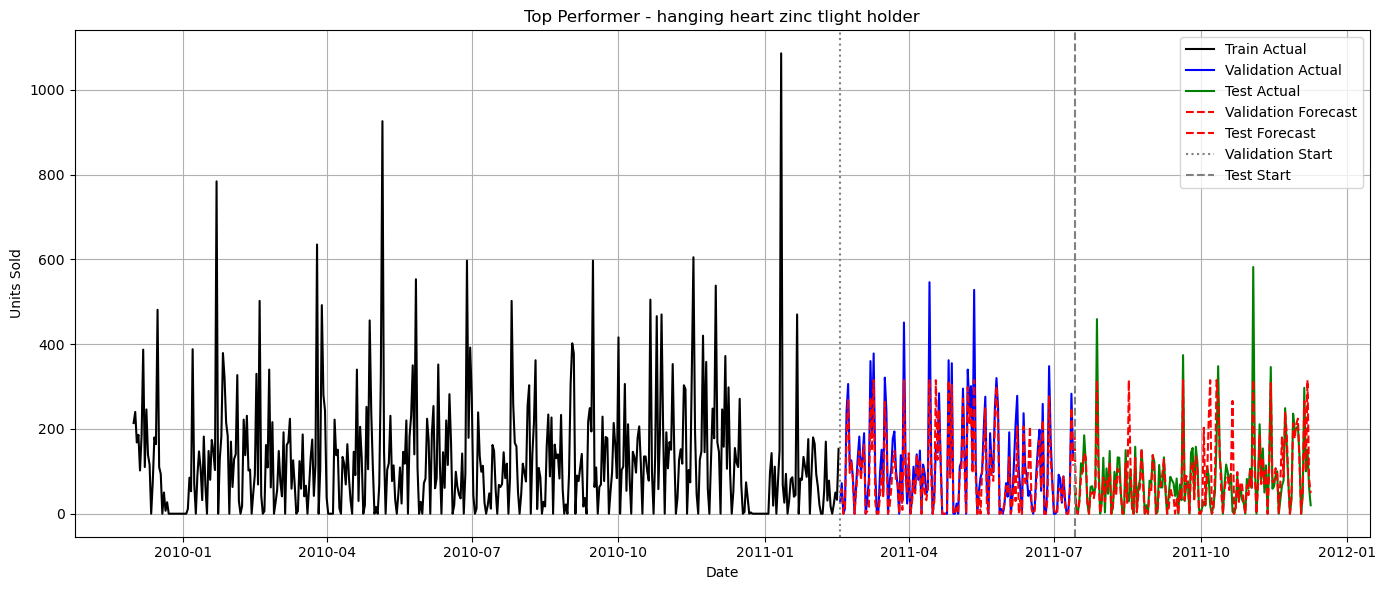

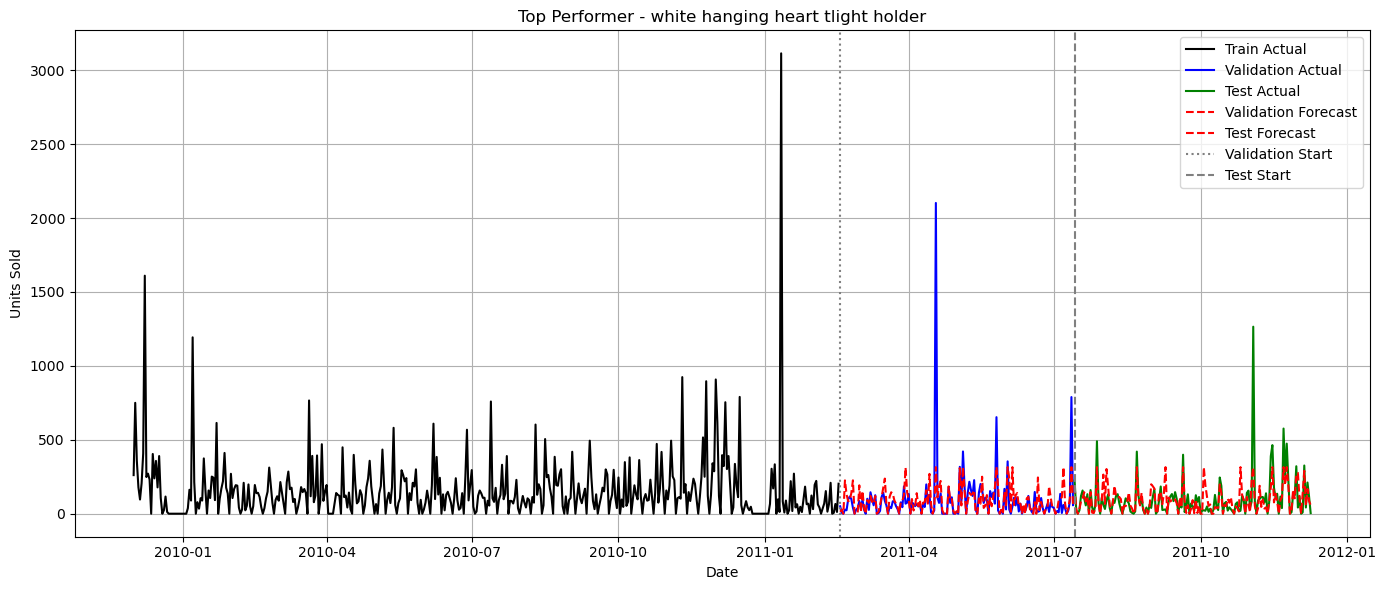

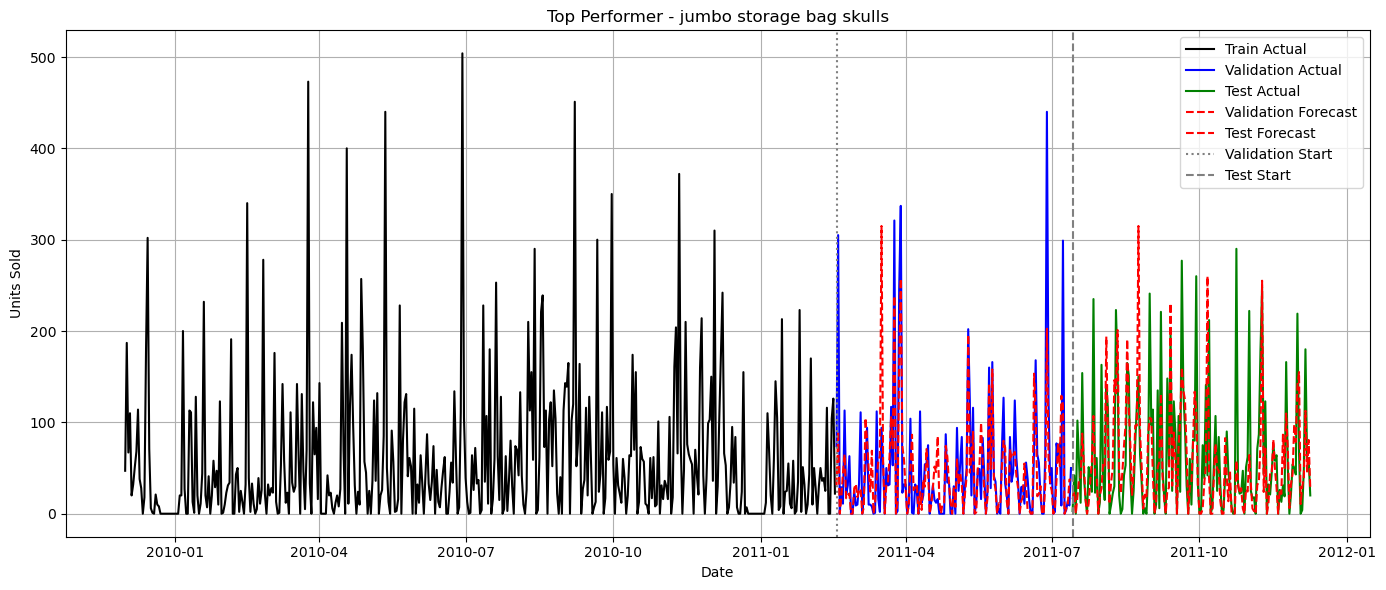

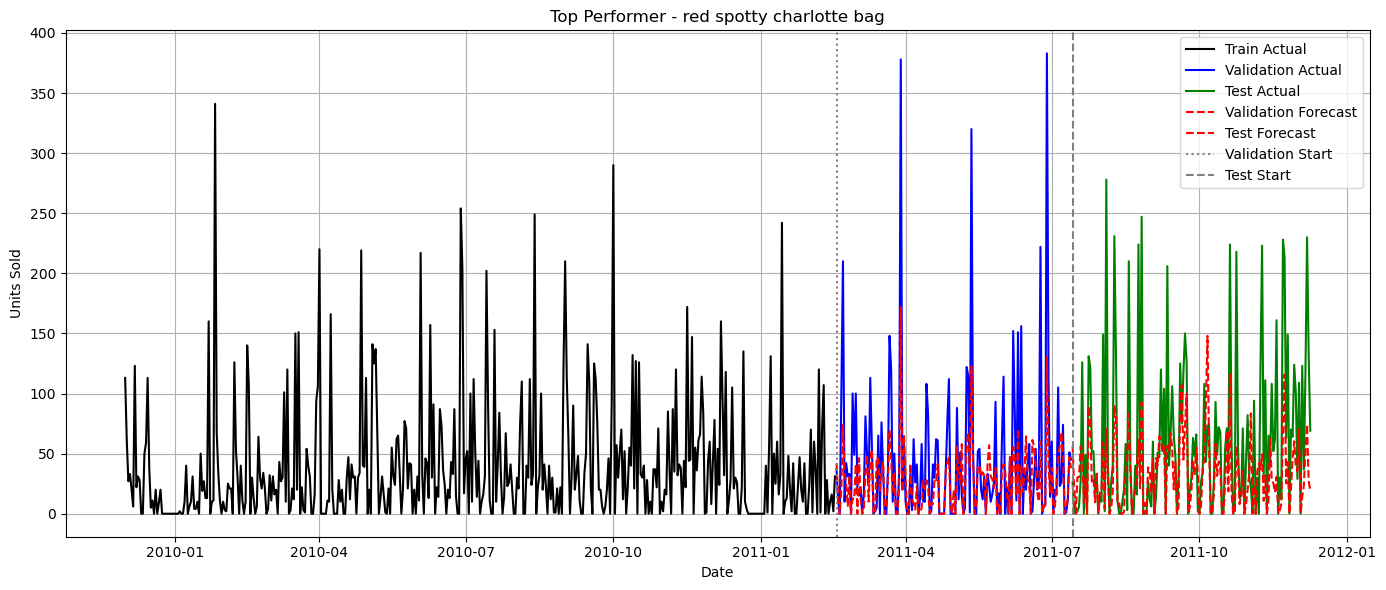

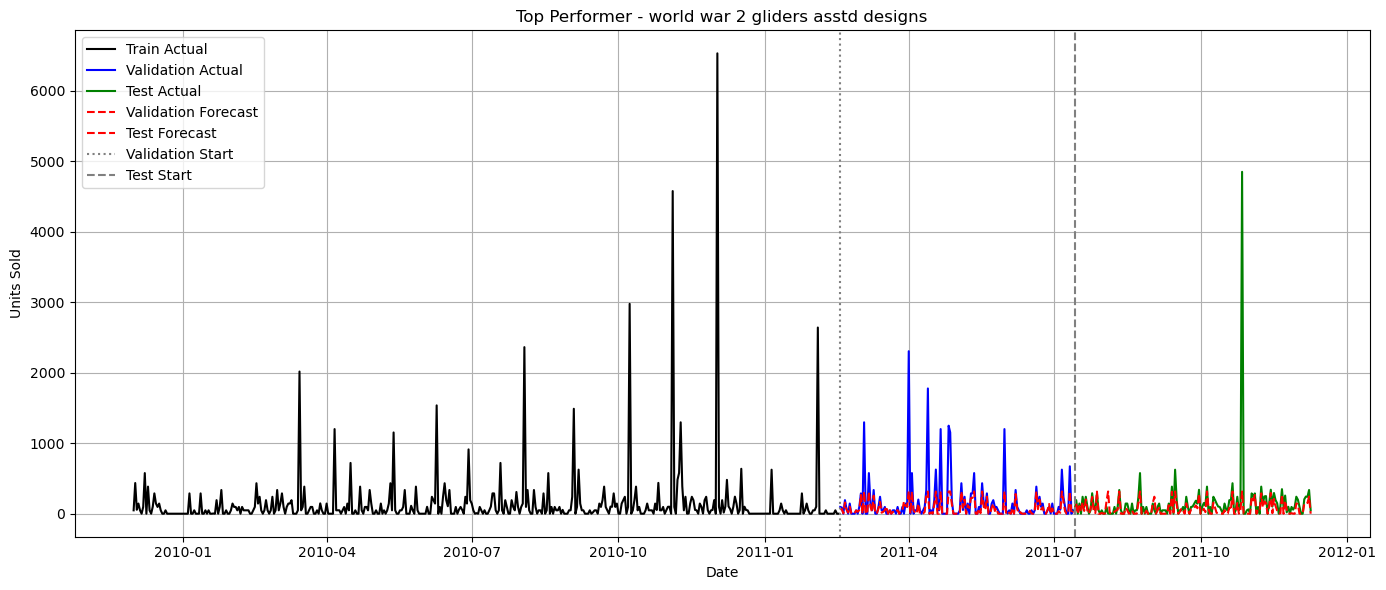

In [23]:
# Plot top 5
for r in top_5:
    plot_forecasts(r, "Top Performer")

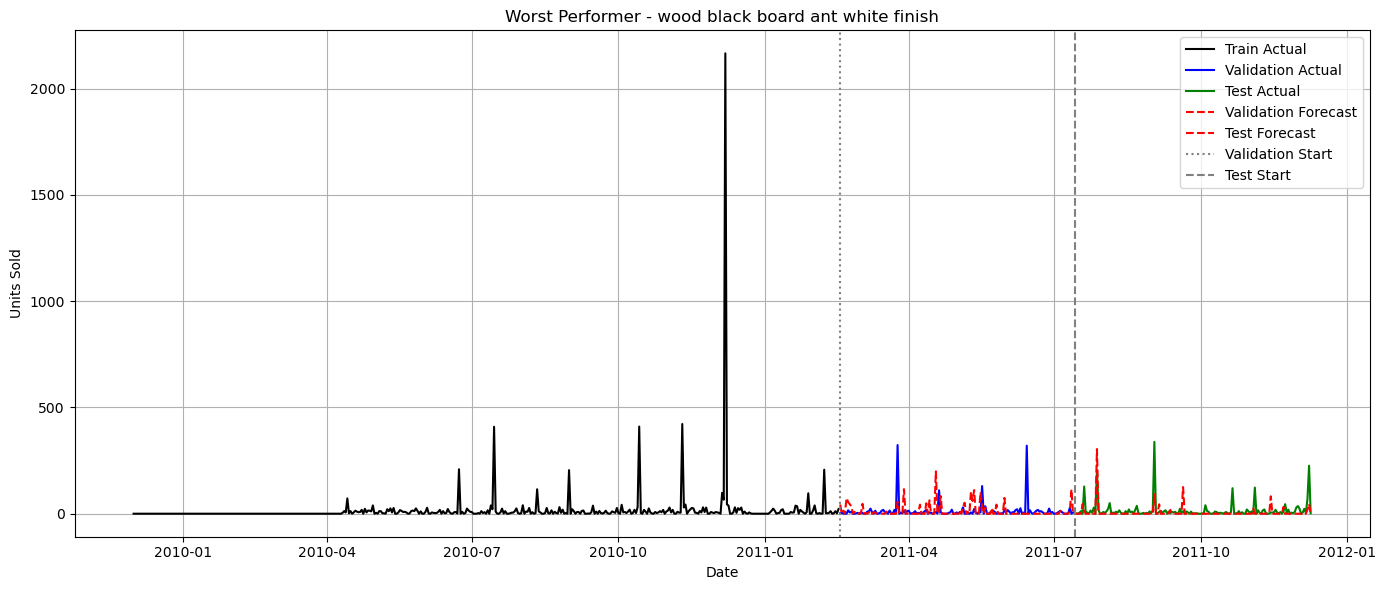

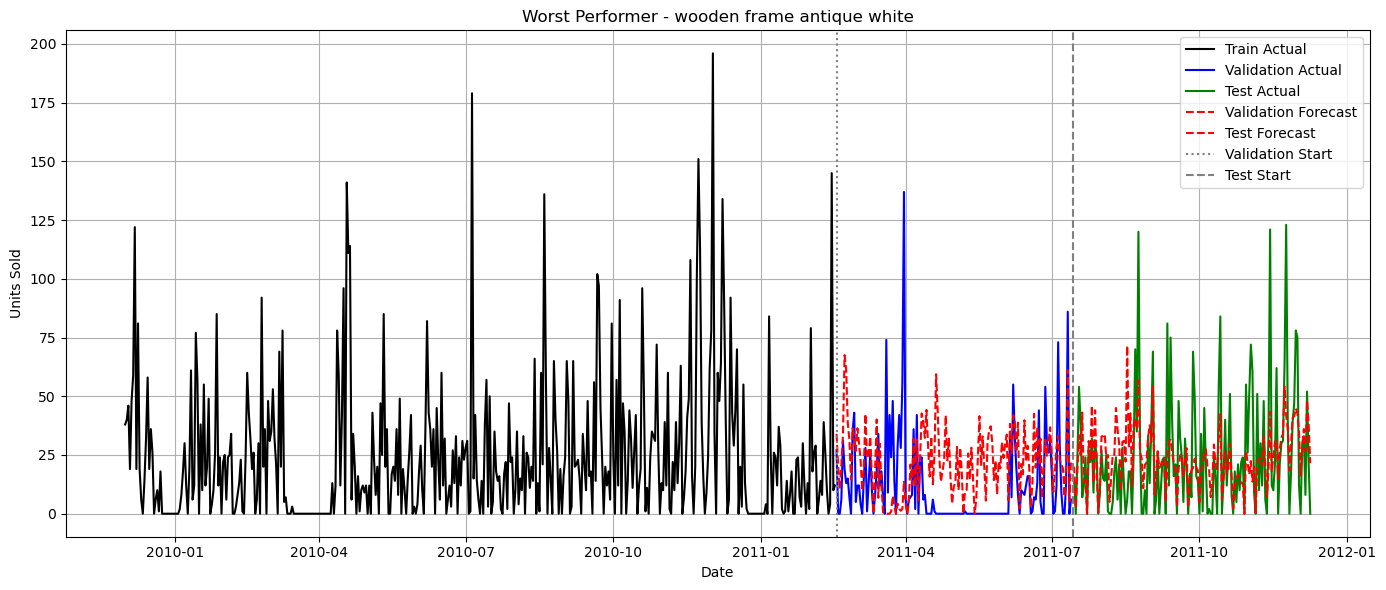

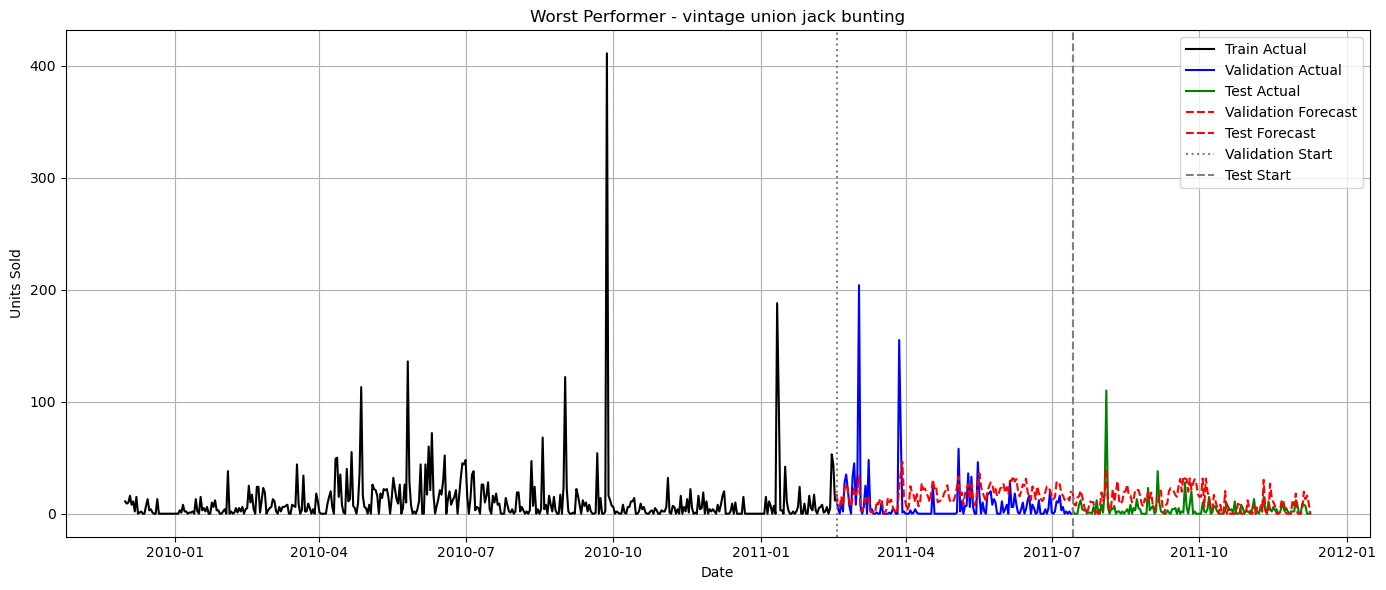

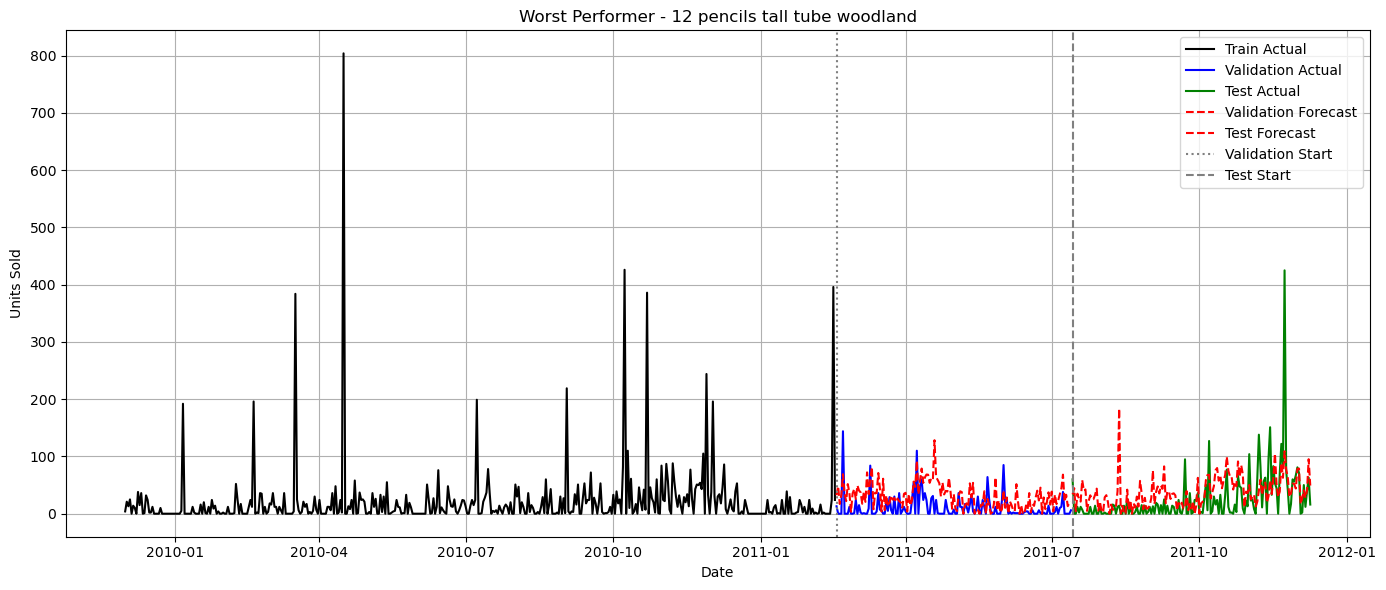

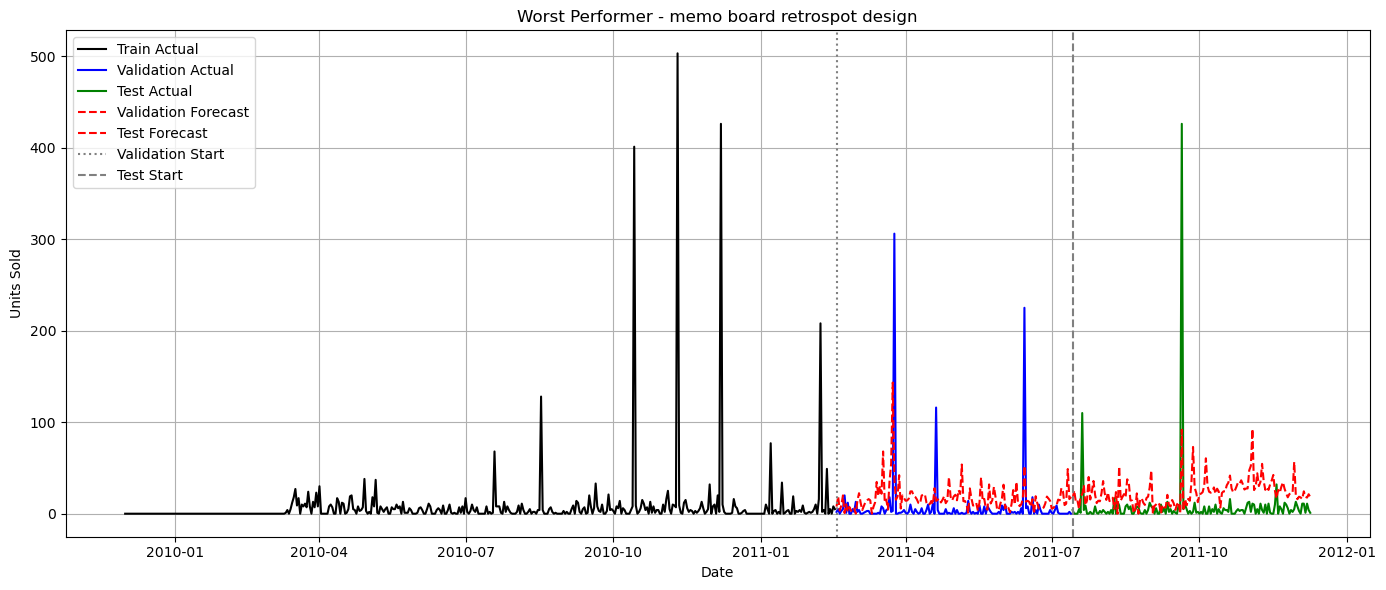

In [24]:
for r in bottom_5:
    plot_forecasts(r, "Worst Performer")